In [1]:
! pip install tqdm shap torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [shap]2/3 [shap]


In [2]:
! pip install seaborn

In [3]:
# ---------- Fast, resumable MDN seed-ensembling with stability features ----------
# Optimized for A100/PyTorch 2.0+ with model compilation, stability features (LR schedule, clipping),
# and full output saving for component analysis.

import os, time, math, json, random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ---------------- User configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized" 
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
os.makedirs(EN_DIR, exist_ok=True)

N_SEEDS = 10
SEEDS = [42 + i for i in range(N_SEEDS)]
BATCH = 256
MAX_EPOCHS = 300
PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 8
PIN_MEMORY = True if DEVICE.type == "cuda" else False
RESUME_IF_EXISTS = True
N_COMPONENTS = 5

if DEVICE.type == "cuda":
    torch.set_float32_matmul_precision('high')
    torch.backends.cudnn.benchmark = True

print("Device:", DEVICE)

# ---------------- Data Loading ----------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# ---------------- Physics feature engineering ----------------
M_p = 938.272088; M_n = 939.565420; epsilon=1e-30; LN10=np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu_MeVc2+epsilon),0,np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"],1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"],1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."],1e-30,np.inf))

log10_exp_term = (2*np.pi*df["eta"])/LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# ---------------- 29 training features ----------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# ---------------- Split by reaction ----------------
train_file = Path(OUTDIR_BASE)/"train_reactions.csv"
val_file   = Path(OUTDIR_BASE)/"val_reactions.csv"
test_file  = Path(OUTDIR_BASE)/"test_reactions.csv"

if train_file.exists():
    train_reacts = pd.read_csv(train_file)["Reaction"].values
    val_reacts   = pd.read_csv(val_file)["Reaction"].values
    test_reacts  = pd.read_csv(test_file)["Reaction"].values
else:
    reactions = df["Reaction"].unique()
    np.random.seed(42); np.random.shuffle(reactions)
    n = len(reactions)
    train_reacts = reactions[:int(0.7*n)]
    val_reacts   = reactions[int(0.7*n):int(0.8*n)]
    test_reacts  = reactions[int(0.8*n):]
    pd.DataFrame({"Reaction":train_reacts}).to_csv(train_file,index=False)
    pd.DataFrame({"Reaction":val_reacts}).to_csv(val_file,index=False)
    pd.DataFrame({"Reaction":test_reacts}).to_csv(test_file,index=False)

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)
test_mask  = df["Reaction"].isin(test_reacts)

test_rows = df.loc[test_mask].reset_index(drop=True)

# ---------------- Prepare training data ----------------
X_train_full = df.loc[train_mask|val_mask, features_train].values.astype(np.float32)
y_train_full = df.loc[train_mask|val_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

X_test = df.loc[test_mask, features_train].values.astype(np.float32)
y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

scaler = StandardScaler().fit(X_train_full)
joblib.dump(scaler, os.path.join(EN_DIR,"scaler.pkl"))

X_train_full_s = scaler.transform(X_train_full)
X_test_s       = scaler.transform(X_test)

# ---------------- MDN definition ----------------
class MDN(nn.Module):
    def __init__(self,in_dim,hidden=64,n_components=N_COMPONENTS,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden,hidden), nn.ReLU(), nn.Dropout(dropout)
        )
        self.fc_pi = nn.Linear(hidden,n_components)
        self.fc_mu = nn.Linear(hidden,n_components)
        self.fc_sigma = nn.Linear(hidden,n_components)
    def forward(self,x):
        h = self.net(x)
        pi = torch.softmax(self.fc_pi(h),1)
        mu = self.fc_mu(h)
        sigma = torch.nn.functional.softplus(self.fc_sigma(h))+1e-6
        return pi,mu,sigma

def mdn_loss(pi,mu,sigma,y):
    yexp = y.repeat(1,mu.shape[1])
    logg = -0.5*((yexp-mu)/sigma)**2 - torch.log(sigma) - 0.5*np.log(2*np.pi)
    logmix = torch.logsumexp(torch.log(pi+1e-12)+logg,dim=1)
    return -logmix.mean()

def mdn_predict_mode(pi,mu,sigma):
    idx = torch.argmax(pi,1)
    return mu[torch.arange(len(idx)), idx].unsqueeze(1)

def seed_worker(worker_id):
    ws = torch.initial_seed() % 2**32
    np.random.seed(ws); random.seed(ws)

def make_loader(X,y,batch=BATCH,shuffle=True):
    return DataLoader(
        TensorDataset(torch.tensor(X),torch.tensor(y)),
        batch_size=batch, shuffle=shuffle,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
        worker_init_fn=seed_worker
    )

# ---------------- Training ----------------
all_preds = []

for s in SEEDS:
    print("\n=== Seed", s, "===")
    seed_dir = os.path.join(EN_DIR,f"seed_{s}")
    os.makedirs(seed_dir,exist_ok=True)

    ckpt_path = os.path.join(seed_dir,"mdn_best.pth")
    dist_path = os.path.join(seed_dir,"mdn_test_components.npz")

    torch.manual_seed(s); np.random.seed(s); random.seed(s)

    n_all = len(X_train_full_s)
    perm = np.random.permutation(n_all)
    val_size = max(int(0.05*n_all),1)
    val_idx = perm[:val_size]
    tr_idx  = perm[val_size:]

    tr_loader = make_loader(X_train_full_s[tr_idx],y_train_full[tr_idx])
    val_loader= make_loader(X_train_full_s[val_idx],y_train_full[val_idx],shuffle=False)

    model = MDN(X_train_full_s.shape[1], hidden=64, n_components=N_COMPONENTS).to(DEVICE)

    if DEVICE.type=="cuda" and torch.__version__.startswith("2."):
        print("Compiling model...")
        model = torch.compile(model)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

    # AMP
    scaler_amp = torch.amp.GradScaler('cuda') if DEVICE.type=="cuda" else None

    best_val=float("inf"); patience_ctr=0

    # resume?
    if RESUME_IF_EXISTS and os.path.exists(ckpt_path):
        try:
            saved=torch.load(ckpt_path,map_location="cpu")
            model.load_state_dict(saved["state"])
            best_val=saved["best_val"]
            print("Resumed from",ckpt_path)
        except:
            print("Resume failed. Training fresh.")

    # --------- Train ---------
    for epoch in range(MAX_EPOCHS):
        model.train()
        epoch_loss=0.0
        pbar=tqdm(tr_loader,desc=f"seed{s} epoch{epoch}",leave=False)

        for xb,yb in pbar:
            xb=xb.to(DEVICE).float(); yb=yb.to(DEVICE).float()
            opt.zero_grad()

            if DEVICE.type=="cuda":
                with torch.amp.autocast(device_type='cuda'):
                    pi,mu,sigma=model(xb)
                    loss=mdn_loss(pi,mu,sigma,yb)

                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(opt)
                nn.utils.clip_grad_norm_(model.parameters(),4.0)
                scaler_amp.step(opt)
                scaler_amp.update()

            else:
                pi,mu,sigma=model(xb)
                loss=mdn_loss(pi,mu,sigma,yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(),4.0)
                opt.step()

            epoch_loss+=loss.item()*xb.size(0)
            pbar.set_postfix({"loss":f"{epoch_loss/(pbar.n+1e-12):.4f}"})

        epoch_loss/=len(tr_loader.dataset)

        # validation
        model.eval()
        val_loss=0.0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb=xb.to(DEVICE).float(); yb=yb.to(DEVICE).float()
                pi,mu,sigma=model(xb)
                val_loss+=mdn_loss(pi,mu,sigma,yb).item()*xb.size(0)
        val_loss/=len(val_loader.dataset)

        scheduler.step(val_loss)

        tqdm.write(f"[seed{s}] epoch {epoch} train={epoch_loss:.4f} val={val_loss:.4f}")

        # early stop
        if val_loss < best_val - 1e-9:
            best_val = val_loss
            torch.save({"state":model.state_dict(),"best_val":best_val}, ckpt_path)
            patience_ctr=0
        else:
            patience_ctr+=1

        if patience_ctr >= PATIENCE:
            print(f"[seed{s}] Early stop at epoch {epoch}")
            break

    # ---------------- Test inference ----------------
    print(f"[seed{s}] Loading best model...")
    saved=torch.load(ckpt_path,map_location=DEVICE)
    model.load_state_dict(saved["state"])
    model.eval()

    test_loader = make_loader(X_test_s,y_test,shuffle=False)

    preds_list=[]; pi_list=[]; mu_list=[]; sigma_list=[]

    with torch.no_grad():
        for xb,_ in tqdm(test_loader,desc=f"seed{s} test",leave=False):
            xb=xb.to(DEVICE).float()
            pi,mu,sigma=model(xb)

            pred = mdn_predict_mode(pi,mu,sigma)
            preds_list.append(pred.cpu().numpy())

            pi_list.append(pi.cpu().numpy())
            mu_list.append(mu.cpu().numpy())
            sigma_list.append(sigma.cpu().numpy())

    preds_arr=np.vstack(preds_list).flatten()
    all_preds.append(preds_arr)

    # save test components
    np.savez(dist_path,
        pi=np.vstack(pi_list),
        mu=np.vstack(mu_list),
        sigma=np.vstack(sigma_list)
    )

    print(f"[seed{s}] Test metrics: RMSE={np.sqrt(mean_squared_error(y_test.flatten(),preds_arr)):.4f}")

    # ---------------------------------------------------------------------
    #  NEW: FULL-DATASET INFERENCE FOR SHAP ANALYSIS
    # ---------------------------------------------------------------------
    print(f"[seed{s}] Computing FULL dataset components...")

    X_all = df[features_train].values.astype(np.float32)
    X_all_s = scaler.transform(X_all)

    full_loader = make_loader(X_all_s, np.zeros((len(X_all_s),1)), shuffle=False)

    pi_all=[]; mu_all=[]; sigma_all=[]

    with torch.no_grad():
        for xb,_ in tqdm(full_loader,desc=f"seed{s} full-data",leave=False):
            xb = xb.to(DEVICE).float()
            pi,mu,sigma = model(xb)
            pi_all.append(pi.cpu().numpy())
            mu_all.append(mu.cpu().numpy())
            sigma_all.append(sigma.cpu().numpy())

    pi_all=np.vstack(pi_all)
    mu_all=np.vstack(mu_all)
    sigma_all=np.vstack(sigma_all)

    np.savez(
        os.path.join(seed_dir,"mdn_all_components.npz"),
        pi=pi_all,
        mu=mu_all,
        sigma=sigma_all
    )

    print(f"[seed{s}] Saved FULL DATA → mdn_all_components.npz")

# ---------------- Ensemble results ----------------
all_preds_arr=np.vstack(all_preds)
delta_ens=all_preds_arr.mean(axis=0)

test_local=test_rows.copy()
eta_test=test_local["eta"].values
log10_S_cal_test=test_local["log10_S_cal"].values

log10_S_pred = log10_S_cal_test + delta_ens
log10_sigma_pred = (
    log10_S_pred
    - np.log10(np.clip(test_local["E c.m."].values,1e-30,np.inf))
    - (2*np.pi*eta_test)/LN10
)
sigma_pred = 10**(log10_sigma_pred)

sigma_true = test_local["σ"].values
delta_true = test_local["delta_log10_S"].values

print("\n=== Ensemble Final Results ===")
print("RMSE(delta):", np.sqrt(mean_squared_error(delta_true,delta_ens)))
print("R2(delta):  ", r2_score(delta_true,delta_ens))
print("R2(logσ):   ", r2_score(np.log10(sigma_true+1e-30),log10_sigma_pred))

pd.DataFrame({
    "Reaction":test_local["Reaction"],
    "E c.m.":test_local["E c.m."],
    "sigma_true":sigma_true,
    "sigma_pred":sigma_pred,
    "delta_ens":delta_ens
}).to_csv(os.path.join(EN_DIR,"ensemble_predictions_final.csv"),index=False)

print("DONE")


Device: cpu


/tmp/ipykernel_146/2211861416.py:102: UserWarning: you are shuffling a 'ArrowStringArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.seed(42); np.random.shuffle(reactions)



=== Seed 42 ===


seed42 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 0 train=0.5505 val=0.5392


seed42 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 1 train=0.3797 val=0.3664


seed42 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 2 train=0.1867 val=0.1812


seed42 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 3 train=0.0826 val=0.0394


seed42 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 4 train=-0.0041 val=0.0030


seed42 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 5 train=-0.0720 val=-0.0848


seed42 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 6 train=-0.1245 val=-0.0968


seed42 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 7 train=-0.1849 val=-0.1202


seed42 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 8 train=-0.2156 val=-0.1933


seed42 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 9 train=-0.2516 val=-0.2030


seed42 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 10 train=-0.2946 val=-0.2001


seed42 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 11 train=-0.3236 val=-0.2551


seed42 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 12 train=-0.3651 val=-0.2885


seed42 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 13 train=-0.3737 val=-0.2857


seed42 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 14 train=-0.3954 val=-0.3182


seed42 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 15 train=-0.4307 val=-0.3529


seed42 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 16 train=-0.4550 val=-0.3954


seed42 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 17 train=-0.4671 val=-0.3557


seed42 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 18 train=-0.4759 val=-0.4435


seed42 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 19 train=-0.4979 val=-0.4795


seed42 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 20 train=-0.5361 val=-0.4473


seed42 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 21 train=-0.5311 val=-0.5195


seed42 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 22 train=-0.5601 val=-0.5108


seed42 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 23 train=-0.5642 val=-0.5319


seed42 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 24 train=-0.5902 val=-0.5677


seed42 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 25 train=-0.5992 val=-0.5516


seed42 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 26 train=-0.6111 val=-0.5850


seed42 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 27 train=-0.6269 val=-0.6142


seed42 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 28 train=-0.6119 val=-0.6139


seed42 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 29 train=-0.6348 val=-0.6387


seed42 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 30 train=-0.6553 val=-0.6437


seed42 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 31 train=-0.6749 val=-0.6548


seed42 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 32 train=-0.6727 val=-0.6835


seed42 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 33 train=-0.7137 val=-0.6899


seed42 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 34 train=-0.6983 val=-0.6937


seed42 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 35 train=-0.7175 val=-0.7113


seed42 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 36 train=-0.7293 val=-0.7471


seed42 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 37 train=-0.7184 val=-0.7321


seed42 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 38 train=-0.7428 val=-0.7498


seed42 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 39 train=-0.7526 val=-0.7490


seed42 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 40 train=-0.7658 val=-0.7415


seed42 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 41 train=-0.7796 val=-0.7830


seed42 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 42 train=-0.8018 val=-0.7864


seed42 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 43 train=-0.8045 val=-0.8037


seed42 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 44 train=-0.7814 val=-0.7993


seed42 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 45 train=-0.7942 val=-0.8093


seed42 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 46 train=-0.8215 val=-0.8236


seed42 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 47 train=-0.8049 val=-0.8176


seed42 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 48 train=-0.8048 val=-0.8185


seed42 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 49 train=-0.8142 val=-0.8297


seed42 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 50 train=-0.8062 val=-0.8338


seed42 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 51 train=-0.8061 val=-0.8691


seed42 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 52 train=-0.8346 val=-0.8621


seed42 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 53 train=-0.8177 val=-0.8574


seed42 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 54 train=-0.8480 val=-0.8506


seed42 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 55 train=-0.8517 val=-0.8694


seed42 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 56 train=-0.8441 val=-0.8817


seed42 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 57 train=-0.8777 val=-0.8815


seed42 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 58 train=-0.8777 val=-0.9025


seed42 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 59 train=-0.8950 val=-0.8782


seed42 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 60 train=-0.8867 val=-0.8704


seed42 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 61 train=-0.8879 val=-0.9087


seed42 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 62 train=-0.8961 val=-0.8896


seed42 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 63 train=-0.8843 val=-0.8936


seed42 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 64 train=-0.8777 val=-0.9091


seed42 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 65 train=-0.9021 val=-0.9281


seed42 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 66 train=-0.9294 val=-0.9003


seed42 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 67 train=-0.9338 val=-0.9217


seed42 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 68 train=-0.8952 val=-0.9315


seed42 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 69 train=-0.9226 val=-0.9397


seed42 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 70 train=-0.9370 val=-0.9498


seed42 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 71 train=-0.9224 val=-0.9333


seed42 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 72 train=-0.9319 val=-0.9648


seed42 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 73 train=-0.9508 val=-0.9869


seed42 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 74 train=-0.9293 val=-0.9358


seed42 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 75 train=-0.9346 val=-0.9780


seed42 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 76 train=-0.9499 val=-0.9624


seed42 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 77 train=-0.9507 val=-0.9617


seed42 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 78 train=-0.9441 val=-0.9653


seed42 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 79 train=-0.9589 val=-0.9516


seed42 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 80 train=-0.9495 val=-0.9773


seed42 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 81 train=-0.9598 val=-0.9758


seed42 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 82 train=-0.9564 val=-0.9646


seed42 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 83 train=-0.9498 val=-0.9623


seed42 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 84 train=-0.9805 val=-0.9805


seed42 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 85 train=-0.9789 val=-0.9749


seed42 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 86 train=-0.9739 val=-0.9950


seed42 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 87 train=-0.9788 val=-0.9905


seed42 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 88 train=-1.0030 val=-0.9927


seed42 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 89 train=-1.0017 val=-0.9816


seed42 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 90 train=-0.9783 val=-1.0088


seed42 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 91 train=-0.9932 val=-1.0093


seed42 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 92 train=-0.9823 val=-1.0254


seed42 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 93 train=-0.9958 val=-1.0246


seed42 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 94 train=-0.9908 val=-1.0160


seed42 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 95 train=-0.9961 val=-1.0025


seed42 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 96 train=-0.9910 val=-1.0032


seed42 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 97 train=-0.9968 val=-1.0140


seed42 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 98 train=-1.0145 val=-1.0031


seed42 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 99 train=-1.0051 val=-0.9979


seed42 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 100 train=-1.0121 val=-1.0051


seed42 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 101 train=-1.0082 val=-0.9994


seed42 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 102 train=-1.0137 val=-1.0119


seed42 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 103 train=-1.0178 val=-1.0253


seed42 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 104 train=-1.0112 val=-1.0247


seed42 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 105 train=-1.0223 val=-1.0277


seed42 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 106 train=-1.0293 val=-1.0227


seed42 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 107 train=-1.0192 val=-1.0199


seed42 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 108 train=-1.0177 val=-1.0147


seed42 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 109 train=-1.0338 val=-1.0245


seed42 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 110 train=-1.0195 val=-1.0317


seed42 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 111 train=-1.0224 val=-1.0350


seed42 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 112 train=-1.0293 val=-1.0316


seed42 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 113 train=-1.0303 val=-1.0368


seed42 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 114 train=-1.0308 val=-1.0430


seed42 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 115 train=-1.0409 val=-1.0464


seed42 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 116 train=-1.0137 val=-1.0437


seed42 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 117 train=-1.0551 val=-1.0459


seed42 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 118 train=-1.0433 val=-1.0497


seed42 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 119 train=-0.9994 val=-1.0503


seed42 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 120 train=-1.0512 val=-1.0389


seed42 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 121 train=-1.0376 val=-1.0453


seed42 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 122 train=-1.0303 val=-1.0383


seed42 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 123 train=-1.0411 val=-1.0443


seed42 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 124 train=-1.0223 val=-1.0355


seed42 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 125 train=-1.0402 val=-1.0460


seed42 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 126 train=-1.0217 val=-1.0474


seed42 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 127 train=-1.0357 val=-1.0483


seed42 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 128 train=-1.0279 val=-1.0491


seed42 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 129 train=-1.0419 val=-1.0514


seed42 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 130 train=-1.0305 val=-1.0536


seed42 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 131 train=-1.0302 val=-1.0530


seed42 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 132 train=-1.0579 val=-1.0650


seed42 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 133 train=-1.0332 val=-1.0658


seed42 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 134 train=-1.0436 val=-1.0636


seed42 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 135 train=-1.0224 val=-1.0580


seed42 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 136 train=-1.0419 val=-1.0636


seed42 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 137 train=-1.0274 val=-1.0609


seed42 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 138 train=-1.0466 val=-1.0670


seed42 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 139 train=-1.0550 val=-1.0633


seed42 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 140 train=-1.0597 val=-1.0677


seed42 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 141 train=-1.0554 val=-1.0710


seed42 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 142 train=-1.0776 val=-1.0679


seed42 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 143 train=-1.0484 val=-1.0714


seed42 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 144 train=-1.0427 val=-1.0696


seed42 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 145 train=-1.0670 val=-1.0788


seed42 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 146 train=-1.0620 val=-1.0773


seed42 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 147 train=-1.0728 val=-1.0786


seed42 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 148 train=-1.0754 val=-1.0741


seed42 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 149 train=-1.0652 val=-1.0702


seed42 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 150 train=-1.0727 val=-1.0766


seed42 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 151 train=-1.0411 val=-1.0739


seed42 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 152 train=-1.0618 val=-1.0778


seed42 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 153 train=-1.0579 val=-1.0753


seed42 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 154 train=-1.0590 val=-1.0730


seed42 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 155 train=-1.0539 val=-1.0748


seed42 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 156 train=-1.0536 val=-1.0809


seed42 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 157 train=-1.0705 val=-1.0805


seed42 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 158 train=-1.0702 val=-1.0777


seed42 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 159 train=-1.0760 val=-1.0787


seed42 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 160 train=-1.0750 val=-1.0808


seed42 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 161 train=-1.0759 val=-1.0879


seed42 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 162 train=-1.0672 val=-1.0820


seed42 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 163 train=-1.0599 val=-1.0843


seed42 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 164 train=-1.0640 val=-1.0782


seed42 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 165 train=-1.0742 val=-1.0786


seed42 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 166 train=-1.0543 val=-1.0795


seed42 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 167 train=-1.0920 val=-1.0849


seed42 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 168 train=-1.0771 val=-1.0800


seed42 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 169 train=-1.0612 val=-1.0863


seed42 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 170 train=-1.0719 val=-1.0883


seed42 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 171 train=-1.0858 val=-1.0890


seed42 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 172 train=-1.0723 val=-1.0904


seed42 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 173 train=-1.0563 val=-1.0835


seed42 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 174 train=-1.0511 val=-1.0812


seed42 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 175 train=-1.0917 val=-1.0874


seed42 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 176 train=-1.0572 val=-1.0807


seed42 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 177 train=-1.0641 val=-1.0855


seed42 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 178 train=-1.0857 val=-1.0887


seed42 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 179 train=-1.0728 val=-1.0898


seed42 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 180 train=-1.0819 val=-1.0831


seed42 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 181 train=-1.0725 val=-1.0887


seed42 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 182 train=-1.0582 val=-1.0779


seed42 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 183 train=-1.0769 val=-1.0785


seed42 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 184 train=-1.0907 val=-1.0841


seed42 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 185 train=-1.0911 val=-1.0837


seed42 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 186 train=-1.0634 val=-1.0918


seed42 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 187 train=-1.0741 val=-1.0948


seed42 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 188 train=-1.0663 val=-1.0964


seed42 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 189 train=-1.0770 val=-1.0975


seed42 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 190 train=-1.0950 val=-1.0978


seed42 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 191 train=-1.0913 val=-1.1028


seed42 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 192 train=-1.0789 val=-1.0975


seed42 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 193 train=-1.0804 val=-1.0940


seed42 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 194 train=-1.1007 val=-1.0966


seed42 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 195 train=-1.0734 val=-1.0978


seed42 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 196 train=-1.1027 val=-1.0964


seed42 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 197 train=-1.0799 val=-1.1008


seed42 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 198 train=-1.0738 val=-1.0962


seed42 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 199 train=-1.0882 val=-1.0904


seed42 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 200 train=-1.0884 val=-1.0945


seed42 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 201 train=-1.0838 val=-1.0965


seed42 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 202 train=-1.0815 val=-1.0939


seed42 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 203 train=-1.0828 val=-1.0977


seed42 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 204 train=-1.0925 val=-1.0990


seed42 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 205 train=-1.0795 val=-1.0952


seed42 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 206 train=-1.1089 val=-1.0941


seed42 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 207 train=-1.0683 val=-1.0962


seed42 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 208 train=-1.0842 val=-1.0951


seed42 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 209 train=-1.0947 val=-1.0960


seed42 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 210 train=-1.1061 val=-1.0985


seed42 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 211 train=-1.1032 val=-1.0985
[seed42] Early stop at epoch 211
[seed42] Loading best model...


seed42 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed42] Test metrics: RMSE=0.2003
[seed42] Computing FULL dataset components...


seed42 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed42] Saved FULL DATA → mdn_all_components.npz

=== Seed 43 ===


seed43 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 0 train=0.5707 val=0.5010


seed43 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 1 train=0.3901 val=0.2865


seed43 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 2 train=0.1837 val=0.0965


seed43 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 3 train=0.1061 val=-0.0218


seed43 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 4 train=0.0084 val=-0.1068


seed43 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 5 train=-0.0608 val=-0.2231


seed43 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 6 train=-0.1364 val=-0.2882


seed43 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 7 train=-0.1837 val=-0.3318


seed43 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 8 train=-0.2363 val=-0.3929


seed43 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 9 train=-0.2680 val=-0.3988


seed43 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 10 train=-0.3124 val=-0.4345


seed43 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 11 train=-0.3283 val=-0.4811


seed43 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 12 train=-0.3594 val=-0.4773


seed43 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 13 train=-0.3917 val=-0.5246


seed43 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 14 train=-0.4231 val=-0.5448


seed43 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 15 train=-0.4389 val=-0.5364


seed43 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 16 train=-0.4711 val=-0.5660


seed43 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 17 train=-0.4943 val=-0.5689


seed43 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 18 train=-0.4983 val=-0.5960


seed43 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 19 train=-0.5001 val=-0.6057


seed43 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 20 train=-0.5318 val=-0.6371


seed43 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 21 train=-0.5540 val=-0.6489


seed43 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 22 train=-0.5411 val=-0.6355


seed43 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 23 train=-0.5647 val=-0.6457


seed43 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 24 train=-0.5872 val=-0.6610


seed43 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 25 train=-0.6064 val=-0.6889


seed43 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 26 train=-0.6225 val=-0.7051


seed43 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 27 train=-0.5993 val=-0.6667


seed43 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 28 train=-0.6367 val=-0.7270


seed43 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 29 train=-0.6519 val=-0.7590


seed43 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 30 train=-0.6461 val=-0.7620


seed43 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 31 train=-0.6710 val=-0.7700


seed43 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 32 train=-0.6628 val=-0.7689


seed43 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 33 train=-0.6950 val=-0.7366


seed43 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 34 train=-0.6729 val=-0.7978


seed43 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 35 train=-0.7141 val=-0.7886


seed43 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 36 train=-0.7165 val=-0.8200


seed43 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 37 train=-0.7147 val=-0.8025


seed43 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 38 train=-0.7244 val=-0.8232


seed43 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 39 train=-0.7421 val=-0.8387


seed43 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 40 train=-0.7438 val=-0.8383


seed43 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 41 train=-0.7596 val=-0.8565


seed43 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 42 train=-0.7724 val=-0.8878


seed43 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 43 train=-0.7618 val=-0.8555


seed43 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 44 train=-0.7773 val=-0.8539


seed43 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 45 train=-0.7785 val=-0.8794


seed43 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 46 train=-0.7944 val=-0.8893


seed43 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 47 train=-0.8159 val=-0.8842


seed43 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 48 train=-0.8062 val=-0.8814


seed43 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 49 train=-0.8011 val=-0.9190


seed43 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 50 train=-0.8182 val=-0.9017


seed43 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 51 train=-0.8222 val=-0.9187


seed43 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 52 train=-0.8119 val=-0.9162


seed43 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 53 train=-0.8612 val=-0.9520


seed43 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 54 train=-0.8409 val=-0.9369


seed43 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 55 train=-0.8326 val=-0.9514


seed43 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 56 train=-0.8394 val=-0.9525


seed43 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 57 train=-0.8635 val=-0.9596


seed43 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 58 train=-0.8623 val=-0.9582


seed43 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 59 train=-0.8607 val=-0.9820


seed43 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 60 train=-0.8459 val=-0.9576


seed43 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 61 train=-0.8770 val=-0.9981


seed43 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 62 train=-0.8703 val=-0.9567


seed43 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 63 train=-0.8812 val=-1.0071


seed43 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 64 train=-0.8921 val=-0.9727


seed43 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 65 train=-0.8955 val=-0.9648


seed43 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 66 train=-0.8847 val=-0.9826


seed43 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 67 train=-0.9034 val=-1.0078


seed43 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 68 train=-0.9016 val=-0.9787


seed43 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 69 train=-0.8970 val=-1.0293


seed43 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 70 train=-0.9166 val=-0.9836


seed43 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 71 train=-0.9101 val=-0.9933


seed43 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 72 train=-0.9150 val=-0.9929


seed43 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 73 train=-0.9309 val=-1.0226


seed43 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 74 train=-0.9080 val=-1.0129


seed43 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 75 train=-0.9482 val=-1.0473


seed43 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 76 train=-0.9399 val=-1.0328


seed43 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 77 train=-0.9178 val=-0.9922


seed43 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 78 train=-0.9281 val=-1.0573


seed43 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 79 train=-0.9724 val=-1.0331


seed43 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 80 train=-0.9406 val=-1.0196


seed43 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 81 train=-0.9344 val=-1.0727


seed43 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 82 train=-0.9279 val=-1.0335


seed43 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 83 train=-0.9503 val=-1.0338


seed43 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 84 train=-0.9715 val=-1.0947


seed43 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 85 train=-0.9571 val=-1.0559


seed43 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 86 train=-0.9555 val=-1.0452


seed43 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 87 train=-0.9560 val=-1.0546


seed43 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 88 train=-0.9749 val=-1.0723


seed43 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 89 train=-0.9733 val=-1.0703


seed43 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 90 train=-0.9873 val=-1.0840


seed43 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 91 train=-0.9817 val=-1.0619


seed43 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 92 train=-0.9785 val=-1.0727


seed43 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 93 train=-0.9998 val=-1.0853


seed43 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 94 train=-0.9750 val=-1.0486


seed43 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 95 train=-0.9658 val=-1.0971


seed43 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 96 train=-0.9939 val=-1.0877


seed43 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 97 train=-1.0160 val=-1.0678


seed43 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 98 train=-0.9728 val=-1.0813


seed43 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 99 train=-1.0035 val=-1.1016


seed43 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 100 train=-0.9967 val=-1.0841


seed43 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 101 train=-1.0084 val=-1.0858


seed43 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 102 train=-1.0339 val=-1.1001


seed43 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 103 train=-1.0172 val=-1.1033


seed43 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 104 train=-1.0255 val=-1.1017


seed43 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 105 train=-1.0119 val=-1.1122


seed43 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 106 train=-1.0204 val=-1.1258


seed43 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 107 train=-1.0216 val=-1.1036


seed43 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 108 train=-1.0205 val=-1.1129


seed43 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 109 train=-1.0213 val=-1.1100


seed43 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 110 train=-1.0398 val=-1.1194


seed43 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 111 train=-1.0569 val=-1.1074


seed43 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 112 train=-1.0470 val=-1.1440


seed43 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 113 train=-1.0079 val=-1.0944


seed43 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 114 train=-1.0409 val=-1.1225


seed43 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 115 train=-1.0400 val=-1.1142


seed43 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 116 train=-1.0530 val=-1.1287


seed43 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 117 train=-1.0648 val=-1.1055


seed43 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 118 train=-1.0497 val=-1.1431


seed43 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 119 train=-1.0586 val=-1.1300


seed43 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 120 train=-1.0472 val=-1.1280


seed43 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 121 train=-1.0336 val=-1.1325


seed43 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 122 train=-1.0612 val=-1.1540


seed43 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 123 train=-1.0668 val=-1.1729


seed43 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 124 train=-1.0625 val=-1.1135


seed43 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 125 train=-1.0646 val=-1.1532


seed43 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 126 train=-1.0686 val=-1.1695


seed43 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 127 train=-1.0734 val=-1.1884


seed43 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 128 train=-1.0575 val=-1.1648


seed43 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 129 train=-1.0903 val=-1.1710


seed43 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 130 train=-1.0710 val=-1.1719


seed43 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 131 train=-1.0890 val=-1.1413


seed43 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 132 train=-1.0685 val=-1.1529


seed43 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 133 train=-1.0945 val=-1.1944


seed43 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 134 train=-1.0525 val=-1.1397


seed43 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 135 train=-1.1053 val=-1.1688


seed43 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 136 train=-1.0792 val=-1.1859


seed43 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 137 train=-1.0694 val=-1.1783


seed43 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 138 train=-1.1038 val=-1.2106


seed43 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 139 train=-1.0985 val=-1.1806


seed43 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 140 train=-1.1011 val=-1.1657


seed43 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 141 train=-1.0732 val=-1.2082


seed43 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 142 train=-1.1055 val=-1.1818


seed43 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 143 train=-1.0987 val=-1.1721


seed43 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 144 train=-1.1045 val=-1.1946


seed43 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 145 train=-1.1222 val=-1.1816


seed43 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 146 train=-1.1000 val=-1.1625


seed43 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 147 train=-1.1048 val=-1.1664


seed43 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 148 train=-1.0832 val=-1.1819


seed43 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 149 train=-1.0894 val=-1.1973


seed43 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 150 train=-1.1172 val=-1.1860


seed43 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 151 train=-1.1035 val=-1.1865


seed43 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 152 train=-1.1069 val=-1.1777


seed43 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 153 train=-1.1238 val=-1.1866


seed43 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 154 train=-1.1432 val=-1.2183


seed43 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 155 train=-1.1394 val=-1.1939


seed43 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 156 train=-1.1364 val=-1.2076


seed43 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 157 train=-1.1278 val=-1.2182


seed43 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 158 train=-1.1454 val=-1.2202


seed43 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 159 train=-1.1262 val=-1.2061


seed43 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 160 train=-1.1308 val=-1.2104


seed43 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 161 train=-1.1232 val=-1.2105


seed43 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 162 train=-1.1255 val=-1.2039


seed43 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 163 train=-1.1514 val=-1.1987


seed43 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 164 train=-1.1222 val=-1.2164


seed43 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 165 train=-1.1394 val=-1.2300


seed43 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 166 train=-1.1184 val=-1.2430


seed43 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 167 train=-1.1502 val=-1.2274


seed43 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 168 train=-1.1323 val=-1.2168


seed43 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 169 train=-1.1372 val=-1.2222


seed43 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 170 train=-1.1604 val=-1.2218


seed43 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 171 train=-1.1257 val=-1.2305


seed43 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 172 train=-1.1291 val=-1.2405


seed43 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 173 train=-1.1571 val=-1.2297


seed43 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 174 train=-1.1498 val=-1.2334


seed43 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 175 train=-1.1429 val=-1.2396


seed43 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 176 train=-1.1485 val=-1.2274


seed43 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 177 train=-1.1327 val=-1.2109


seed43 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 178 train=-1.1529 val=-1.2198


seed43 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 179 train=-1.1400 val=-1.2309


seed43 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 180 train=-1.1568 val=-1.2283


seed43 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 181 train=-1.1501 val=-1.2259


seed43 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 182 train=-1.1324 val=-1.2301


seed43 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 183 train=-1.1484 val=-1.2345


seed43 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 184 train=-1.1786 val=-1.2396


seed43 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 185 train=-1.1859 val=-1.2363


seed43 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 186 train=-1.1681 val=-1.2432


seed43 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 187 train=-1.1618 val=-1.2239


seed43 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 188 train=-1.1706 val=-1.2229


seed43 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 189 train=-1.1525 val=-1.2333


seed43 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 190 train=-1.1825 val=-1.2378


seed43 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 191 train=-1.1623 val=-1.2498


seed43 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 192 train=-1.1612 val=-1.2299


seed43 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 193 train=-1.1670 val=-1.2171


seed43 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 194 train=-1.1544 val=-1.2358


seed43 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 195 train=-1.1779 val=-1.2451


seed43 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 196 train=-1.1641 val=-1.2431


seed43 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 197 train=-1.1755 val=-1.2489


seed43 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 198 train=-1.1904 val=-1.2537


seed43 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 199 train=-1.1612 val=-1.2536


seed43 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 200 train=-1.1572 val=-1.2417


seed43 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 201 train=-1.1798 val=-1.2486


seed43 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 202 train=-1.1728 val=-1.2426


seed43 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 203 train=-1.1744 val=-1.2342


seed43 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 204 train=-1.1844 val=-1.2383


seed43 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 205 train=-1.1634 val=-1.2339


seed43 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 206 train=-1.1790 val=-1.2510


seed43 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 207 train=-1.1692 val=-1.2399


seed43 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 208 train=-1.1450 val=-1.2324


seed43 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 209 train=-1.1672 val=-1.2369


seed43 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 210 train=-1.1649 val=-1.2366


seed43 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 211 train=-1.1829 val=-1.2434


seed43 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 212 train=-1.1969 val=-1.2469


seed43 epoch213:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 213 train=-1.1837 val=-1.2430


seed43 epoch214:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 214 train=-1.1929 val=-1.2569


seed43 epoch215:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 215 train=-1.1917 val=-1.2490


seed43 epoch216:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 216 train=-1.1629 val=-1.2435


seed43 epoch217:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 217 train=-1.1934 val=-1.2423


seed43 epoch218:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 218 train=-1.1906 val=-1.2467


seed43 epoch219:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 219 train=-1.1841 val=-1.2478


seed43 epoch220:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 220 train=-1.1822 val=-1.2478


seed43 epoch221:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 221 train=-1.2055 val=-1.2445


seed43 epoch222:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 222 train=-1.1952 val=-1.2474


seed43 epoch223:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 223 train=-1.1991 val=-1.2505


seed43 epoch224:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 224 train=-1.1910 val=-1.2515


seed43 epoch225:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 225 train=-1.1712 val=-1.2475


seed43 epoch226:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 226 train=-1.1920 val=-1.2454


seed43 epoch227:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 227 train=-1.1928 val=-1.2455


seed43 epoch228:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 228 train=-1.1785 val=-1.2465


seed43 epoch229:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 229 train=-1.2093 val=-1.2449


seed43 epoch230:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 230 train=-1.1711 val=-1.2477


seed43 epoch231:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 231 train=-1.1859 val=-1.2446


seed43 epoch232:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 232 train=-1.1852 val=-1.2487


seed43 epoch233:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 233 train=-1.1926 val=-1.2508


seed43 epoch234:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 234 train=-1.2072 val=-1.2520
[seed43] Early stop at epoch 234
[seed43] Loading best model...


seed43 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed43] Test metrics: RMSE=0.2115
[seed43] Computing FULL dataset components...


seed43 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed43] Saved FULL DATA → mdn_all_components.npz

=== Seed 44 ===


seed44 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 0 train=0.5596 val=0.4847


seed44 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 1 train=0.3256 val=0.1862


seed44 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 2 train=0.1561 val=0.0655


seed44 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 3 train=0.0848 val=0.0194


seed44 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 4 train=0.0120 val=-0.0050


seed44 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 5 train=-0.0772 val=-0.0973


seed44 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 6 train=-0.1126 val=-0.1387


seed44 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 7 train=-0.1817 val=-0.1855


seed44 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 8 train=-0.2092 val=-0.2416


seed44 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 9 train=-0.2472 val=-0.2945


seed44 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 10 train=-0.2746 val=-0.3178


seed44 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 11 train=-0.3356 val=-0.3739


seed44 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 12 train=-0.3409 val=-0.4019


seed44 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 13 train=-0.3769 val=-0.4176


seed44 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 14 train=-0.3872 val=-0.3899


seed44 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 15 train=-0.3953 val=-0.4135


seed44 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 16 train=-0.4316 val=-0.4303


seed44 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 17 train=-0.4537 val=-0.4397


seed44 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 18 train=-0.4517 val=-0.4686


seed44 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 19 train=-0.4868 val=-0.4678


seed44 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 20 train=-0.5004 val=-0.4980


seed44 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 21 train=-0.5156 val=-0.5186


seed44 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 22 train=-0.5310 val=-0.5031


seed44 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 23 train=-0.5253 val=-0.5366


seed44 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 24 train=-0.5302 val=-0.5337


seed44 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 25 train=-0.5494 val=-0.5735


seed44 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 26 train=-0.5568 val=-0.5753


seed44 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 27 train=-0.5550 val=-0.5658


seed44 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 28 train=-0.5777 val=-0.5740


seed44 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 29 train=-0.5646 val=-0.5483


seed44 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 30 train=-0.5593 val=-0.5466


seed44 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 31 train=-0.5879 val=-0.5775


seed44 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 32 train=-0.6136 val=-0.5974


seed44 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 33 train=-0.6019 val=-0.5832


seed44 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 34 train=-0.6193 val=-0.6254


seed44 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 35 train=-0.6321 val=-0.6455


seed44 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 36 train=-0.6267 val=-0.6270


seed44 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 37 train=-0.6418 val=-0.6784


seed44 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 38 train=-0.6292 val=-0.6520


seed44 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 39 train=-0.6621 val=-0.6464


seed44 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 40 train=-0.6567 val=-0.6785


seed44 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 41 train=-0.6587 val=-0.6737


seed44 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 42 train=-0.6789 val=-0.6692


seed44 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 43 train=-0.6708 val=-0.6715


seed44 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 44 train=-0.6812 val=-0.7204


seed44 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 45 train=-0.6836 val=-0.7506


seed44 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 46 train=-0.6982 val=-0.7381


seed44 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 47 train=-0.6916 val=-0.7761


seed44 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 48 train=-0.7163 val=-0.7568


seed44 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 49 train=-0.7409 val=-0.7880


seed44 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 50 train=-0.7389 val=-0.7532


seed44 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 51 train=-0.7361 val=-0.7494


seed44 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 52 train=-0.6954 val=-0.7934


seed44 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 53 train=-0.7766 val=-0.8142


seed44 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 54 train=-0.7577 val=-0.8043


seed44 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 55 train=-0.7347 val=-0.8469


seed44 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 56 train=-0.7576 val=-0.8458


seed44 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 57 train=-0.7852 val=-0.8475


seed44 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 58 train=-0.7982 val=-0.8271


seed44 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 59 train=-0.7833 val=-0.8355


seed44 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 60 train=-0.7957 val=-0.8587


seed44 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 61 train=-0.7916 val=-0.8554


seed44 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 62 train=-0.8045 val=-0.8579


seed44 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 63 train=-0.8319 val=-0.8767


seed44 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 64 train=-0.8101 val=-0.8461


seed44 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 65 train=-0.8101 val=-0.8880


seed44 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 66 train=-0.8175 val=-0.8879


seed44 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 67 train=-0.8365 val=-0.9067


seed44 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 68 train=-0.8208 val=-0.8939


seed44 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 69 train=-0.8364 val=-0.9035


seed44 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 70 train=-0.8636 val=-0.9346


seed44 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 71 train=-0.8337 val=-0.8931


seed44 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 72 train=-0.8573 val=-0.9308


seed44 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 73 train=-0.8561 val=-0.9097


seed44 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 74 train=-0.8609 val=-0.9251


seed44 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 75 train=-0.8775 val=-0.9219


seed44 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 76 train=-0.8738 val=-0.9491


seed44 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 77 train=-0.8952 val=-0.9448


seed44 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 78 train=-0.8754 val=-0.9567


seed44 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 79 train=-0.8779 val=-0.9382


seed44 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 80 train=-0.8681 val=-0.9515


seed44 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 81 train=-0.8756 val=-0.9786


seed44 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 82 train=-0.8621 val=-0.9381


seed44 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 83 train=-0.8741 val=-0.9397


seed44 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 84 train=-0.8886 val=-0.9412


seed44 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 85 train=-0.8884 val=-0.9522


seed44 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 86 train=-0.8844 val=-0.9776


seed44 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 87 train=-0.9084 val=-0.9733


seed44 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 88 train=-0.9000 val=-0.9782


seed44 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 89 train=-0.9034 val=-0.9912


seed44 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 90 train=-0.9081 val=-0.9832


seed44 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 91 train=-0.9110 val=-0.9332


seed44 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 92 train=-0.8884 val=-1.0000


seed44 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 93 train=-0.9470 val=-1.0069


seed44 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 94 train=-0.9279 val=-0.9868


seed44 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 95 train=-0.9240 val=-0.9788


seed44 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 96 train=-0.9247 val=-0.9773


seed44 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 97 train=-0.9355 val=-0.9965


seed44 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 98 train=-0.9398 val=-0.9899


seed44 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 99 train=-0.9348 val=-0.9973


seed44 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 100 train=-0.9583 val=-1.0222


seed44 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 101 train=-0.9287 val=-0.9931


seed44 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 102 train=-0.9580 val=-1.0088


seed44 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 103 train=-0.9665 val=-1.0247


seed44 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 104 train=-0.9394 val=-1.0011


seed44 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 105 train=-0.9510 val=-1.0389


seed44 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 106 train=-0.9529 val=-1.0090


seed44 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 107 train=-0.9388 val=-0.9661


seed44 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 108 train=-0.9553 val=-1.0248


seed44 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 109 train=-0.9685 val=-1.0133


seed44 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 110 train=-0.9721 val=-1.0322


seed44 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 111 train=-0.9910 val=-1.0344


seed44 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 112 train=-0.9714 val=-1.0154


seed44 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 113 train=-0.9727 val=-1.0317


seed44 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 114 train=-0.9834 val=-1.0397


seed44 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 115 train=-0.9858 val=-1.0409


seed44 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 116 train=-0.9810 val=-1.0330


seed44 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 117 train=-0.9943 val=-1.1052


seed44 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 118 train=-0.9791 val=-1.0756


seed44 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 119 train=-0.9935 val=-1.1013


seed44 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 120 train=-1.0021 val=-1.0541


seed44 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 121 train=-0.9692 val=-1.0540


seed44 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 122 train=-0.9826 val=-1.0779


seed44 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 123 train=-0.9959 val=-1.0761


seed44 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 124 train=-1.0138 val=-1.0780


seed44 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 125 train=-0.9885 val=-1.0742


seed44 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 126 train=-0.9943 val=-1.0811


seed44 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 127 train=-0.9955 val=-1.0685


seed44 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 128 train=-1.0031 val=-1.0775


seed44 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 129 train=-1.0276 val=-1.0675


seed44 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 130 train=-1.0351 val=-1.1116


seed44 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 131 train=-1.0337 val=-1.0991


seed44 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 132 train=-1.0156 val=-1.0883


seed44 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 133 train=-1.0458 val=-1.1019


seed44 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 134 train=-1.0370 val=-1.1067


seed44 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 135 train=-1.0576 val=-1.0882


seed44 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 136 train=-1.0216 val=-1.0843


seed44 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 137 train=-1.0568 val=-1.1002


seed44 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 138 train=-1.0432 val=-1.1131


seed44 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 139 train=-1.0350 val=-1.0914


seed44 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 140 train=-1.0352 val=-1.1007


seed44 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 141 train=-1.0532 val=-1.1111


seed44 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 142 train=-1.0277 val=-1.1004


seed44 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 143 train=-1.0575 val=-1.1000


seed44 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 144 train=-1.0339 val=-1.1083


seed44 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 145 train=-1.0528 val=-1.1270


seed44 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 146 train=-1.0521 val=-1.1134


seed44 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 147 train=-1.0305 val=-1.1059


seed44 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 148 train=-1.0539 val=-1.1151


seed44 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 149 train=-1.0563 val=-1.1165


seed44 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 150 train=-1.0672 val=-1.0981


seed44 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 151 train=-1.0638 val=-1.1033


seed44 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 152 train=-1.0515 val=-1.0875


seed44 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 153 train=-1.0467 val=-1.0939


seed44 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 154 train=-1.0587 val=-1.0873


seed44 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 155 train=-1.0517 val=-1.1051


seed44 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 156 train=-1.0376 val=-1.1235


seed44 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 157 train=-1.0490 val=-1.1294


seed44 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 158 train=-1.0697 val=-1.1184


seed44 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 159 train=-1.0743 val=-1.1198


seed44 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 160 train=-1.0607 val=-1.1276


seed44 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 161 train=-1.0784 val=-1.1223


seed44 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 162 train=-1.0926 val=-1.1383


seed44 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 163 train=-1.0663 val=-1.1438


seed44 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 164 train=-1.0836 val=-1.1341


seed44 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 165 train=-1.0986 val=-1.1353


seed44 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 166 train=-1.0760 val=-1.1390


seed44 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 167 train=-1.0707 val=-1.1399


seed44 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 168 train=-1.0744 val=-1.1262


seed44 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 169 train=-1.0864 val=-1.1485


seed44 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 170 train=-1.0834 val=-1.1517


seed44 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 171 train=-1.0715 val=-1.1497


seed44 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 172 train=-1.0724 val=-1.1394


seed44 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 173 train=-1.0935 val=-1.1486


seed44 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 174 train=-1.0868 val=-1.1505


seed44 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 175 train=-1.0998 val=-1.1537


seed44 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 176 train=-1.0963 val=-1.1489


seed44 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 177 train=-1.0978 val=-1.1372


seed44 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 178 train=-1.0751 val=-1.1337


seed44 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 179 train=-1.0810 val=-1.1296


seed44 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 180 train=-1.0622 val=-1.1334


seed44 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 181 train=-1.0669 val=-1.1237


seed44 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 182 train=-1.0822 val=-1.1203


seed44 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 183 train=-1.1087 val=-1.1320


seed44 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 184 train=-1.0937 val=-1.1271


seed44 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 185 train=-1.0914 val=-1.1330


seed44 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 186 train=-1.0864 val=-1.1288


seed44 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 187 train=-1.0837 val=-1.1332


seed44 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 188 train=-1.0817 val=-1.1318


seed44 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 189 train=-1.0832 val=-1.1356


seed44 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 190 train=-1.0674 val=-1.1378


seed44 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 191 train=-1.1068 val=-1.1453


seed44 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 192 train=-1.0858 val=-1.1487


seed44 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 193 train=-1.0940 val=-1.1445


seed44 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 194 train=-1.0897 val=-1.1486


seed44 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 195 train=-1.0906 val=-1.1535
[seed44] Early stop at epoch 195
[seed44] Loading best model...


seed44 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed44] Test metrics: RMSE=0.1875
[seed44] Computing FULL dataset components...


seed44 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed44] Saved FULL DATA → mdn_all_components.npz

=== Seed 45 ===


seed45 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 0 train=0.5659 val=0.4399


seed45 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 1 train=0.3592 val=0.0949


seed45 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 2 train=0.1918 val=-0.1030


seed45 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 3 train=0.0923 val=-0.1536


seed45 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 4 train=0.0297 val=-0.2655


seed45 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 5 train=-0.0576 val=-0.3752


seed45 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 6 train=-0.1179 val=-0.3722


seed45 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 7 train=-0.1735 val=-0.4394


seed45 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 8 train=-0.2230 val=-0.4670


seed45 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 9 train=-0.2344 val=-0.5083


seed45 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 10 train=-0.2827 val=-0.5698


seed45 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 11 train=-0.3241 val=-0.6121


seed45 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 12 train=-0.3601 val=-0.6437


seed45 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 13 train=-0.3581 val=-0.6808


seed45 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 14 train=-0.3964 val=-0.6537


seed45 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 15 train=-0.4033 val=-0.6528


seed45 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 16 train=-0.4467 val=-0.6791


seed45 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 17 train=-0.4698 val=-0.7190


seed45 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 18 train=-0.4711 val=-0.7561


seed45 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 19 train=-0.5049 val=-0.7834


seed45 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 20 train=-0.5164 val=-0.8256


seed45 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 21 train=-0.5237 val=-0.8151


seed45 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 22 train=-0.5333 val=-0.8402


seed45 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 23 train=-0.5338 val=-0.8224


seed45 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 24 train=-0.5592 val=-0.7651


seed45 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 25 train=-0.5566 val=-0.8320


seed45 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 26 train=-0.5799 val=-0.8528


seed45 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 27 train=-0.5983 val=-0.8866


seed45 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 28 train=-0.5921 val=-0.8477


seed45 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 29 train=-0.5973 val=-0.9239


seed45 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 30 train=-0.6354 val=-0.9689


seed45 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 31 train=-0.6358 val=-0.9500


seed45 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 32 train=-0.6220 val=-0.9700


seed45 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 33 train=-0.6659 val=-0.9852


seed45 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 34 train=-0.6369 val=-0.9690


seed45 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 35 train=-0.6854 val=-1.0042


seed45 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 36 train=-0.6781 val=-0.9930


seed45 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 37 train=-0.6814 val=-1.0020


seed45 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 38 train=-0.7019 val=-1.0336


seed45 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 39 train=-0.7080 val=-1.0485


seed45 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 40 train=-0.7156 val=-1.0478


seed45 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 41 train=-0.7183 val=-1.0174


seed45 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 42 train=-0.7258 val=-1.0499


seed45 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 43 train=-0.7482 val=-1.1107


seed45 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 44 train=-0.7253 val=-1.0702


seed45 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 45 train=-0.7634 val=-1.0852


seed45 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 46 train=-0.7577 val=-1.0033


seed45 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 47 train=-0.7456 val=-1.0624


seed45 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 48 train=-0.7632 val=-1.1055


seed45 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 49 train=-0.7995 val=-1.1229


seed45 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 50 train=-0.7756 val=-1.1357


seed45 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 51 train=-0.8064 val=-1.1620


seed45 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 52 train=-0.8139 val=-1.1300


seed45 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 53 train=-0.7927 val=-1.1425


seed45 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 54 train=-0.8225 val=-1.1665


seed45 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 55 train=-0.8204 val=-1.1628


seed45 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 56 train=-0.8288 val=-1.1530


seed45 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 57 train=-0.8460 val=-1.1864


seed45 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 58 train=-0.8457 val=-1.1741


seed45 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 59 train=-0.8525 val=-1.1742


seed45 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 60 train=-0.8506 val=-1.1609


seed45 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 61 train=-0.8474 val=-1.1997


seed45 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 62 train=-0.8680 val=-1.2163


seed45 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 63 train=-0.8656 val=-1.1871


seed45 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 64 train=-0.8671 val=-1.2160


seed45 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 65 train=-0.8809 val=-1.1932


seed45 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 66 train=-0.9030 val=-1.1968


seed45 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 67 train=-0.8984 val=-1.1911


seed45 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 68 train=-0.9009 val=-1.2323


seed45 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 69 train=-0.8916 val=-1.2179


seed45 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 70 train=-0.9006 val=-1.1942


seed45 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 71 train=-0.8850 val=-1.2106


seed45 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 72 train=-0.8959 val=-1.2353


seed45 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 73 train=-0.9191 val=-1.2469


seed45 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 74 train=-0.8987 val=-1.2377


seed45 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 75 train=-0.9021 val=-1.2629


seed45 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 76 train=-0.8965 val=-1.2053


seed45 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 77 train=-0.9079 val=-1.2678


seed45 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 78 train=-0.9299 val=-1.2348


seed45 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 79 train=-0.9206 val=-1.2173


seed45 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 80 train=-0.9093 val=-1.2536


seed45 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 81 train=-0.9548 val=-1.3091


seed45 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 82 train=-0.9227 val=-1.2252


seed45 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 83 train=-0.9509 val=-1.2814


seed45 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 84 train=-0.9097 val=-1.2382


seed45 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 85 train=-0.9502 val=-1.2542


seed45 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 86 train=-0.9570 val=-1.2532


seed45 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 87 train=-0.9608 val=-1.2903


seed45 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 88 train=-0.9337 val=-1.2683


seed45 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 89 train=-0.9468 val=-1.2550


seed45 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 90 train=-0.9463 val=-1.2891


seed45 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 91 train=-0.9647 val=-1.2611


seed45 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 92 train=-0.9439 val=-1.2613


seed45 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 93 train=-0.9631 val=-1.2414


seed45 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 94 train=-0.9797 val=-1.2911


seed45 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 95 train=-1.0086 val=-1.3048


seed45 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 96 train=-0.9750 val=-1.2834


seed45 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 97 train=-0.9851 val=-1.2999


seed45 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 98 train=-0.9838 val=-1.2792


seed45 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 99 train=-0.9757 val=-1.2957


seed45 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 100 train=-1.0006 val=-1.3030


seed45 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 101 train=-0.9883 val=-1.3047
[seed45] Early stop at epoch 101
[seed45] Loading best model...


seed45 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed45] Test metrics: RMSE=0.2041
[seed45] Computing FULL dataset components...


seed45 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed45] Saved FULL DATA → mdn_all_components.npz

=== Seed 46 ===


seed46 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 0 train=0.6129 val=0.4830


seed46 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 1 train=0.4085 val=0.1787


seed46 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 2 train=0.2095 val=-0.0453


seed46 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 3 train=0.1309 val=-0.0582


seed46 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 4 train=0.0412 val=-0.1686


seed46 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 5 train=-0.0388 val=-0.2694


seed46 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 6 train=-0.1031 val=-0.3259


seed46 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 7 train=-0.1353 val=-0.3269


seed46 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 8 train=-0.1857 val=-0.3960


seed46 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 9 train=-0.2256 val=-0.4517


seed46 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 10 train=-0.2440 val=-0.4480


seed46 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 11 train=-0.2695 val=-0.4910


seed46 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 12 train=-0.3129 val=-0.5178


seed46 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 13 train=-0.3190 val=-0.5412


seed46 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 14 train=-0.3640 val=-0.5573


seed46 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 15 train=-0.4017 val=-0.5988


seed46 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 16 train=-0.4161 val=-0.5912


seed46 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 17 train=-0.4304 val=-0.5916


seed46 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 18 train=-0.4787 val=-0.6496


seed46 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 19 train=-0.4657 val=-0.6596


seed46 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 20 train=-0.4896 val=-0.6714


seed46 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 21 train=-0.5080 val=-0.6812


seed46 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 22 train=-0.5150 val=-0.6734


seed46 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 23 train=-0.5531 val=-0.7137


seed46 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 24 train=-0.5600 val=-0.7342


seed46 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 25 train=-0.5800 val=-0.7637


seed46 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 26 train=-0.5846 val=-0.7760


seed46 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 27 train=-0.6040 val=-0.7660


seed46 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 28 train=-0.6060 val=-0.7852


seed46 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 29 train=-0.6239 val=-0.8065


seed46 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 30 train=-0.6424 val=-0.7925


seed46 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 31 train=-0.6559 val=-0.7915


seed46 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 32 train=-0.6463 val=-0.8585


seed46 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 33 train=-0.6790 val=-0.8800


seed46 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 34 train=-0.6862 val=-0.8861


seed46 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 35 train=-0.6774 val=-0.8699


seed46 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 36 train=-0.7024 val=-0.8598


seed46 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 37 train=-0.7171 val=-0.8781


seed46 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 38 train=-0.7065 val=-0.8917


seed46 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 39 train=-0.7208 val=-0.8973


seed46 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 40 train=-0.7214 val=-0.8984


seed46 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 41 train=-0.7352 val=-0.8673


seed46 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 42 train=-0.7342 val=-0.9292


seed46 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 43 train=-0.7555 val=-0.9491


seed46 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 44 train=-0.7513 val=-0.9359


seed46 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 45 train=-0.7619 val=-0.9482


seed46 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 46 train=-0.7809 val=-0.9569


seed46 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 47 train=-0.7961 val=-0.9904


seed46 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 48 train=-0.7725 val=-0.9949


seed46 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 49 train=-0.7966 val=-0.9994


seed46 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 50 train=-0.7852 val=-1.0038


seed46 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 51 train=-0.8075 val=-1.0174


seed46 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 52 train=-0.8200 val=-1.0047


seed46 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 53 train=-0.8114 val=-1.0105


seed46 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 54 train=-0.8335 val=-1.0052


seed46 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 55 train=-0.8461 val=-1.0324


seed46 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 56 train=-0.8421 val=-1.0271


seed46 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 57 train=-0.8400 val=-1.0070


seed46 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 58 train=-0.8519 val=-1.0309


seed46 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 59 train=-0.8410 val=-1.0454


seed46 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 60 train=-0.8359 val=-1.0369


seed46 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 61 train=-0.8666 val=-1.0138


seed46 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 62 train=-0.8534 val=-1.0627


seed46 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 63 train=-0.8699 val=-1.0712


seed46 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 64 train=-0.8560 val=-1.0525


seed46 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 65 train=-0.8731 val=-1.0895


seed46 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 66 train=-0.8815 val=-1.0830


seed46 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 67 train=-0.8814 val=-1.0685


seed46 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 68 train=-0.9013 val=-1.0642


seed46 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 69 train=-0.8768 val=-1.0833


seed46 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 70 train=-0.9089 val=-1.0829


seed46 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 71 train=-0.9071 val=-1.0873


seed46 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 72 train=-0.8962 val=-1.0498


seed46 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 73 train=-0.8889 val=-1.0843


seed46 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 74 train=-0.9039 val=-1.0552


seed46 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 75 train=-0.9004 val=-1.1054


seed46 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 76 train=-0.9307 val=-1.1023


seed46 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 77 train=-0.9116 val=-1.1056


seed46 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 78 train=-0.9201 val=-1.1072


seed46 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 79 train=-0.9212 val=-1.1070


seed46 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 80 train=-0.9188 val=-1.0899


seed46 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 81 train=-0.9310 val=-1.0945


seed46 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 82 train=-0.9566 val=-1.1308


seed46 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 83 train=-0.9313 val=-1.0863


seed46 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 84 train=-0.9463 val=-1.1224


seed46 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 85 train=-0.9328 val=-1.1291


seed46 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 86 train=-0.9573 val=-1.1587


seed46 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 87 train=-0.9117 val=-1.0936


seed46 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 88 train=-0.9363 val=-1.1170


seed46 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 89 train=-0.9392 val=-1.0664


seed46 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 90 train=-0.9506 val=-1.1265


seed46 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 91 train=-0.9771 val=-1.1296


seed46 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 92 train=-0.9489 val=-1.0846


seed46 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 93 train=-0.9828 val=-1.1544


seed46 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 94 train=-0.9498 val=-1.1426


seed46 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 95 train=-0.9925 val=-1.1446


seed46 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 96 train=-0.9819 val=-1.1469


seed46 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 97 train=-0.9580 val=-1.1468


seed46 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 98 train=-0.9659 val=-1.1581


seed46 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 99 train=-0.9875 val=-1.1920


seed46 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 100 train=-0.9650 val=-1.1658


seed46 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 101 train=-0.9823 val=-1.1710


seed46 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 102 train=-1.0001 val=-1.1849


seed46 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 103 train=-0.9854 val=-1.1747


seed46 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 104 train=-0.9810 val=-1.1618


seed46 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 105 train=-0.9909 val=-1.1763


seed46 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 106 train=-1.0077 val=-1.1787


seed46 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 107 train=-1.0053 val=-1.1783


seed46 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 108 train=-1.0286 val=-1.1863


seed46 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 109 train=-1.0012 val=-1.1939


seed46 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 110 train=-1.0117 val=-1.1665


seed46 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 111 train=-1.0064 val=-1.1677


seed46 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 112 train=-1.0086 val=-1.1664


seed46 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 113 train=-1.0074 val=-1.1738


seed46 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 114 train=-1.0301 val=-1.1929


seed46 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 115 train=-1.0229 val=-1.1946


seed46 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 116 train=-1.0240 val=-1.1585


seed46 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 117 train=-1.0013 val=-1.1611


seed46 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 118 train=-1.0375 val=-1.1733


seed46 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 119 train=-1.0243 val=-1.1576


seed46 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 120 train=-1.0420 val=-1.2023


seed46 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 121 train=-1.0253 val=-1.2026


seed46 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 122 train=-1.0367 val=-1.1920


seed46 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 123 train=-1.0230 val=-1.1859


seed46 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 124 train=-1.0253 val=-1.2017


seed46 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 125 train=-0.9891 val=-1.1865


seed46 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 126 train=-1.0152 val=-1.1891


seed46 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 127 train=-1.0288 val=-1.2031


seed46 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 128 train=-1.0163 val=-1.1981


seed46 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 129 train=-1.0394 val=-1.2105


seed46 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 130 train=-1.0086 val=-1.1823


seed46 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 131 train=-1.0307 val=-1.1834


seed46 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 132 train=-1.0785 val=-1.2029


seed46 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 133 train=-1.0182 val=-1.2069


seed46 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 134 train=-1.0480 val=-1.1876


seed46 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 135 train=-1.0526 val=-1.1862


seed46 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 136 train=-1.0373 val=-1.2012


seed46 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 137 train=-1.0561 val=-1.2221


seed46 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 138 train=-1.0248 val=-1.2106


seed46 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 139 train=-1.0311 val=-1.2041


seed46 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 140 train=-1.0445 val=-1.2089


seed46 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 141 train=-1.0577 val=-1.2120


seed46 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 142 train=-1.0528 val=-1.2279


seed46 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 143 train=-1.0528 val=-1.2277


seed46 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 144 train=-1.0633 val=-1.2067


seed46 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 145 train=-1.0810 val=-1.1990


seed46 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 146 train=-1.0445 val=-1.1780


seed46 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 147 train=-1.0528 val=-1.1901


seed46 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

  File "/srv/conda/envs

[seed46] epoch 148 train=-1.0514 val=-1.1995


seed46 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 149 train=-1.0466 val=-1.2038


seed46 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 150 train=-1.0437 val=-1.2107


seed46 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 151 train=-1.0539 val=-1.2196


seed46 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 152 train=-1.0529 val=-1.2307


seed46 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 153 train=-1.0768 val=-1.2458


seed46 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 154 train=-1.0653 val=-1.2190


seed46 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 155 train=-1.0787 val=-1.1945


seed46 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 156 train=-1.0678 val=-1.1892


seed46 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 157 train=-1.0581 val=-1.1836


seed46 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 158 train=-1.0567 val=-1.1925


seed46 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 159 train=-1.0778 val=-1.2038


seed46 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 160 train=-1.0650 val=-1.2110


seed46 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 161 train=-1.0704 val=-1.2128


seed46 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 162 train=-1.0559 val=-1.2160


seed46 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 163 train=-1.0479 val=-1.2062


seed46 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 164 train=-1.0938 val=-1.2150


seed46 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 165 train=-1.0661 val=-1.2297


seed46 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 166 train=-1.0669 val=-1.2014


seed46 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 167 train=-1.0705 val=-1.2238


seed46 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 168 train=-1.0821 val=-1.2218


seed46 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 169 train=-1.0681 val=-1.2362


seed46 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 170 train=-1.0735 val=-1.2356


seed46 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 171 train=-1.0813 val=-1.2423


seed46 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 172 train=-1.0810 val=-1.2367


seed46 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 173 train=-1.1107 val=-1.2229
[seed46] Early stop at epoch 173
[seed46] Loading best model...


seed46 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed46] Test metrics: RMSE=0.2262
[seed46] Computing FULL dataset components...


seed46 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed46] Saved FULL DATA → mdn_all_components.npz

=== Seed 47 ===


seed47 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 0 train=0.6051 val=0.5674


seed47 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 1 train=0.4345 val=0.3619


seed47 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 2 train=0.2274 val=0.1817


seed47 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 3 train=0.1309 val=0.0880


seed47 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 4 train=0.0351 val=-0.0069


seed47 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 5 train=-0.0515 val=-0.1150


seed47 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 6 train=-0.1076 val=-0.1582


seed47 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 7 train=-0.1590 val=-0.2187


seed47 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 8 train=-0.1972 val=-0.2538


seed47 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 9 train=-0.2417 val=-0.2998


seed47 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 10 train=-0.2763 val=-0.3334


seed47 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 11 train=-0.3165 val=-0.3661


seed47 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 12 train=-0.3294 val=-0.4027


seed47 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 13 train=-0.3673 val=-0.4138


seed47 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 14 train=-0.3912 val=-0.4628


seed47 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 15 train=-0.3916 val=-0.4288


seed47 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 16 train=-0.4104 val=-0.4884


seed47 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 17 train=-0.4648 val=-0.5361


seed47 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 18 train=-0.4488 val=-0.5155


seed47 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 19 train=-0.4557 val=-0.5211


seed47 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 20 train=-0.4745 val=-0.5626


seed47 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 21 train=-0.4756 val=-0.5769


seed47 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 22 train=-0.4789 val=-0.5241


seed47 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 23 train=-0.5144 val=-0.5993


seed47 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 24 train=-0.5406 val=-0.6312


seed47 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 25 train=-0.5081 val=-0.5835


seed47 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 26 train=-0.5214 val=-0.5966


seed47 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 27 train=-0.5295 val=-0.6320


seed47 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 28 train=-0.5331 val=-0.5968


seed47 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 29 train=-0.5738 val=-0.6814


seed47 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 30 train=-0.5636 val=-0.6912


seed47 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 31 train=-0.5608 val=-0.6379


seed47 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 32 train=-0.5720 val=-0.6327


seed47 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 33 train=-0.5907 val=-0.6737


seed47 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 34 train=-0.5924 val=-0.6806


seed47 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 35 train=-0.6011 val=-0.7149


seed47 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 36 train=-0.6115 val=-0.6909


seed47 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 37 train=-0.6478 val=-0.7354


seed47 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 38 train=-0.6688 val=-0.7530


seed47 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 39 train=-0.6399 val=-0.7615


seed47 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 40 train=-0.6670 val=-0.7905


seed47 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 41 train=-0.6704 val=-0.7756


seed47 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 42 train=-0.6736 val=-0.7955


seed47 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 43 train=-0.6849 val=-0.7906


seed47 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 44 train=-0.6936 val=-0.8291


seed47 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 45 train=-0.6961 val=-0.8217


seed47 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 46 train=-0.6884 val=-0.8194


seed47 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 47 train=-0.6997 val=-0.8366


seed47 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 48 train=-0.7135 val=-0.8535


seed47 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 49 train=-0.7249 val=-0.8284


seed47 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 50 train=-0.7316 val=-0.8438


seed47 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 51 train=-0.7528 val=-0.8646


seed47 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 52 train=-0.7280 val=-0.8400


seed47 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 53 train=-0.7347 val=-0.8433


seed47 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 54 train=-0.7574 val=-0.8803


seed47 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 55 train=-0.7846 val=-0.9062


seed47 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 56 train=-0.7722 val=-0.8804


seed47 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 57 train=-0.7628 val=-0.8635


seed47 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 58 train=-0.7879 val=-0.8903


seed47 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 59 train=-0.7870 val=-0.9035


seed47 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 60 train=-0.7679 val=-0.8843


seed47 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 61 train=-0.7803 val=-0.8795


seed47 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 62 train=-0.7914 val=-0.8981


seed47 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 63 train=-0.8068 val=-0.9455


seed47 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 64 train=-0.8113 val=-0.9072


seed47 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/srv/conda/envs

[seed47] epoch 65 train=-0.8205 val=-0.9382


seed47 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 66 train=-0.8250 val=-0.9323


seed47 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 67 train=-0.8459 val=-0.9464


seed47 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 68 train=-0.8366 val=-0.9483


seed47 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 69 train=-0.8204 val=-0.9706


seed47 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 70 train=-0.8519 val=-1.0226


seed47 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 71 train=-0.8486 val=-0.9629


seed47 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 72 train=-0.8681 val=-0.9867


seed47 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 73 train=-0.8469 val=-0.9713


seed47 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 74 train=-0.8493 val=-1.0047


seed47 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 75 train=-0.8515 val=-1.0123


seed47 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 76 train=-0.8839 val=-0.9710


seed47 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 77 train=-0.8538 val=-0.9843


seed47 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 78 train=-0.8859 val=-1.0287


seed47 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 79 train=-0.9035 val=-1.0282


seed47 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 80 train=-0.8965 val=-1.0342


seed47 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 81 train=-0.8791 val=-1.0269


seed47 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 82 train=-0.8718 val=-0.9856


seed47 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 83 train=-0.9010 val=-1.0209


seed47 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 84 train=-0.8978 val=-1.0444


seed47 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 85 train=-0.8948 val=-1.0116


seed47 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 86 train=-0.9189 val=-1.0448


seed47 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 87 train=-0.9053 val=-1.0141


seed47 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 88 train=-0.9375 val=-1.0590


seed47 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 89 train=-0.9063 val=-0.9995


seed47 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 90 train=-0.9047 val=-1.0541


seed47 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 91 train=-0.9314 val=-1.0259


seed47 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 92 train=-0.9246 val=-1.0410


seed47 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 93 train=-0.9495 val=-1.0473


seed47 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 94 train=-0.9224 val=-1.0251


seed47 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 95 train=-0.9622 val=-1.0771


seed47 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 96 train=-0.9447 val=-1.0275


seed47 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 97 train=-0.9387 val=-1.0504


seed47 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 98 train=-0.9636 val=-1.0647


seed47 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 99 train=-0.9670 val=-1.1144


seed47 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 100 train=-0.9657 val=-1.0973


seed47 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 101 train=-0.9712 val=-1.0571


seed47 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 102 train=-0.9622 val=-1.0676


seed47 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 103 train=-0.9731 val=-1.1005


seed47 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 104 train=-0.9848 val=-1.0672


seed47 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 105 train=-0.9857 val=-1.0783


seed47 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 106 train=-1.0003 val=-1.1341


seed47 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 107 train=-0.9822 val=-1.0609


seed47 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 108 train=-0.9532 val=-1.0515


seed47 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 109 train=-0.9647 val=-1.0970


seed47 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 110 train=-1.0114 val=-1.1120


seed47 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 111 train=-1.0082 val=-1.0869


seed47 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 112 train=-1.0036 val=-1.1019


seed47 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 113 train=-0.9838 val=-1.1078


seed47 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 114 train=-0.9898 val=-1.1117


seed47 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 115 train=-1.0087 val=-1.1339


seed47 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 116 train=-1.0057 val=-1.1204


seed47 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 117 train=-1.0130 val=-1.1246


seed47 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 118 train=-1.0114 val=-1.1200


seed47 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 119 train=-1.0154 val=-1.1350


seed47 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 120 train=-1.0384 val=-1.1408


seed47 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 121 train=-1.0419 val=-1.1250


seed47 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 122 train=-1.0409 val=-1.1358


seed47 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 123 train=-1.0439 val=-1.1585


seed47 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/no

[seed47] epoch 124 train=-1.0649 val=-1.1582


seed47 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 125 train=-1.0512 val=-1.1649


seed47 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 126 train=-1.0239 val=-1.1566


seed47 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 127 train=-1.0394 val=-1.1373


seed47 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 128 train=-1.0236 val=-1.1468


seed47 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 129 train=-1.0486 val=-1.1334


seed47 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
   Exception ignored in: Exception ignored in: Exception ignored in:  Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0> <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>
 


Traceback (most re

[seed47] epoch 130 train=-1.0550 val=-1.1695


seed47 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 131 train=-1.0532 val=-1.1364


seed47 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 132 train=-1.0522 val=-1.1239


seed47 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 133 train=-1.0345 val=-1.1734


seed47 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 134 train=-1.0538 val=-1.1631


seed47 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 135 train=-1.0729 val=-1.1734


seed47 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 136 train=-1.0293 val=-1.1582


seed47 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 137 train=-1.0625 val=-1.1871


seed47 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 138 train=-1.0524 val=-1.1865


seed47 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 139 train=-1.0612 val=-1.1572


seed47 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 140 train=-1.0579 val=-1.1543


seed47 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 141 train=-1.0846 val=-1.1857


seed47 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 142 train=-1.0652 val=-1.1959


seed47 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 143 train=-1.0676 val=-1.1841


seed47 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 144 train=-1.0680 val=-1.1763


seed47 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 145 train=-1.0908 val=-1.1958


seed47 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 146 train=-1.0819 val=-1.1857


seed47 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 147 train=-1.0939 val=-1.1796


seed47 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 148 train=-1.0667 val=-1.1823


seed47 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 149 train=-1.0611 val=-1.1690


seed47 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 150 train=-1.0949 val=-1.1793


seed47 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 151 train=-1.0786 val=-1.1937


seed47 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 152 train=-1.0790 val=-1.1961


seed47 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 153 train=-1.0871 val=-1.1989


seed47 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 154 train=-1.0788 val=-1.2013


seed47 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 155 train=-1.0719 val=-1.2042


seed47 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 156 train=-1.0837 val=-1.1756


seed47 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 157 train=-1.0681 val=-1.1975


seed47 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 158 train=-1.0932 val=-1.2060


seed47 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 159 train=-1.0847 val=-1.1992


seed47 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 160 train=-1.0765 val=-1.2075


seed47 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 161 train=-1.0960 val=-1.2228


seed47 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 162 train=-1.1059 val=-1.2192


seed47 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 163 train=-1.0991 val=-1.2136


seed47 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 164 train=-1.0805 val=-1.2045


seed47 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 165 train=-1.0998 val=-1.2271


seed47 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 166 train=-1.0948 val=-1.2072


seed47 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 167 train=-1.0965 val=-1.2004


seed47 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 168 train=-1.0962 val=-1.2267


seed47 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 169 train=-1.1168 val=-1.2281


seed47 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 170 train=-1.0721 val=-1.2208


seed47 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 171 train=-1.0942 val=-1.2123


seed47 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 172 train=-1.0925 val=-1.2192


seed47 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 173 train=-1.0987 val=-1.2182


seed47 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 174 train=-1.1052 val=-1.2158


seed47 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 175 train=-1.1095 val=-1.2264


seed47 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 176 train=-1.0923 val=-1.2191


seed47 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

seed47 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 177 train=-1.1034 val=-1.2010
[seed47] epoch 178 train=-1.1075 val=-1.2335


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


seed47 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 179 train=-1.0933 val=-1.2099


seed47 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 180 train=-1.1171 val=-1.2204


seed47 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 181 train=-1.1154 val=-1.2289


seed47 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 182 train=-1.1291 val=-1.2002


seed47 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 183 train=-1.1119 val=-1.2199


seed47 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 184 train=-1.0899 val=-1.2221


seed47 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 185 train=-1.1155 val=-1.2321


seed47 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 186 train=-1.1158 val=-1.2218


seed47 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 187 train=-1.1219 val=-1.2092


seed47 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 188 train=-1.0980 val=-1.2096


seed47 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 189 train=-1.1258 val=-1.2151


seed47 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 190 train=-1.1274 val=-1.2328


seed47 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 191 train=-1.1255 val=-1.2513


seed47 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 192 train=-1.1382 val=-1.2621


seed47 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 193 train=-1.1335 val=-1.2463


seed47 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 194 train=-1.1294 val=-1.2478


seed47 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 195 train=-1.1320 val=-1.2492


seed47 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 196 train=-1.1217 val=-1.2301


seed47 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 197 train=-1.1247 val=-1.2338


seed47 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 198 train=-1.1426 val=-1.2376


seed47 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 199 train=-1.1364 val=-1.2389


seed47 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 200 train=-1.1310 val=-1.2295


seed47 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 201 train=-1.1564 val=-1.2448


seed47 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 202 train=-1.1478 val=-1.2366


seed47 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 203 train=-1.1230 val=-1.2502


seed47 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 204 train=-1.1295 val=-1.2541


seed47 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 205 train=-1.1120 val=-1.2404


seed47 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 206 train=-1.1410 val=-1.2507


seed47 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 207 train=-1.1460 val=-1.2471


seed47 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 208 train=-1.1276 val=-1.2480


seed47 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 209 train=-1.1310 val=-1.2539


seed47 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 210 train=-1.1508 val=-1.2489


seed47 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 211 train=-1.0939 val=-1.2331


seed47 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 212 train=-1.1288 val=-1.2438
[seed47] Early stop at epoch 212
[seed47] Loading best model...


seed47 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed47] Test metrics: RMSE=0.2051
[seed47] Computing FULL dataset components...


seed47 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed47] Saved FULL DATA → mdn_all_components.npz

=== Seed 48 ===


seed48 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 0 train=0.5870 val=0.4545


seed48 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 1 train=0.3944 val=0.1699


seed48 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 2 train=0.1702 val=-0.1534


seed48 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 3 train=0.0718 val=-0.2443


seed48 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 4 train=-0.0184 val=-0.2634


seed48 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 5 train=-0.0791 val=-0.3709


seed48 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 6 train=-0.1402 val=-0.4265


seed48 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 7 train=-0.1791 val=-0.4652


seed48 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 8 train=-0.2204 val=-0.4944


seed48 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 9 train=-0.2744 val=-0.5497


seed48 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 10 train=-0.3014 val=-0.5347


seed48 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 11 train=-0.3061 val=-0.5505


seed48 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 12 train=-0.3494 val=-0.6276


seed48 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 13 train=-0.3810 val=-0.6313


seed48 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 14 train=-0.4115 val=-0.6427


seed48 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 15 train=-0.4099 val=-0.6783


seed48 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 16 train=-0.4392 val=-0.7201


seed48 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 17 train=-0.4637 val=-0.6860


seed48 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 18 train=-0.4926 val=-0.7190


seed48 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 19 train=-0.4894 val=-0.7378


seed48 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 20 train=-0.5244 val=-0.7540


seed48 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 21 train=-0.5405 val=-0.7689


seed48 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 22 train=-0.5561 val=-0.7949


seed48 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 23 train=-0.5577 val=-0.7842


seed48 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 24 train=-0.5552 val=-0.8023


seed48 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 25 train=-0.5881 val=-0.8294


seed48 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 26 train=-0.6014 val=-0.8279


seed48 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 27 train=-0.6342 val=-0.8380


seed48 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 28 train=-0.6187 val=-0.8447


seed48 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 29 train=-0.6195 val=-0.8499


seed48 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 30 train=-0.6503 val=-0.8838


seed48 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 31 train=-0.6748 val=-0.9119


seed48 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 32 train=-0.6817 val=-0.9273


seed48 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 33 train=-0.6748 val=-0.9188


seed48 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 34 train=-0.7070 val=-0.9106


seed48 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 35 train=-0.7155 val=-0.9605


seed48 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 36 train=-0.7401 val=-0.9739


seed48 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 37 train=-0.7112 val=-0.9693


seed48 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 38 train=-0.7526 val=-1.0011


seed48 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 39 train=-0.7255 val=-0.9734


seed48 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 40 train=-0.7338 val=-1.0068


seed48 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 41 train=-0.7762 val=-1.0220


seed48 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 42 train=-0.7499 val=-1.0369


seed48 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 43 train=-0.7649 val=-1.0257


seed48 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 44 train=-0.7838 val=-1.0250


seed48 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 45 train=-0.7886 val=-0.9937


seed48 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 46 train=-0.7883 val=-1.0521


seed48 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 47 train=-0.7836 val=-1.0239


seed48 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 48 train=-0.8070 val=-1.0277


seed48 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 49 train=-0.7995 val=-1.0508


seed48 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 50 train=-0.7987 val=-1.0596


seed48 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 51 train=-0.8154 val=-1.0895


seed48 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 52 train=-0.8523 val=-1.0665


seed48 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 53 train=-0.8535 val=-1.0722


seed48 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 54 train=-0.8333 val=-1.0867


seed48 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 55 train=-0.8608 val=-1.1098


seed48 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 56 train=-0.8407 val=-1.1396


seed48 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 57 train=-0.8483 val=-1.1277


seed48 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 58 train=-0.8645 val=-1.1335


seed48 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 59 train=-0.8704 val=-1.1177


seed48 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 60 train=-0.8664 val=-1.1330


seed48 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 61 train=-0.8733 val=-1.1418


seed48 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 62 train=-0.8875 val=-1.1361


seed48 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 63 train=-0.8933 val=-1.1275


seed48 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 64 train=-0.9036 val=-1.1656


seed48 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 65 train=-0.9024 val=-1.1527


seed48 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 66 train=-0.9001 val=-1.1621


seed48 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 67 train=-0.9060 val=-1.1598


seed48 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 68 train=-0.9286 val=-1.1575


seed48 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 69 train=-0.9266 val=-1.1733


seed48 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 70 train=-0.9208 val=-1.1775


seed48 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 71 train=-0.9026 val=-1.1580


seed48 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 72 train=-0.9130 val=-1.1775


seed48 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 73 train=-0.9553 val=-1.2083


seed48 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 74 train=-0.9368 val=-1.1899


seed48 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 75 train=-0.9354 val=-1.1879


seed48 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 76 train=-0.9270 val=-1.1827


seed48 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 77 train=-0.9538 val=-1.1955


seed48 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 78 train=-0.9551 val=-1.2017


seed48 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 79 train=-0.9246 val=-1.1933


seed48 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 80 train=-0.9310 val=-1.2168


seed48 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 81 train=-0.9609 val=-1.2339


seed48 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 82 train=-0.9385 val=-1.1727


seed48 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 83 train=-0.9489 val=-1.1901


seed48 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 84 train=-0.9663 val=-1.2286


seed48 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 85 train=-0.9892 val=-1.2142


seed48 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 86 train=-0.9700 val=-1.2020


seed48 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 87 train=-0.9600 val=-1.2111


seed48 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 88 train=-0.9846 val=-1.2331


seed48 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 89 train=-0.9696 val=-1.2362


seed48 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 90 train=-0.9869 val=-1.2470


seed48 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 91 train=-0.9585 val=-1.2174


seed48 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 92 train=-0.9721 val=-1.1821


seed48 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 93 train=-0.9268 val=-1.1712


seed48 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 94 train=-0.9500 val=-1.2135


seed48 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 95 train=-0.9863 val=-1.2460


seed48 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 96 train=-0.9898 val=-1.2421


seed48 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 97 train=-0.9925 val=-1.2240


seed48 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 98 train=-0.9906 val=-1.2193


seed48 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 99 train=-0.9945 val=-1.2619


seed48 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 100 train=-0.9895 val=-1.2316


seed48 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 101 train=-1.0060 val=-1.2525


seed48 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 102 train=-1.0015 val=-1.2638


seed48 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 103 train=-1.0189 val=-1.2671


seed48 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 104 train=-1.0149 val=-1.2561


seed48 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 105 train=-1.0041 val=-1.2503


seed48 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 106 train=-1.0185 val=-1.2867


seed48 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 107 train=-1.0347 val=-1.2698


seed48 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 108 train=-1.0382 val=-1.2500


seed48 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 109 train=-1.0312 val=-1.2782


seed48 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 110 train=-1.0251 val=-1.2437


seed48 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 111 train=-1.0220 val=-1.2939


seed48 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 112 train=-1.0204 val=-1.2683


seed48 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 113 train=-1.0155 val=-1.2810


seed48 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 114 train=-1.0222 val=-1.2511


seed48 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 115 train=-1.0392 val=-1.2880


seed48 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 116 train=-1.0410 val=-1.2846


seed48 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 117 train=-1.0064 val=-1.2317


seed48 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 118 train=-1.0222 val=-1.3159


seed48 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 119 train=-1.0390 val=-1.2592


seed48 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 120 train=-1.0376 val=-1.2844


seed48 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 121 train=-1.0329 val=-1.2742


seed48 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 122 train=-1.0314 val=-1.2560


seed48 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 123 train=-1.0460 val=-1.3064


seed48 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 124 train=-1.0536 val=-1.3124


seed48 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 125 train=-1.0497 val=-1.2802


seed48 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 126 train=-1.0317 val=-1.2814


seed48 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 127 train=-1.0517 val=-1.2972


seed48 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 128 train=-1.0275 val=-1.2903


seed48 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 129 train=-1.0679 val=-1.3033


seed48 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 130 train=-1.0537 val=-1.3415


seed48 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 131 train=-1.0680 val=-1.3228


seed48 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 132 train=-1.0799 val=-1.3167


seed48 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 133 train=-1.0647 val=-1.3160


seed48 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 134 train=-1.0969 val=-1.3283


seed48 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 135 train=-1.1037 val=-1.3425


seed48 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 136 train=-1.0780 val=-1.3179


seed48 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 137 train=-1.0949 val=-1.3376


seed48 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 138 train=-1.1214 val=-1.3503


seed48 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 139 train=-1.1003 val=-1.3491


seed48 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 140 train=-1.0918 val=-1.3399


seed48 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 141 train=-1.0946 val=-1.3282


seed48 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 142 train=-1.1026 val=-1.3479


seed48 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 143 train=-1.0701 val=-1.3274


seed48 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 144 train=-1.0844 val=-1.3317


seed48 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 145 train=-1.1064 val=-1.3666


seed48 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 146 train=-1.0783 val=-1.3392


seed48 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 147 train=-1.0896 val=-1.3401


seed48 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 148 train=-1.0928 val=-1.3353


seed48 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 149 train=-1.0995 val=-1.3515


seed48 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 150 train=-1.0977 val=-1.3480


seed48 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 151 train=-1.0863 val=-1.3282


seed48 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 152 train=-1.1029 val=-1.3492


seed48 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 153 train=-1.1005 val=-1.3600


seed48 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 154 train=-1.1272 val=-1.3565


seed48 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 155 train=-1.0956 val=-1.3403


seed48 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 156 train=-1.1086 val=-1.3425


seed48 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 157 train=-1.1052 val=-1.3407


seed48 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 158 train=-1.0831 val=-1.3487


seed48 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 159 train=-1.0972 val=-1.3470


seed48 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 160 train=-1.0884 val=-1.3563


seed48 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 161 train=-1.1079 val=-1.3533


seed48 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 162 train=-1.1156 val=-1.3549


seed48 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 163 train=-1.1295 val=-1.3567


seed48 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 164 train=-1.1240 val=-1.3638


seed48 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 165 train=-1.1030 val=-1.3547
[seed48] Early stop at epoch 165
[seed48] Loading best model...


seed48 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed48] Test metrics: RMSE=0.2003
[seed48] Computing FULL dataset components...


seed48 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed48] Saved FULL DATA → mdn_all_components.npz

=== Seed 49 ===


seed49 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 0 train=0.5503 val=0.4809


seed49 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 1 train=0.3361 val=0.2401


seed49 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 2 train=0.1600 val=0.0704


seed49 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 3 train=0.0697 val=0.0141


seed49 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 4 train=-0.0088 val=-0.0691


seed49 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 5 train=-0.0763 val=-0.1544


seed49 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 6 train=-0.1269 val=-0.1886


seed49 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 7 train=-0.1596 val=-0.2105


seed49 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 8 train=-0.2244 val=-0.2685


seed49 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 9 train=-0.2459 val=-0.2629


seed49 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 10 train=-0.2802 val=-0.3131


seed49 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 11 train=-0.3104 val=-0.3383


seed49 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 12 train=-0.3468 val=-0.3647


seed49 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 13 train=-0.3705 val=-0.3806


seed49 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 14 train=-0.3745 val=-0.3870


seed49 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 15 train=-0.4095 val=-0.4160


seed49 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 16 train=-0.4345 val=-0.4395


seed49 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 17 train=-0.4553 val=-0.4524


seed49 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 18 train=-0.4504 val=-0.4771


seed49 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 19 train=-0.4755 val=-0.4949


seed49 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 20 train=-0.4877 val=-0.4877


seed49 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 21 train=-0.4759 val=-0.5050


seed49 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 22 train=-0.5039 val=-0.5046


seed49 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 23 train=-0.5247 val=-0.5507


seed49 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 24 train=-0.5238 val=-0.5585


seed49 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 25 train=-0.5532 val=-0.5849


seed49 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 26 train=-0.5721 val=-0.6122


seed49 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 27 train=-0.5873 val=-0.5980


seed49 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 28 train=-0.5808 val=-0.6125


seed49 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 29 train=-0.5799 val=-0.6392


seed49 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 30 train=-0.6005 val=-0.6235


seed49 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 31 train=-0.6229 val=-0.6163


seed49 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 32 train=-0.6378 val=-0.6810


seed49 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 33 train=-0.6421 val=-0.6494


seed49 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 34 train=-0.6810 val=-0.7003


seed49 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 35 train=-0.6722 val=-0.7000


seed49 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 36 train=-0.6681 val=-0.6962


seed49 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 37 train=-0.6856 val=-0.7398


seed49 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 38 train=-0.6969 val=-0.7871


seed49 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 39 train=-0.7126 val=-0.7782


seed49 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 40 train=-0.7277 val=-0.7779


seed49 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 41 train=-0.7237 val=-0.8051


seed49 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 42 train=-0.7224 val=-0.7463


seed49 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 43 train=-0.7428 val=-0.8098


seed49 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 44 train=-0.7503 val=-0.8228


seed49 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 45 train=-0.7415 val=-0.8099


seed49 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 46 train=-0.7813 val=-0.8309


seed49 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 47 train=-0.7749 val=-0.7709


seed49 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 48 train=-0.7828 val=-0.7872


seed49 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 49 train=-0.7668 val=-0.8440


seed49 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 50 train=-0.7767 val=-0.8407


seed49 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 51 train=-0.7830 val=-0.8555


seed49 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 52 train=-0.7987 val=-0.8892


seed49 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 53 train=-0.8187 val=-0.8744


seed49 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 54 train=-0.8196 val=-0.8938


seed49 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 55 train=-0.8269 val=-0.8751


seed49 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 56 train=-0.8384 val=-0.9158


seed49 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 57 train=-0.8219 val=-0.9176


seed49 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 58 train=-0.8354 val=-0.9124


seed49 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 59 train=-0.8419 val=-0.9376


seed49 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 60 train=-0.8380 val=-0.8877


seed49 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 61 train=-0.8473 val=-0.9323


seed49 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 62 train=-0.8312 val=-0.9218


seed49 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 63 train=-0.8801 val=-0.9254


seed49 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 64 train=-0.8586 val=-0.9412


seed49 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 65 train=-0.8862 val=-0.9650


seed49 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 66 train=-0.8818 val=-0.9649


seed49 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 67 train=-0.8860 val=-0.9208


seed49 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 68 train=-0.8817 val=-0.9300


seed49 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 69 train=-0.9008 val=-0.9668


seed49 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 70 train=-0.8979 val=-0.9011


seed49 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 71 train=-0.9122 val=-0.9671


seed49 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 72 train=-0.9149 val=-0.9645


seed49 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 73 train=-0.9110 val=-1.0016


seed49 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 74 train=-0.9138 val=-0.9669


seed49 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 75 train=-0.9276 val=-0.9420


seed49 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 76 train=-0.9364 val=-0.9237


seed49 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 77 train=-0.9396 val=-0.9740


seed49 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 78 train=-0.9114 val=-1.0377


seed49 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 79 train=-0.9457 val=-1.0018


seed49 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 80 train=-0.9374 val=-0.9966


seed49 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 81 train=-0.9458 val=-0.9710


seed49 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 82 train=-0.9204 val=-0.9502


seed49 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 83 train=-0.9288 val=-0.9725


seed49 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 84 train=-0.9553 val=-0.9945


seed49 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 85 train=-0.9563 val=-1.0092


seed49 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 86 train=-0.9514 val=-0.9909


seed49 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 87 train=-0.9551 val=-0.9638


seed49 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 88 train=-0.9556 val=-0.9461


seed49 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 89 train=-0.9653 val=-0.9958


seed49 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 90 train=-0.9681 val=-0.9943


seed49 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 91 train=-0.9861 val=-1.0172


seed49 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 92 train=-0.9759 val=-0.9697


seed49 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 93 train=-0.9815 val=-1.0261


seed49 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 94 train=-0.9982 val=-1.0361


seed49 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 95 train=-0.9838 val=-1.0353


seed49 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 96 train=-1.0063 val=-1.0313


seed49 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 97 train=-0.9786 val=-1.0428


seed49 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 98 train=-1.0121 val=-1.0380


seed49 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 99 train=-1.0117 val=-1.0447


seed49 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 100 train=-1.0020 val=-1.0383


seed49 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 101 train=-1.0134 val=-1.0451


seed49 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 102 train=-1.0252 val=-0.9672


seed49 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 103 train=-0.9943 val=-1.0275


seed49 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 104 train=-1.0094 val=-1.0009


seed49 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 105 train=-0.9995 val=-1.0184


seed49 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 106 train=-1.0044 val=-1.0117


seed49 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 107 train=-1.0079 val=-1.0577


seed49 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 108 train=-1.0046 val=-1.0341


seed49 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 109 train=-1.0020 val=-1.0470


seed49 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 110 train=-1.0211 val=-1.0474


seed49 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 111 train=-1.0199 val=-1.0366


seed49 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 112 train=-1.0210 val=-1.0328


seed49 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 113 train=-1.0379 val=-1.0016


seed49 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 114 train=-1.0296 val=-1.0420


seed49 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 115 train=-1.0035 val=-0.9714


seed49 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 116 train=-1.0023 val=-1.0195


seed49 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 117 train=-1.0128 val=-1.0291


seed49 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 118 train=-1.0196 val=-1.0192


seed49 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 119 train=-1.0280 val=-1.0404


seed49 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 120 train=-1.0216 val=-1.0213


seed49 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 121 train=-1.0389 val=-1.0591


seed49 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 122 train=-1.0497 val=-1.0494


seed49 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 123 train=-1.0493 val=-1.0582


seed49 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 124 train=-1.0498 val=-1.0697


seed49 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 125 train=-1.0470 val=-1.0663


seed49 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 126 train=-1.0391 val=-1.0400


seed49 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 127 train=-1.0418 val=-1.0082


seed49 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 128 train=-1.0485 val=-1.0480


seed49 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 129 train=-1.0379 val=-1.0420


seed49 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 130 train=-1.0405 val=-1.0401


seed49 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 131 train=-1.0366 val=-1.0530


seed49 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 132 train=-1.0246 val=-1.0455


seed49 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 133 train=-1.0716 val=-1.0377


seed49 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 134 train=-1.0648 val=-1.0681


seed49 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 135 train=-1.0354 val=-1.0487


seed49 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 136 train=-1.0484 val=-1.0521


seed49 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 137 train=-1.0383 val=-1.0512


seed49 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 138 train=-1.0530 val=-1.0560


seed49 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 139 train=-1.0491 val=-1.0718


seed49 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 140 train=-1.0535 val=-1.0774


seed49 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 141 train=-1.0438 val=-1.0740


seed49 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 142 train=-1.0489 val=-1.0760


seed49 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 143 train=-1.0369 val=-1.0783


seed49 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 144 train=-1.0758 val=-1.0751


seed49 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 145 train=-1.0621 val=-1.0715


seed49 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 146 train=-1.0428 val=-1.0705


seed49 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 147 train=-1.0549 val=-1.0734


seed49 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 148 train=-1.0407 val=-1.0790


seed49 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 149 train=-1.0454 val=-1.0799


seed49 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 150 train=-1.0501 val=-1.0661


seed49 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 151 train=-1.0545 val=-1.0692


seed49 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 152 train=-1.0641 val=-1.0704


seed49 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 153 train=-1.0804 val=-1.0695


seed49 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 154 train=-1.0597 val=-1.0770


seed49 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 155 train=-1.0632 val=-1.0682


seed49 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 156 train=-1.0723 val=-1.0561


seed49 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 157 train=-1.0572 val=-1.0630


seed49 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 158 train=-1.0695 val=-1.0683


seed49 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 159 train=-1.0622 val=-1.0811


seed49 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 160 train=-1.0588 val=-1.0736


seed49 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 161 train=-1.0614 val=-1.0709


seed49 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 162 train=-1.0572 val=-1.0762


seed49 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 163 train=-1.0689 val=-1.0764


seed49 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 164 train=-1.0595 val=-1.0693


seed49 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 165 train=-1.0478 val=-1.0714


seed49 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 166 train=-1.0602 val=-1.0700


seed49 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 167 train=-1.0634 val=-1.0702


seed49 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 168 train=-1.0585 val=-1.0659


seed49 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 169 train=-1.0685 val=-1.0622


seed49 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 170 train=-1.0750 val=-1.0575


seed49 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 171 train=-1.0639 val=-1.0647


seed49 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 172 train=-1.0606 val=-1.0632


seed49 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 173 train=-1.0697 val=-1.0624


seed49 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 174 train=-1.0715 val=-1.0696


seed49 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 175 train=-1.0616 val=-1.0660


seed49 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 176 train=-1.0694 val=-1.0695


seed49 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 177 train=-1.0610 val=-1.0729


seed49 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 178 train=-1.0756 val=-1.0719


seed49 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 179 train=-1.0574 val=-1.0739
[seed49] Early stop at epoch 179
[seed49] Loading best model...


seed49 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed49] Test metrics: RMSE=0.2015
[seed49] Computing FULL dataset components...


seed49 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed49] Saved FULL DATA → mdn_all_components.npz

=== Seed 50 ===


seed50 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 0 train=0.6137 val=0.5120


seed50 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 1 train=0.4518 val=0.2788


seed50 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 2 train=0.2267 val=-0.0605


seed50 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 3 train=0.1093 val=-0.1566


seed50 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 4 train=0.0323 val=-0.1635


seed50 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 5 train=-0.0385 val=-0.2664


seed50 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 6 train=-0.1138 val=-0.3514


seed50 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 7 train=-0.1613 val=-0.3914


seed50 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 8 train=-0.2231 val=-0.4205


seed50 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 9 train=-0.2606 val=-0.4517


seed50 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 10 train=-0.2790 val=-0.4859


seed50 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 11 train=-0.3301 val=-0.5284


seed50 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 12 train=-0.3455 val=-0.5419


seed50 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 13 train=-0.3703 val=-0.5397


seed50 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 14 train=-0.4248 val=-0.5998


seed50 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 15 train=-0.4223 val=-0.5825


seed50 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 16 train=-0.4424 val=-0.6121


seed50 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 17 train=-0.4783 val=-0.6188


seed50 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 18 train=-0.4756 val=-0.6490


seed50 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 19 train=-0.4945 val=-0.6728


seed50 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 20 train=-0.5018 val=-0.6614


seed50 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 21 train=-0.5207 val=-0.6950


seed50 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 22 train=-0.5671 val=-0.6908


seed50 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 23 train=-0.5426 val=-0.7208


seed50 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 24 train=-0.5516 val=-0.7058


seed50 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 25 train=-0.5475 val=-0.7051


seed50 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 26 train=-0.5486 val=-0.7339


seed50 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 27 train=-0.6041 val=-0.7792


seed50 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 28 train=-0.6261 val=-0.7718


seed50 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 29 train=-0.6070 val=-0.7597


seed50 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 30 train=-0.6246 val=-0.7900


seed50 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 31 train=-0.6473 val=-0.7895


seed50 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 32 train=-0.6449 val=-0.7800


seed50 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 33 train=-0.6234 val=-0.7975


seed50 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 34 train=-0.6496 val=-0.8087


seed50 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 35 train=-0.6811 val=-0.8696


seed50 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 36 train=-0.6663 val=-0.8154


seed50 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 37 train=-0.6890 val=-0.8589


seed50 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 38 train=-0.7134 val=-0.8710


seed50 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 39 train=-0.6892 val=-0.8643


seed50 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 40 train=-0.7212 val=-0.8860


seed50 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 41 train=-0.7140 val=-0.8949


seed50 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 42 train=-0.7127 val=-0.8771


seed50 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 43 train=-0.7472 val=-0.9131


seed50 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 44 train=-0.7500 val=-0.9056


seed50 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 45 train=-0.7530 val=-0.9018


seed50 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 46 train=-0.7563 val=-0.9067


seed50 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 47 train=-0.7627 val=-0.9326


seed50 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 48 train=-0.7494 val=-0.9030


seed50 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 49 train=-0.7653 val=-0.9244


seed50 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 50 train=-0.7898 val=-0.9497


seed50 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 51 train=-0.7898 val=-0.9077


seed50 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 52 train=-0.7793 val=-0.9505


seed50 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 53 train=-0.8170 val=-0.9775


seed50 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 54 train=-0.7943 val=-0.9445


seed50 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 55 train=-0.7980 val=-0.9526


seed50 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 56 train=-0.8056 val=-0.9712


seed50 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 57 train=-0.8093 val=-0.9653


seed50 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 58 train=-0.8089 val=-0.9672


seed50 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 59 train=-0.8178 val=-0.9829


seed50 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 60 train=-0.8298 val=-0.9747


seed50 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 61 train=-0.8099 val=-0.9689


seed50 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 62 train=-0.8543 val=-1.0004


seed50 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 63 train=-0.8479 val=-1.0040


seed50 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 64 train=-0.8233 val=-0.9866


seed50 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 65 train=-0.8600 val=-1.0245


seed50 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 66 train=-0.8528 val=-1.0092


seed50 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 67 train=-0.8611 val=-1.0155


seed50 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 68 train=-0.8515 val=-1.0275


seed50 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 69 train=-0.8793 val=-1.0348


seed50 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 70 train=-0.8887 val=-1.0723


seed50 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 71 train=-0.8916 val=-1.0280


seed50 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 72 train=-0.8572 val=-1.0132


seed50 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 73 train=-0.8850 val=-1.0746


seed50 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 74 train=-0.8855 val=-1.0774


seed50 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 75 train=-0.9013 val=-1.0555


seed50 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 76 train=-0.8915 val=-1.0600


seed50 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 77 train=-0.8875 val=-1.0704


seed50 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 78 train=-0.9382 val=-1.1052


seed50 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 79 train=-0.8977 val=-1.0559


seed50 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 80 train=-0.9033 val=-1.0696


seed50 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 81 train=-0.9032 val=-1.0968


seed50 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 82 train=-0.9340 val=-1.0918


seed50 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 83 train=-0.9275 val=-1.1090


seed50 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 84 train=-0.9210 val=-1.0872


seed50 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 85 train=-0.9339 val=-1.1061


seed50 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 86 train=-0.9366 val=-1.1091


seed50 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 87 train=-0.9271 val=-1.0987


seed50 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 88 train=-0.9214 val=-1.0998


seed50 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 89 train=-0.9477 val=-1.1049


seed50 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 90 train=-0.9279 val=-1.1283


seed50 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 91 train=-0.9678 val=-1.1447


seed50 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 92 train=-0.9206 val=-1.1049


seed50 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 93 train=-0.9712 val=-1.1201


seed50 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 94 train=-0.9415 val=-1.1246


seed50 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 95 train=-0.9640 val=-1.1131


seed50 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 96 train=-0.9677 val=-1.1286


seed50 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 97 train=-0.9636 val=-1.1364


seed50 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 98 train=-0.9586 val=-1.1570


seed50 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 99 train=-0.9618 val=-1.1356


seed50 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 100 train=-0.9782 val=-1.1377


seed50 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 101 train=-0.9640 val=-1.1381


seed50 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 102 train=-0.9909 val=-1.1322


seed50 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 103 train=-0.9984 val=-1.1407


seed50 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 104 train=-0.9799 val=-1.1540


seed50 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 105 train=-0.9630 val=-1.1686


seed50 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 106 train=-0.9905 val=-1.1634


seed50 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 107 train=-1.0118 val=-1.1895


seed50 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 108 train=-1.0131 val=-1.1643


seed50 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 109 train=-0.9946 val=-1.1384


seed50 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 110 train=-0.9933 val=-1.1790


seed50 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 111 train=-0.9810 val=-1.2392


seed50 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 112 train=-0.9933 val=-1.1752


seed50 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 113 train=-0.9922 val=-1.1706


seed50 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 114 train=-1.0269 val=-1.2158


seed50 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 115 train=-0.9862 val=-1.1790


seed50 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 116 train=-1.0117 val=-1.2115


seed50 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 117 train=-1.0150 val=-1.2103


seed50 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 118 train=-1.0182 val=-1.2118


seed50 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 119 train=-1.0190 val=-1.2332


seed50 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 120 train=-1.0216 val=-1.2411


seed50 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 121 train=-0.9967 val=-1.1878


seed50 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 122 train=-1.0061 val=-1.2182


seed50 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 123 train=-1.0097 val=-1.2259


seed50 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 124 train=-1.0198 val=-1.2006


seed50 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 125 train=-1.0072 val=-1.2298


seed50 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 126 train=-1.0131 val=-1.2396


seed50 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 127 train=-1.0153 val=-1.1999


seed50 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 128 train=-1.0308 val=-1.2257


seed50 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 129 train=-1.0399 val=-1.2218


seed50 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 130 train=-1.0415 val=-1.2321


seed50 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 131 train=-1.0549 val=-1.2650


seed50 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 132 train=-1.0369 val=-1.2289


seed50 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 133 train=-1.0409 val=-1.2360


seed50 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 134 train=-1.0609 val=-1.2505


seed50 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 135 train=-1.0726 val=-1.2321


seed50 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 136 train=-1.0604 val=-1.2341


seed50 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 137 train=-1.0554 val=-1.2360


seed50 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 138 train=-1.0420 val=-1.1988


seed50 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 139 train=-1.0492 val=-1.2679


seed50 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 140 train=-1.0695 val=-1.2759


seed50 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 141 train=-1.0512 val=-1.2406


seed50 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 142 train=-1.0552 val=-1.3036


seed50 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 143 train=-1.0802 val=-1.2645


seed50 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 144 train=-1.0702 val=-1.2807


seed50 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 145 train=-1.0669 val=-1.2604


seed50 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 146 train=-1.0875 val=-1.3081


seed50 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 147 train=-1.0557 val=-1.2591


seed50 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 148 train=-1.0518 val=-1.2422


seed50 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 149 train=-1.0625 val=-1.2855


seed50 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 150 train=-1.0718 val=-1.2880


seed50 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 151 train=-1.0917 val=-1.3025


seed50 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 152 train=-1.0753 val=-1.2823


seed50 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 153 train=-1.0793 val=-1.2948


seed50 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 154 train=-1.0835 val=-1.2899


seed50 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 155 train=-1.0829 val=-1.2971


seed50 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 156 train=-1.0770 val=-1.2820


seed50 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 157 train=-1.0837 val=-1.2266


seed50 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 158 train=-1.0731 val=-1.2899


seed50 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 159 train=-1.0979 val=-1.3057


seed50 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 160 train=-1.1131 val=-1.3302


seed50 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 161 train=-1.1065 val=-1.3060


seed50 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 162 train=-1.1078 val=-1.3062


seed50 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 163 train=-1.1058 val=-1.3324


seed50 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 164 train=-1.1305 val=-1.3244


seed50 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 165 train=-1.1170 val=-1.3299


seed50 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 166 train=-1.1204 val=-1.3245


seed50 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 167 train=-1.1100 val=-1.3017


seed50 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 168 train=-1.1201 val=-1.3210


seed50 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 169 train=-1.1152 val=-1.3178


seed50 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 170 train=-1.1096 val=-1.3356


seed50 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 171 train=-1.1250 val=-1.3323


seed50 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 172 train=-1.1219 val=-1.3319


seed50 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 173 train=-1.1235 val=-1.3320


seed50 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 174 train=-1.1275 val=-1.3304


seed50 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 175 train=-1.1158 val=-1.3394


seed50 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 176 train=-1.1144 val=-1.3265


seed50 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 177 train=-1.1259 val=-1.3284


seed50 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 178 train=-1.1205 val=-1.3490


seed50 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 179 train=-1.1329 val=-1.3579


seed50 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 180 train=-1.1300 val=-1.3142


seed50 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 181 train=-1.1141 val=-1.3257


seed50 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 182 train=-1.1235 val=-1.3357


seed50 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 183 train=-1.1276 val=-1.3473


seed50 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 184 train=-1.1084 val=-1.3258


seed50 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 185 train=-1.1315 val=-1.3295


seed50 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 186 train=-1.1296 val=-1.3454


seed50 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 187 train=-1.1379 val=-1.3399


seed50 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 188 train=-1.1249 val=-1.3275


seed50 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 189 train=-1.1474 val=-1.3461


seed50 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 190 train=-1.1460 val=-1.3605


seed50 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 191 train=-1.1271 val=-1.3151


seed50 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 192 train=-1.1415 val=-1.3464


seed50 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 193 train=-1.1334 val=-1.3521


seed50 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 194 train=-1.1439 val=-1.3187


seed50 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 195 train=-1.1513 val=-1.3291


seed50 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 196 train=-1.1433 val=-1.3543


seed50 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 197 train=-1.1615 val=-1.3536


seed50 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 198 train=-1.1363 val=-1.3271


seed50 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 199 train=-1.1491 val=-1.3669


seed50 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 200 train=-1.1573 val=-1.3541


seed50 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 201 train=-1.1714 val=-1.3558


seed50 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 202 train=-1.1652 val=-1.3561


seed50 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 203 train=-1.1532 val=-1.3357


seed50 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 204 train=-1.1648 val=-1.3402


seed50 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 205 train=-1.1470 val=-1.3443


seed50 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 206 train=-1.1654 val=-1.3509


seed50 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 207 train=-1.1410 val=-1.3586


seed50 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 208 train=-1.1615 val=-1.3472


seed50 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 209 train=-1.1573 val=-1.3694


seed50 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 210 train=-1.1765 val=-1.3585


seed50 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 211 train=-1.1423 val=-1.3416


seed50 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 212 train=-1.1468 val=-1.3628


seed50 epoch213:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 213 train=-1.1662 val=-1.3700


seed50 epoch214:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 214 train=-1.1694 val=-1.3440


seed50 epoch215:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 215 train=-1.1598 val=-1.3650


seed50 epoch216:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 216 train=-1.1687 val=-1.3768


seed50 epoch217:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 217 train=-1.1778 val=-1.3745


seed50 epoch218:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 218 train=-1.1555 val=-1.3485


seed50 epoch219:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 219 train=-1.1773 val=-1.3895


seed50 epoch220:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 220 train=-1.1580 val=-1.3728


seed50 epoch221:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 221 train=-1.1431 val=-1.3495


seed50 epoch222:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 222 train=-1.1591 val=-1.3543


seed50 epoch223:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 223 train=-1.1566 val=-1.3790


seed50 epoch224:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 224 train=-1.1677 val=-1.3781


seed50 epoch225:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 225 train=-1.1827 val=-1.3633


seed50 epoch226:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 226 train=-1.1592 val=-1.3469


seed50 epoch227:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 227 train=-1.1671 val=-1.3660


seed50 epoch228:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 228 train=-1.1827 val=-1.3621


seed50 epoch229:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 229 train=-1.1522 val=-1.3652


seed50 epoch230:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 230 train=-1.1756 val=-1.3872


seed50 epoch231:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 231 train=-1.1949 val=-1.3806


seed50 epoch232:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 232 train=-1.1849 val=-1.3724


seed50 epoch233:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 233 train=-1.1868 val=-1.3936


seed50 epoch234:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 234 train=-1.1889 val=-1.3822


seed50 epoch235:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 235 train=-1.1931 val=-1.4018


seed50 epoch236:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 236 train=-1.2037 val=-1.3850


seed50 epoch237:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 237 train=-1.1597 val=-1.3984


seed50 epoch238:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 238 train=-1.1885 val=-1.3732


seed50 epoch239:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 239 train=-1.1864 val=-1.3881


seed50 epoch240:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 240 train=-1.1911 val=-1.3767


seed50 epoch241:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 241 train=-1.1980 val=-1.3903


seed50 epoch242:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 242 train=-1.2050 val=-1.4055


seed50 epoch243:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 243 train=-1.2181 val=-1.3945


seed50 epoch244:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 244 train=-1.1679 val=-1.3941


seed50 epoch245:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 245 train=-1.1796 val=-1.3758


seed50 epoch246:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 246 train=-1.2068 val=-1.3890


seed50 epoch247:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 247 train=-1.1885 val=-1.3960


seed50 epoch248:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 248 train=-1.1846 val=-1.3889


seed50 epoch249:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 249 train=-1.1948 val=-1.3784


seed50 epoch250:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 250 train=-1.1896 val=-1.3739


seed50 epoch251:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 251 train=-1.1810 val=-1.3822


seed50 epoch252:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 252 train=-1.1773 val=-1.3811


seed50 epoch253:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 253 train=-1.2015 val=-1.3824


seed50 epoch254:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 254 train=-1.2095 val=-1.3767


seed50 epoch255:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 255 train=-1.1739 val=-1.3747


seed50 epoch256:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 256 train=-1.2010 val=-1.3878


seed50 epoch257:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 257 train=-1.2044 val=-1.3938


seed50 epoch258:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 258 train=-1.1840 val=-1.4019


seed50 epoch259:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 259 train=-1.1947 val=-1.3967


seed50 epoch260:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 260 train=-1.1864 val=-1.3948


seed50 epoch261:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 261 train=-1.2013 val=-1.4018


seed50 epoch262:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 262 train=-1.2055 val=-1.4072


seed50 epoch263:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 263 train=-1.1935 val=-1.4055


seed50 epoch264:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 264 train=-1.1991 val=-1.3949


seed50 epoch265:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 265 train=-1.1929 val=-1.3951


seed50 epoch266:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 266 train=-1.1886 val=-1.3913


seed50 epoch267:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 267 train=-1.2237 val=-1.3855


seed50 epoch268:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 268 train=-1.1836 val=-1.3966


seed50 epoch269:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 269 train=-1.2003 val=-1.3928


seed50 epoch270:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 270 train=-1.1994 val=-1.4023


seed50 epoch271:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 271 train=-1.2033 val=-1.3972


seed50 epoch272:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 272 train=-1.2033 val=-1.4098


seed50 epoch273:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 273 train=-1.1983 val=-1.4016


seed50 epoch274:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 274 train=-1.2103 val=-1.4084


seed50 epoch275:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 275 train=-1.1878 val=-1.4091


seed50 epoch276:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 276 train=-1.1873 val=-1.4115


seed50 epoch277:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 277 train=-1.1902 val=-1.4065


seed50 epoch278:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 278 train=-1.2174 val=-1.4028


seed50 epoch279:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 279 train=-1.2025 val=-1.4021


seed50 epoch280:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 280 train=-1.1998 val=-1.4055


seed50 epoch281:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 281 train=-1.1977 val=-1.3941


seed50 epoch282:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 282 train=-1.1802 val=-1.3991


seed50 epoch283:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 283 train=-1.2063 val=-1.3945


seed50 epoch284:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 284 train=-1.2048 val=-1.4003


seed50 epoch285:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 285 train=-1.1948 val=-1.3932


seed50 epoch286:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 286 train=-1.2036 val=-1.3934


seed50 epoch287:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 287 train=-1.2068 val=-1.3976


seed50 epoch288:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 288 train=-1.2013 val=-1.3958


seed50 epoch289:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 289 train=-1.1992 val=-1.4003


seed50 epoch290:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 290 train=-1.2017 val=-1.3948


seed50 epoch291:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 291 train=-1.2191 val=-1.3960


seed50 epoch292:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 292 train=-1.2087 val=-1.4067


seed50 epoch293:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 293 train=-1.2062 val=-1.4096


seed50 epoch294:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 294 train=-1.2184 val=-1.4056


seed50 epoch295:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 295 train=-1.2040 val=-1.4061


seed50 epoch296:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 296 train=-1.2258 val=-1.4082
[seed50] Early stop at epoch 296
[seed50] Loading best model...


seed50 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed50] Test metrics: RMSE=0.2164
[seed50] Computing FULL dataset components...


seed50 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed50] Saved FULL DATA → mdn_all_components.npz

=== Seed 51 ===


seed51 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 0 train=0.5796 val=0.4743


seed51 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 1 train=0.3835 val=0.2458


seed51 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 2 train=0.2043 val=0.0962


seed51 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 3 train=0.1307 val=0.0221


seed51 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 4 train=0.0562 val=-0.0384


seed51 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 5 train=-0.0162 val=-0.1244


seed51 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 6 train=-0.0784 val=-0.1986


seed51 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 7 train=-0.1283 val=-0.2346


seed51 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 8 train=-0.1935 val=-0.2811


seed51 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 9 train=-0.2224 val=-0.3052


seed51 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 10 train=-0.2752 val=-0.3116


seed51 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 11 train=-0.3029 val=-0.3596


seed51 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 12 train=-0.3380 val=-0.3661


seed51 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 13 train=-0.3625 val=-0.3716


seed51 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 14 train=-0.3852 val=-0.4161


seed51 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 15 train=-0.4142 val=-0.4306


seed51 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 16 train=-0.4424 val=-0.4520


seed51 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 17 train=-0.4479 val=-0.4418


seed51 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 18 train=-0.4876 val=-0.4908


seed51 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 19 train=-0.5043 val=-0.4829


seed51 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 20 train=-0.5201 val=-0.4887


seed51 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 21 train=-0.5427 val=-0.5106


seed51 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 22 train=-0.5380 val=-0.5400


seed51 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 23 train=-0.5523 val=-0.5201


seed51 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 24 train=-0.5718 val=-0.5382


seed51 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 25 train=-0.6150 val=-0.5787


seed51 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 26 train=-0.6093 val=-0.5505


seed51 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 27 train=-0.6189 val=-0.5932


seed51 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 28 train=-0.6098 val=-0.5747


seed51 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 29 train=-0.6281 val=-0.6074


seed51 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 30 train=-0.6164 val=-0.5739


seed51 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 31 train=-0.6600 val=-0.5989


seed51 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 32 train=-0.6441 val=-0.6334


seed51 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 33 train=-0.6606 val=-0.5677


seed51 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 34 train=-0.6700 val=-0.6403


seed51 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 35 train=-0.6887 val=-0.6572


seed51 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 36 train=-0.7165 val=-0.6495


seed51 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 37 train=-0.6997 val=-0.6473


seed51 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 38 train=-0.7272 val=-0.6634


seed51 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 39 train=-0.7213 val=-0.6902


seed51 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 40 train=-0.7351 val=-0.6746


seed51 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 41 train=-0.7368 val=-0.6976


seed51 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 42 train=-0.7613 val=-0.7285


seed51 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 43 train=-0.7556 val=-0.7211


seed51 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 44 train=-0.7546 val=-0.7192


seed51 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 45 train=-0.7844 val=-0.6762


seed51 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 46 train=-0.7755 val=-0.7575


seed51 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 47 train=-0.7876 val=-0.7776


seed51 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 48 train=-0.7922 val=-0.7095


seed51 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 49 train=-0.7770 val=-0.7509


seed51 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 50 train=-0.8175 val=-0.7751


seed51 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 51 train=-0.7980 val=-0.7369


seed51 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 52 train=-0.7945 val=-0.7576


seed51 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 53 train=-0.8136 val=-0.7336


seed51 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 54 train=-0.8215 val=-0.8093


seed51 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 55 train=-0.8151 val=-0.8014


seed51 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 56 train=-0.8428 val=-0.8313


seed51 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 57 train=-0.8272 val=-0.8330


seed51 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 58 train=-0.8453 val=-0.7980


seed51 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 59 train=-0.8360 val=-0.8492


seed51 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 60 train=-0.8574 val=-0.8379


seed51 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 61 train=-0.8573 val=-0.8835


seed51 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 62 train=-0.8642 val=-0.8496


seed51 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 63 train=-0.8751 val=-0.8082


seed51 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 64 train=-0.8618 val=-0.8800


seed51 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 65 train=-0.8608 val=-0.8488


seed51 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 66 train=-0.8890 val=-0.8631


seed51 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 67 train=-0.8761 val=-0.8615


seed51 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 68 train=-0.8962 val=-0.8710


seed51 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 69 train=-0.8887 val=-0.9055


seed51 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 70 train=-0.8750 val=-0.8892


seed51 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 71 train=-0.8991 val=-0.8726


seed51 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 72 train=-0.8985 val=-0.8618


seed51 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 73 train=-0.9024 val=-0.8837


seed51 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 74 train=-0.8933 val=-0.9029


seed51 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 75 train=-0.8939 val=-0.9287


seed51 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 76 train=-0.9252 val=-0.9297


seed51 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 77 train=-0.9361 val=-0.9527


seed51 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 78 train=-0.9467 val=-0.9155


seed51 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 79 train=-0.9427 val=-0.9311


seed51 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 80 train=-0.9429 val=-0.9304


seed51 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 81 train=-0.9334 val=-0.9512


seed51 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 82 train=-0.9357 val=-0.9408


seed51 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 83 train=-0.9399 val=-0.8973


seed51 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 84 train=-0.9263 val=-0.9373


seed51 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 85 train=-0.9342 val=-0.9477


seed51 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 86 train=-0.9446 val=-0.9474


seed51 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 87 train=-0.9657 val=-0.9491


seed51 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 88 train=-0.9662 val=-0.9425


seed51 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 89 train=-0.9582 val=-0.9665


seed51 epoch90:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 90 train=-0.9675 val=-0.9736


seed51 epoch91:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 91 train=-0.9979 val=-0.9686


seed51 epoch92:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 92 train=-0.9916 val=-0.9794


seed51 epoch93:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 93 train=-1.0040 val=-0.9923


seed51 epoch94:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 94 train=-0.9755 val=-1.0058


seed51 epoch95:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 95 train=-0.9901 val=-1.0213


seed51 epoch96:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 96 train=-0.9878 val=-0.9856


seed51 epoch97:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 97 train=-0.9933 val=-1.0003


seed51 epoch98:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 98 train=-0.9881 val=-0.9920


seed51 epoch99:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 99 train=-0.9681 val=-1.0005


seed51 epoch100:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 100 train=-0.9796 val=-0.9952


seed51 epoch101:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 101 train=-1.0118 val=-0.9884


seed51 epoch102:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 102 train=-0.9913 val=-0.9926


seed51 epoch103:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 103 train=-0.9872 val=-0.9898


seed51 epoch104:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 104 train=-1.0170 val=-1.0079


seed51 epoch105:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 105 train=-1.0044 val=-1.0059


seed51 epoch106:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 106 train=-0.9862 val=-0.9960


seed51 epoch107:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 107 train=-0.9954 val=-1.0019


seed51 epoch108:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 108 train=-0.9897 val=-1.0170


seed51 epoch109:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 109 train=-1.0100 val=-1.0107


seed51 epoch110:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 110 train=-1.0355 val=-1.0083


seed51 epoch111:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 111 train=-1.0249 val=-1.0174


seed51 epoch112:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 112 train=-0.9903 val=-1.0266


seed51 epoch113:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 113 train=-1.0091 val=-1.0353


seed51 epoch114:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 114 train=-1.0296 val=-1.0356


seed51 epoch115:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 115 train=-1.0108 val=-1.0337


seed51 epoch116:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 116 train=-1.0108 val=-1.0317


seed51 epoch117:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 117 train=-1.0285 val=-1.0357


seed51 epoch118:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 118 train=-1.0014 val=-1.0327


seed51 epoch119:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 119 train=-1.0280 val=-1.0240


seed51 epoch120:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 120 train=-1.0476 val=-1.0255


seed51 epoch121:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 121 train=-1.0371 val=-1.0320


seed51 epoch122:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 122 train=-1.0213 val=-1.0370


seed51 epoch123:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 123 train=-1.0209 val=-1.0346


seed51 epoch124:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 124 train=-1.0292 val=-1.0345


seed51 epoch125:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 125 train=-1.0121 val=-1.0299


seed51 epoch126:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 126 train=-1.0308 val=-1.0371


seed51 epoch127:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 127 train=-1.0053 val=-1.0402


seed51 epoch128:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 128 train=-1.0187 val=-1.0372


seed51 epoch129:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 129 train=-1.0334 val=-1.0439


seed51 epoch130:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 130 train=-0.9978 val=-1.0394


seed51 epoch131:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 131 train=-1.0437 val=-1.0495


seed51 epoch132:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 132 train=-1.0417 val=-1.0408


seed51 epoch133:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 133 train=-1.0242 val=-1.0267


seed51 epoch134:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 134 train=-1.0465 val=-1.0438


seed51 epoch135:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 135 train=-1.0276 val=-1.0507


seed51 epoch136:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 136 train=-1.0242 val=-1.0486


seed51 epoch137:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 137 train=-1.0243 val=-1.0454


seed51 epoch138:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 138 train=-1.0347 val=-1.0398


seed51 epoch139:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 139 train=-1.0280 val=-1.0343


seed51 epoch140:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 140 train=-1.0286 val=-1.0454


seed51 epoch141:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 141 train=-1.0466 val=-1.0589


seed51 epoch142:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 142 train=-1.0337 val=-1.0507


seed51 epoch143:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 143 train=-1.0407 val=-1.0318


seed51 epoch144:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 144 train=-1.0536 val=-1.0421


seed51 epoch145:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 145 train=-1.0305 val=-1.0468


seed51 epoch146:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 146 train=-1.0595 val=-1.0456


seed51 epoch147:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 147 train=-1.0408 val=-1.0519


seed51 epoch148:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 148 train=-1.0500 val=-1.0404


seed51 epoch149:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 149 train=-1.0366 val=-1.0459


seed51 epoch150:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 150 train=-1.0398 val=-1.0583


seed51 epoch151:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 151 train=-1.0429 val=-1.0663


seed51 epoch152:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 152 train=-1.0645 val=-1.0497


seed51 epoch153:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 153 train=-1.0478 val=-1.0441


seed51 epoch154:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 154 train=-1.0487 val=-1.0241


seed51 epoch155:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 155 train=-1.0649 val=-1.0367


seed51 epoch156:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 156 train=-1.0557 val=-1.0433


seed51 epoch157:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 157 train=-1.0656 val=-1.0502


seed51 epoch158:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 158 train=-1.0821 val=-1.0570


seed51 epoch159:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 159 train=-1.0544 val=-1.0519


seed51 epoch160:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 160 train=-1.0473 val=-1.0396


seed51 epoch161:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 161 train=-1.0291 val=-1.0459


seed51 epoch162:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 162 train=-1.0372 val=-1.0546


seed51 epoch163:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 163 train=-1.0480 val=-1.0581


seed51 epoch164:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 164 train=-1.0700 val=-1.0646


seed51 epoch165:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 165 train=-1.0513 val=-1.0642


seed51 epoch166:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 166 train=-1.0449 val=-1.0668


seed51 epoch167:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 167 train=-1.0564 val=-1.0599


seed51 epoch168:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 168 train=-1.0704 val=-1.0552


seed51 epoch169:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 169 train=-1.0540 val=-1.0482


seed51 epoch170:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 170 train=-1.0465 val=-1.0544


seed51 epoch171:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 171 train=-1.0515 val=-1.0588


seed51 epoch172:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 172 train=-1.0633 val=-1.0631


seed51 epoch173:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 173 train=-1.0570 val=-1.0691


seed51 epoch174:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 174 train=-1.0654 val=-1.0722


seed51 epoch175:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 175 train=-1.0536 val=-1.0736


seed51 epoch176:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 176 train=-1.0685 val=-1.0660


seed51 epoch177:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 177 train=-1.0551 val=-1.0609


seed51 epoch178:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 178 train=-1.0407 val=-1.0619


seed51 epoch179:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c0c39f9c0>Traceback (most recent call last):

  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
Traceback (most recent call last):
      File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
self._shutdown_workers()
      File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
       if w.is_alive(): 
      ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_

[seed51] epoch 179 train=-1.0384 val=-1.0634


seed51 epoch180:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 180 train=-1.0680 val=-1.0602


seed51 epoch181:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 181 train=-1.0330 val=-1.0560


seed51 epoch182:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 182 train=-1.0702 val=-1.0600


seed51 epoch183:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 183 train=-1.0756 val=-1.0601


seed51 epoch184:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 184 train=-1.0571 val=-1.0687


seed51 epoch185:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 185 train=-1.0727 val=-1.0724


seed51 epoch186:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 186 train=-1.0627 val=-1.0774


seed51 epoch187:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 187 train=-1.0837 val=-1.0784


seed51 epoch188:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 188 train=-1.0649 val=-1.0782


seed51 epoch189:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 189 train=-1.0707 val=-1.0737


seed51 epoch190:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 190 train=-1.0727 val=-1.0631


seed51 epoch191:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 191 train=-1.0795 val=-1.0685


seed51 epoch192:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 192 train=-1.0804 val=-1.0754


seed51 epoch193:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 193 train=-1.0683 val=-1.0762


seed51 epoch194:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 194 train=-1.0631 val=-1.0770


seed51 epoch195:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 195 train=-1.0727 val=-1.0749


seed51 epoch196:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 196 train=-1.0563 val=-1.0758


seed51 epoch197:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 197 train=-1.0712 val=-1.0765


seed51 epoch198:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 198 train=-1.0618 val=-1.0725


seed51 epoch199:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 199 train=-1.0892 val=-1.0743


seed51 epoch200:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 200 train=-1.0856 val=-1.0771


seed51 epoch201:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 201 train=-1.0630 val=-1.0771


seed51 epoch202:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 202 train=-1.0746 val=-1.0780


seed51 epoch203:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 203 train=-1.0626 val=-1.0803


seed51 epoch204:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 204 train=-1.0773 val=-1.0802


seed51 epoch205:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 205 train=-1.0732 val=-1.0817


seed51 epoch206:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 206 train=-1.0748 val=-1.0806


seed51 epoch207:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 207 train=-1.0888 val=-1.0804


seed51 epoch208:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 208 train=-1.0810 val=-1.0800


seed51 epoch209:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 209 train=-1.0838 val=-1.0814


seed51 epoch210:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 210 train=-1.0451 val=-1.0823


seed51 epoch211:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 211 train=-1.0829 val=-1.0833


seed51 epoch212:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 212 train=-1.0649 val=-1.0829


seed51 epoch213:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 213 train=-1.0840 val=-1.0832


seed51 epoch214:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 214 train=-1.0786 val=-1.0812


seed51 epoch215:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 215 train=-1.0660 val=-1.0799


seed51 epoch216:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 216 train=-1.0862 val=-1.0784


seed51 epoch217:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 217 train=-1.0904 val=-1.0825


seed51 epoch218:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 218 train=-1.0699 val=-1.0847


seed51 epoch219:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 219 train=-1.0789 val=-1.0880


seed51 epoch220:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 220 train=-1.0927 val=-1.0907


seed51 epoch221:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 221 train=-1.0611 val=-1.0874


seed51 epoch222:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 222 train=-1.0591 val=-1.0821


seed51 epoch223:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 223 train=-1.0771 val=-1.0851


seed51 epoch224:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 224 train=-1.0721 val=-1.0770


seed51 epoch225:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 225 train=-1.0765 val=-1.0813


seed51 epoch226:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 226 train=-1.0935 val=-1.0803


seed51 epoch227:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 227 train=-1.0727 val=-1.0793


seed51 epoch228:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 228 train=-1.0602 val=-1.0751


seed51 epoch229:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 229 train=-1.0698 val=-1.0809


seed51 epoch230:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 230 train=-1.0593 val=-1.0847


seed51 epoch231:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 231 train=-1.0663 val=-1.0851


seed51 epoch232:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 232 train=-1.0791 val=-1.0866


seed51 epoch233:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 233 train=-1.0778 val=-1.0877


seed51 epoch234:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 234 train=-1.0886 val=-1.0882


seed51 epoch235:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 235 train=-1.0793 val=-1.0881


seed51 epoch236:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 236 train=-1.0636 val=-1.0879


seed51 epoch237:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 237 train=-1.0780 val=-1.0879


seed51 epoch238:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 238 train=-1.0674 val=-1.0865


seed51 epoch239:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 239 train=-1.0732 val=-1.0864


seed51 epoch240:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 240 train=-1.0792 val=-1.0865
[seed51] Early stop at epoch 240
[seed51] Loading best model...


seed51 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed51] Test metrics: RMSE=0.2041
[seed51] Computing FULL dataset components...


seed51 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed51] Saved FULL DATA → mdn_all_components.npz

=== Ensemble Final Results ===
RMSE(delta): 0.19238004184363902
R2(delta):   0.210389446377808
R2(logσ):    0.9758928544538689
DONE


In [4]:
# LORO for probabilistic MDN — robust, handles compiled-state, scaler, reuse or full retrain
# Paste into a new cell and run. Adjust OUTDIR_BASE, SEEDS, MODE below.

import os, sys, time, math, json, random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ---------------- USER CONFIG ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
DATA_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"

SEEDS = [42 + i for i in range(10)]
N_COMPONENTS = 5
BATCH = 256
NUM_WORKERS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODE: "reuse_saved" loads per-seed checkpoints (fast).
# "retrain_per_reaction" will train for EACH LORO fold (slow but true LORO).
MODE = "reuse_saved"

# If reuse_saved but some seeds missing, it falls back to training those seeds (if MODE allows training).
RESUME_IF_EXISTS = True

# ---------------- helpers ----------------
def safe_load_csv(url):
    try:
        return pd.read_csv(url)
    except Exception as e:
        print("ERROR loading data:", e)
        raise

def recompute_features(df):
    df = df.copy()
    M_p = 938.272088; M_n = 939.565420; eps=1e-30; LN10=np.log(10.0)
    def get_mass(Z,A): return Z*M_p + (A-Z)*M_n
    df["mass1"] = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
    df["mass2"] = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
    mu = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)
    Ecm = df["E c.m."].astype(float)
    v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu + eps), 0, np.inf))
    e2_hbar_c = 1.0/137.035999
    df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))
    log10_sigma_exp = np.log10(np.clip(df["σ"].astype(float), 1e-30, np.inf))
    log10_sigma_cal = np.log10(np.clip(df["σ cal"].astype(float), 1e-30, np.inf))
    log10_Ecm = np.log10(np.clip(df["E c.m."].astype(float), 1e-30, np.inf))
    df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
    df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10
    df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]
    df["N1"] = df["A1"] - df["Z1"]
    df["N2"] = df["A2"] - df["Z2"]
    df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + eps)
    MAGIC = np.array([2,8,20,28,50,82,126])
    def magic_dist(arr):
        a = np.array(arr).reshape(-1)
        return np.min(np.abs(a[:,None] - MAGIC[None,:]), axis=1)
    df["magic_dist_Z1"] = magic_dist(df["Z1"])
    df["magic_dist_N1"] = magic_dist(df["N1"])
    df["magic_dist_Z2"] = magic_dist(df["Z2"])
    df["magic_dist_N2"] = magic_dist(df["N2"])
    return df

# MDN class (match your training architecture)
class MDN(nn.Module):
    def __init__(self, in_dim, hidden=64, n_components=N_COMPONENTS, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc_pi = nn.Linear(hidden, n_components)
        self.fc_mu = nn.Linear(hidden, n_components)
        self.fc_sigma = nn.Linear(hidden, n_components)
    def forward(self, x):
        h = self.net(x)
        pi = torch.softmax(self.fc_pi(h), dim=1)
        mu = self.fc_mu(h)
        sigma = torch.nn.functional.softplus(self.fc_sigma(h)) + 1e-6
        return pi, mu, sigma

def mdn_predict_mode(pi, mu, sigma):
    idx = torch.argmax(pi, dim=1)
    return mu[torch.arange(len(idx)), idx].unsqueeze(1)

def mdn_loss(pi, mu, sigma, y):
    yexp = y.repeat(1, mu.shape[1])
    logg = -0.5 * ((yexp - mu) / sigma)**2 - torch.log(sigma) - 0.5 * np.log(2*np.pi)
    logmix = torch.logsumexp(torch.log(pi + 1e-12) + logg, dim=1)
    return -logmix.mean()

def fix_state_dict(saved_state):
    # handle compiled / OptimizedModule saved dicts: convert keys like "_orig_mod.xxx" -> "xxx"
    state = {}
    for k,v in saved_state.items():
        if k.startswith("_orig_mod."):
            state[k.replace("_orig_mod.","")] = v
        else:
            state[k] = v
    return state

def make_loader(X, y, batch=BATCH, shuffle=True):
    return DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)),
                      batch_size=batch, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))

# ---------------- RUN ----------------
print("DEVICE:", DEVICE)
df = safe_load_csv(DATA_URL)
df = recompute_features(df)

# features used in MDN (same as training)
features = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]
missing = [c for c in features if c not in df.columns]
if missing:
    print("Missing features after recompute:", missing)
    raise RuntimeError("Missing features — check computation.")

reactions = np.unique(df["Reaction"].values)
print("Total reactions =", len(reactions))

results = []
csv_out_dir = Path(OUTDIR_BASE)/"loro_results"
csv_out_dir.mkdir(parents=True, exist_ok=True)

# If reuse_saved, check saved per-seed models exist
seed_dirs = {s: Path(EN_DIR)/f"seed_{s}" for s in SEEDS}

for R in tqdm(reactions, desc="LORO"):
    test_mask = (df["Reaction"] == R)
    train_mask = ~test_mask

    X_train = df.loc[train_mask, features].values.astype(np.float32)
    y_train = df.loc[train_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)
    X_test = df.loc[test_mask, features].values.astype(np.float32)
    y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

    # Fit scaler on training only (correct LORO)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    preds_per_seed = []

    # loop seeds: either load existing seed model or train quick model
    for s in SEEDS:
        seed_dir = seed_dirs[s]
        ckpt_path = seed_dir / "mdn_best.pth"
        model = MDN(len(features)).to(DEVICE)

        if MODE == "reuse_saved" and ckpt_path.exists():
            try:
                saved = torch.load(str(ckpt_path), map_location=DEVICE)
                if "state" in saved:
                    state = fix_state_dict(saved["state"])
                else:
                    state = fix_state_dict(saved)
                # Try loading with strict=False to allow small key mismatches (but we fixed keys)
                model.load_state_dict(state, strict=False)
                model.eval()
            except Exception as e:
                # fallback: skip this seed
                print(f"[seed {s}] load error for reaction {R}: {e}. Will train small model (fast fallback).")
                # train small quick model as fallback
                opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
                loader = make_loader(X_train_s, y_train, batch=1024, shuffle=True)
                for epoch in range(40):  # short training for fallback
                    model.train()
                    for xb,yb in loader:
                        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                        opt.zero_grad()
                        pi,mu,sigma = model(xb)
                        loss = mdn_loss(pi,mu,sigma,yb)
                        loss.backward(); opt.step()
                model.eval()
        else:
            # MODE == "retrain_per_reaction" OR reuse_saved but ckpt absent -> train properly
            opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
            loader = make_loader(X_train_s, y_train, batch=256, shuffle=True)
            # simple training loop with limited epochs (you may increase)
            for epoch in range(120):
                model.train()
                for xb,yb in loader:
                    xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                    opt.zero_grad()
                    pi,mu,sigma = model(xb)
                    loss = mdn_loss(pi,mu,sigma,yb)
                    loss.backward(); opt.step()
            model.eval()

        # inference on X_test_s
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_s, dtype=torch.float32).to(DEVICE)
            pi,mu,sigma = model(X_test_t)
            pred = mdn_predict_mode(pi,mu,sigma).cpu().numpy().flatten()
            preds_per_seed.append(pred)

    # ensemble across seeds: mean of delta predictions
    preds_arr = np.stack(preds_per_seed, axis=0)  # (n_seeds, n_points)
    delta_ens = preds_arr.mean(axis=0)

    # convert delta -> log_sigma_pred -> sigma_pred
    # recover test local info for log10_S_cal and eta
    test_local = df.loc[test_mask].reset_index(drop=True)
    LN10 = np.log(10.0)
    eta_test = test_local["eta"].values
    log10_S_cal_test = test_local["log10_S_cal"].values
    log10_S_pred = log10_S_cal_test + delta_ens
    log10_sigma_pred = log10_S_pred - np.log10(np.clip(test_local["E c.m."].values,1e-30,np.inf)) - (2*np.pi*eta_test)/LN10
    sigma_pred = 10**(log10_sigma_pred)

    sigma_true = test_local["σ"].values
    delta_true = test_local["delta_log10_S"].values

    rmse_delta = float(np.sqrt(mean_squared_error(delta_true, delta_ens)))
    try:
        r2_delta = float(r2_score(delta_true, delta_ens))
    except:
        r2_delta = float("nan")
    try:
        r2_logsigma = float(r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred))
    except Exception as e:
        r2_logsigma = float("nan")

    results.append({
        "Reaction": R,
        "n_points": int(test_mask.sum()),
        "RMSE_delta": rmse_delta,
        "R2_delta": r2_delta,
        "R2_log_sigma": r2_logsigma
    })

# final dataframe
df_res = pd.DataFrame(results)
df_res.to_csv(csv_out_dir/"mdn_loro_full.csv", index=False)
print("DONE. Results saved to", csv_out_dir/"mdn_loro_full.csv")
print(df_res.describe().loc[["count","mean","50%","std","min","max"]])


DEVICE: cpu
Total reactions = 213


LORO:   0%|          | 0/213 [00:00<?, ?it/s]

DONE. Results saved to mdn_70_10_20_optimized/loro_results/mdn_loro_full.csv
         n_points  RMSE_delta    R2_delta  R2_log_sigma
count  213.000000  213.000000  213.000000    213.000000
mean    16.582160    0.139113   -0.396757      0.972724
50%     14.000000    0.105597    0.202499      0.984008
std     10.243685    0.111663    2.271954      0.035867
min      4.000000    0.012687  -15.915243      0.765682
max     59.000000    0.810462    0.985726      0.999594


In [5]:
# =========================================================================
# FULL-DATASET MDN REGIME SHAP INTERPRETATION (29 FEATURES)
# Recomputes ALL PHYSICS FEATURES (same as training script)
# Uses mdn_all_components.npz created during MDN training
# Weighted SHAP based on component responsibilities π_k
# =========================================================================

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os, math, sys
from pathlib import Path

# ---------------- USER CONFIGS ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")

SEED_TO_ANALYZE = 42   # pick any trained seed
MDN_COMPONENTS_FILE = os.path.join(
    EN_DIR,
    f"seed_{SEED_TO_ANALYZE}",
    "mdn_all_components.npz"
)

SHAP_OUT = os.path.join(OUTDIR_BASE, "mdn_regime_shap_full_29feat")
os.makedirs(SHAP_OUT, exist_ok=True)

print("Saving SHAP output to:", SHAP_OUT)

# ---------------- Feature Definition (29 Features) ----------------
ALL_SHAP_FEATURES = [
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 
    'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3', 'N3', 'A3',
    'β P', 'β T', 'R B', 'ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn',
    'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy',
    'Compound_Nucleus_S2n'
]

# ===================== LOAD RAW DATA =====================
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"

try:
    df = pd.read_csv(DRIVE_URL)
except Exception as e:
    print("ERROR loading dataset:", e)
    sys.exit(1)

df = df.copy()  # avoid SettingWithCopy issues

# ===================== RECOMPUTE PHYSICS FEATURES =====================

M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

df["mass1"] = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
df["mass2"] = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)

Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu + epsilon), 0, np.inf))

e2_hbar_c = 1.0 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"].astype(float), 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"].astype(float), 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."].astype(float), 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): 
    arr = np.array(arr).reshape(-1)
    return np.min(np.abs(arr[:,None] - MAGIC[None,:]), axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"])
df["magic_dist_N1"] = magic_dist(df["N1"])
df["magic_dist_Z2"] = magic_dist(df["Z2"])
df["magic_dist_N2"] = magic_dist(df["N2"])

# ===================== Extract full dataset features =====================

missing = [c for c in ALL_SHAP_FEATURES if c not in df.columns]
if missing:
    print("Missing SHAP features AFTER recomputation:", missing)
    sys.exit(1)

X_all = df[ALL_SHAP_FEATURES].values.astype(np.float32)
y_all = df["delta_log10_S"].values.astype(np.float32)
rows = df.reset_index(drop=True)

# Scale
scaler = StandardScaler().fit(X_all)
X_all_s = scaler.transform(X_all)

# ===================== Load FULL MDN responsibility file =====================

try:
    mdn_data = np.load(MDN_COMPONENTS_FILE)
    responsibilities = mdn_data["pi"]
    n_components = responsibilities.shape[1]
except Exception as e:
    print("ERROR loading mdn_all_components.npz:", e)
    sys.exit(1)

print(f"Loaded responsibilities: {responsibilities.shape}")
print(f"MDN components: {n_components}")

# =========================================================================
# SHAP PER COMPONENT
# =========================================================================

for k in range(n_components):
    print("\n-------------------------------------")
    print(f"     COMPONENT / REGIME {k}")
    print("-------------------------------------")

    w = responsibilities[:, k]
    if np.mean(w) < 1e-4:
        print(f"Component {k} negligible — skipping.")
        continue

    # Train weighted surrogate
    gbr = GradientBoostingRegressor(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        random_state=42
    )
    gbr.fit(X_all_s, y_all, sample_weight=w)

    pred = gbr.predict(X_all_s)
    rmse = np.sqrt(mean_squared_error(y_all, pred, sample_weight=w))
    print(f"Weighted RMSE = {rmse:.4f}")

    # SHAP
    explainer = shap.TreeExplainer(gbr)
    top_idx = np.argsort(w)[-min(3000, len(w)):]
    X_shap = X_all_s[top_idx]
    shap_vals = explainer.shap_values(X_shap)

    # Summary plot
    plt.figure(figsize=(9,7))
    shap.summary_plot(
        shap_vals, X_shap, feature_names=ALL_SHAP_FEATURES,
        max_display=20, show=False
    )
    plt.savefig(os.path.join(SHAP_OUT, f"shap_summary_comp{k}.png"),
                dpi=300, bbox_inches='tight')
    plt.close()

    # Bar plot
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]
    top_feats = np.array(ALL_SHAP_FEATURES)[order][:15]
    top_vals = mean_abs[order][:15]

    plt.figure(figsize=(7,6))
    plt.barh(top_feats[::-1], top_vals[::-1])
    plt.title(f"Top Features — Regime {k}")
    plt.xlabel("Mean |SHAP|")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_bar_comp{k}.png"),
                dpi=300)
    plt.close()

    # Save raw SHAP values
    df_out = pd.DataFrame(shap_vals, columns=ALL_SHAP_FEATURES)
    df_out["Reaction"] = rows.loc[top_idx, "Reaction"].values
    df_out["Ecm"] = rows.loc[top_idx, "E c.m."].values
    df_out["target"] = y_all[top_idx]
    df_out["weight"] = w[top_idx]

    df_out.to_csv(os.path.join(SHAP_OUT, f"shap_values_comp{k}.csv"),
                  index=False)

print("\n======================================")
print(" FULL-DATA SHAP regime interpretation COMPLETE!")
print(" Output saved to:", SHAP_OUT)
print("======================================")


Saving SHAP output to: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat
Loaded responsibilities: (3532, 5)
MDN components: 5

-------------------------------------
     COMPONENT / REGIME 0
-------------------------------------
Weighted RMSE = 0.1224


/tmp/ipykernel_146/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 1
-------------------------------------
Weighted RMSE = 0.1124


/tmp/ipykernel_146/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 2
-------------------------------------
Weighted RMSE = 0.1034


/tmp/ipykernel_146/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 3
-------------------------------------
Weighted RMSE = 0.0958


/tmp/ipykernel_146/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 4
-------------------------------------
Weighted RMSE = 0.0740


/tmp/ipykernel_146/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



 FULL-DATA SHAP regime interpretation COMPLETE!
 Output saved to: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat


In [15]:
# =========================================================================
# MDN Component Feature Comparison Heatmap (FULL DATASET VERSION)
#
# Loads the SHAP CSV files produced by:
#   mdn_regime_shap_full_29feat/shap_values_comp{k}.csv
#
# Produces:
#   - Heatmap of relative feature importance across MDN regimes
#   - Raw Top-N table of feature importance (mean |SHAP|)
# =========================================================================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
SHAP_DIR = os.path.join(OUTDIR_BASE, "mdn_regime_shap_full_29feat")

OUTPUT_FILE = os.path.join(SHAP_DIR, "shap_feature_importance_comparison_full.png")

N_COMPONENTS = 5
TOP_N_FEATURES = 15

print("Using SHAP directory:", SHAP_DIR)

# =========================================================================
# 1. LOAD SHAP CSVs FOR EACH COMPONENT
# =========================================================================

all_mean_abs_shap = {}
feature_union = set()

for k in range(N_COMPONENTS):

    csv_path = Path(SHAP_DIR) / f"shap_values_comp{k}.csv"

    if not csv_path.exists():
        print(f"WARNING: Missing SHAP file for component {k}: {csv_path}")
        continue

    try:
        df_k = pd.read_csv(csv_path)

        # Identify SHAP columns (exclude metadata)
        drop_cols = ["Reaction", "Ecm", "target", "weight"]
        shap_cols = [c for c in df_k.columns if c not in drop_cols]

        shap_values = df_k[shap_cols].values
        mean_abs_k = np.mean(np.abs(shap_values), axis=0)

        all_mean_abs_shap[k] = pd.Series(mean_abs_k, index=shap_cols)
        feature_union.update(shap_cols)

        print(f"Loaded SHAP for component {k}: {shap_values.shape}")

    except Exception as e:
        print(f"ERROR reading SHAP CSV for component {k}:", e)
        sys.exit(1)

if len(all_mean_abs_shap) == 0:
    print("FATAL ERROR: No SHAP files found. Exiting.")
    sys.exit(1)

# =========================================================================
# 2. MERGE INTO A SINGLE FEATURE × COMPONENT TABLE
# =========================================================================

shap_df = pd.DataFrame(all_mean_abs_shap).fillna(0)
shap_df.columns = [f"Component {k}" for k in all_mean_abs_shap.keys()]

# Compute overall mean across components
shap_df["Overall_Mean_Abs"] = shap_df.mean(axis=1)

# Select TOP-N most important features
top_features_df = shap_df.sort_values(
    by="Overall_Mean_Abs", ascending=False
).head(TOP_N_FEATURES)

# For plotting, drop the "overall mean" column
plot_data = top_features_df.drop(columns=["Overall_Mean_Abs"])

# Sort columns by component index
ordered_components = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]
plot_data = plot_data[ordered_components]

# =========================================================================
# 3. NORMALIZE ROW-WISE FOR VISUALIZATION
# =========================================================================

normalized_plot_data = plot_data.div(plot_data.max(axis=1), axis=0).fillna(0)

# =========================================================================
# 4. HEATMAP VISUALIZATION
# =========================================================================

plt.figure(figsize=(10, 12))
sns.set_theme(style="whitegrid")

sns.heatmap(
    normalized_plot_data,
    cmap="YlGnBu",
    annot=plot_data.round(4).values,
    fmt=".4f",
    linewidths=0.5,
    cbar_kws={'label': 'Relative Feature Importance (Row-Normalized)'}
)

plt.title(
    f"Top {TOP_N_FEATURES} Features — MDN Regime Comparison (FULL DATASET)",
    fontsize=15
)
plt.xlabel("MDN Component (Regime)", fontsize=13)
plt.ylabel("Physics Feature", fontsize=13)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(OUTPUT_FILE, dpi=1000)
plt.close()

# =========================================================================
# 5. PRINT TABLE FOR PAPER/POSTER
# =========================================================================

print("\n===============================")
print("TOP FEATURE IMPORTANCE TABLE")
print("===============================\n")

print(top_features_df.round(5).to_markdown())
print("\nSaved heatmap to:", OUTPUT_FILE)


Using SHAP directory: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat
Loaded SHAP for component 0: (3000, 29)
Loaded SHAP for component 1: (3000, 29)
Loaded SHAP for component 2: (3000, 29)
Loaded SHAP for component 3: (3000, 29)
Loaded SHAP for component 4: (3000, 29)

TOP FEATURE IMPORTANCE TABLE

|                                 |   Component 0 |   Component 1 |   Component 2 |   Component 3 |   Component 4 |   Overall_Mean_Abs |
|:--------------------------------|--------------:|--------------:|--------------:|--------------:|--------------:|-------------------:|
| Z1Z2_over_Ecm                   |       0.12456 |       0.05416 |       0.04941 |       0.03466 |       0.02228 |            0.05701 |
| Q ( 2 n )                       |       0.06734 |       0.03654 |       0.02443 |       0.03388 |       0.00982 |            0.0344  |
| Projectile_Binding_Energy       |       0.03826 |       0.03502 |       0.02529 |       0.03457 |       0.01424 |            0.02948 |
| β T      

In [6]:
# =========================================================================
# MDN REGIME SHAP INTERPRETATION (5 Components) - WEIGHTED APPROACH
#
# This script uses the component responsibility (pi_k) as the sample_weight
# when training the surrogate model for each regime, ensuring all points
# contribute, weighted by their probability of belonging to that regime.
# =========================================================================

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os, math
from pathlib import Path
import sys 

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
SEED_TO_ANALYZE = 42 # Use the first seed's results
MDN_COMPONENTS_FILE = os.path.join(EN_DIR, f"seed_{SEED_TO_ANALYZE}", "mdn_test_components.npz")
SHAP_OUT = os.path.join(OUTDIR_BASE, "mdn_component_shap_k5_29feats_weighted")
os.makedirs(SHAP_OUT, exist_ok=True)

# ---------------- Feature Definition (29 Total Features) ----------------
# This list combines the 13 training features and the additional features
ALL_SHAP_FEATURES = [
    # Base/Input Features (8)
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 
    'Q ( 2 n )',
    
    # Calculated Physics Features (5) - used in MDN training
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    
    # Additional User-Defined Features (16) - Assumed present in the source CSV
    'Z3', 'N3', 'A3',
    'β P', 'β T', 'R B', 'ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn',
    'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy',
    'Compound_Nucleus_S2n',
]

print(f"SHAP will use {len(ALL_SHAP_FEATURES)} features for interpretation.")

# ---------------- Data Loading and Preparation ----------------

DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
try:
    df = pd.read_csv(DRIVE_URL)
except Exception as e:
    print(f"ERROR: Could not load data from Google Drive URL. Please check connection/URL. Error: {e}")
    sys.exit(1)

# --- Critical Column Check ---
CRITICAL_COLS = ["σ", "σ cal", "E c.m.", "Reaction", "Z1", "A1", "Z2", "A2"]
missing_cols = [col for col in CRITICAL_COLS if col not in df.columns]
if missing_cols:
    print(f"FATAL ERROR: The loaded dataset is missing critical columns: {missing_cols}")
    sys.exit(1)
    
# --- Full Physics Feature Calculation ---
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n
# Ensure all columns are float type before calculation to avoid issues
for col in ["Z1", "A1", "Z2", "A2", "E c.m.", "σ", "σ cal"]:
    df[col] = df[col].astype(float)


mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].values
v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1.0/137.035999
df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"].values,1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"].values,1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."].values,1e-30,np.inf))
log10_exp_term = (2*math.pi*df["eta"].values)/LN10

# Creation of the columns required for the target
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term

# Target variable calculation
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"] 

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)
df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# --- Isolate Test Set Indices ---
test_file = Path(OUTDIR_BASE) / "test_reactions.csv"
if not test_file.exists():
    print("ERROR: Test split file not found. Run mdn_ensemble_optimized.py first.")
    sys.exit(1)
test_reacts = pd.read_csv(test_file)["Reaction"].values
test_mask = df["Reaction"].isin(test_reacts)
test_rows = df.loc[test_mask].reset_index(drop=True)
y_test_arr = test_rows['delta_log10_S'].values.astype(np.float32)

# --- Extract and Scale All Features ---
missing_shap_feats = [feat for feat in ALL_SHAP_FEATURES if feat not in test_rows.columns]
if missing_shap_feats:
     print(f"WARNING: The following SHAP features are missing from the dataset: {missing_shap_feats}")
     ALL_SHAP_FEATURES = [feat for feat in ALL_SHAP_FEATURES if feat in test_rows.columns]
     print(f"Continuing with {len(ALL_SHAP_FEATURES)} available features.")

X_all = test_rows[ALL_SHAP_FEATURES].values.astype(np.float32)
# Create a new scaler for the features used in SHAP
scaler_all = StandardScaler().fit(X_all) 
X_test_all_s = scaler_all.transform(X_all)


# ---------------- Load MDN Responsibilities ----------------
try:
    mdn_data = np.load(MDN_COMPONENTS_FILE)
    responsibilities = mdn_data['pi'] # (N_test, K=5)
    n_components = responsibilities.shape[1]
    
    # We will use responsibilities[:, k] as sample_weight
    
except FileNotFoundError:
    print(f"ERROR: MDN component file not found: {MDN_COMPONENTS_FILE}. Please run the training script first.")
    sys.exit(1)

print(f"Successfully loaded {n_components} components from {MDN_COMPONENTS_FILE}")
print("\nRunning SHAP interpretation for the 5 learned regimes using weighted samples...\n")

# ---------------- SHAP Analysis per Component (Regime) ----------------

for k in range(n_components):
    
    print(f"\n=== COMPONENT {k} ===")
    
    # --- WEIGHTED APPROACH ---
    # We use ALL data points (X_test_all_s, y_test_arr)
    X_k = X_test_all_s
    y_k = y_test_arr
    
    # Use the component responsibility as the weight for the surrogate model
    weights_k = responsibilities[:, k] 

    # Check if the component has any meaningful presence in the test set
    mean_weight = np.mean(weights_k)
    if mean_weight < 0.001: 
        print(f"  Component {k} has negligible average responsibility ({mean_weight:.4f}). Skipping.")
        continue

    # --------------------------------------------
    # 1. Train Surrogate Model (Gradient Boosting Regressor) - WEIGHTED FIT
    # The weights ensure the model focuses on fitting the points where pi_k is high.
    # --------------------------------------------
    surrogate_model = GradientBoostingRegressor(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        random_state=42 
    )
    # Fit using sample weights
    surrogate_model.fit(X_k, y_k, sample_weight=weights_k)

    # Performance evaluation should also be weighted
    pred_k = surrogate_model.predict(X_k)
    rmse = np.sqrt(mean_squared_error(y_k, pred_k, sample_weight=weights_k))
    # R2 requires a custom calculation with weights, but for simplicity, we use the unweighted R2 here.
    r2 = r2_score(y_k, pred_k, sample_weight=weights_k)

    print(f"  Surrogate Model performance (weighted fit for regime {k}): Weighted RMSE={rmse:.4f}, Weighted R2={r2:.4f}")

    # --------------------------------------------
    # 2. SHAP Attribution
    # We only explain the top 1000 highest weighted points for performance/clarity
    # --------------------------------------------
    explainer = shap.TreeExplainer(surrogate_model)
    
    # Select the points with the highest weights for explanation
    top_indices = np.argsort(weights_k)[-min(1000, len(X_k)):]
    X_shap = X_k[top_indices]
    
    shap_vals = explainer.shap_values(X_shap)
    
    # Create the SHAP plots to visualize feature importance for this regime

    # Summary beeswarm
    plt.figure(figsize=(8, 7))
    shap.summary_plot(
        shap_vals,
        X_shap,
        feature_names=ALL_SHAP_FEATURES,
        show=False,
        max_display=15
    )
    plt.title(f"SHAP Summary (Regime {k}, Weighted Fit) — {len(ALL_SHAP_FEATURES)} Features")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_summary_comp{k}.png"), dpi=300)
    plt.close()

    # Bar plot (Mean Absolute SHAP)
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]

    top_feats = np.array(ALL_SHAP_FEATURES)[order][:12]
    top_vals = mean_abs[order][:12]

    plt.figure(figsize=(7,5))
    plt.barh(top_feats[::-1], top_vals[::-1])
    plt.xlabel("Mean |SHAP Value| (Impact on Prediction)")
    plt.title(f"Top Features Characterizing Regime {k}")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_bar_comp{k}.png"), dpi=300)
    plt.close()

    # Save raw SHAP values to CSV (only for the sampled points)
    dfk = pd.DataFrame(shap_vals, columns=ALL_SHAP_FEATURES)
    dfk['Reaction'] = test_rows.iloc[top_indices]['Reaction'].values
    dfk['Ecm'] = test_rows.iloc[top_indices]['E c.m.'].values
    dfk['Actual_Target'] = y_k[top_indices]
    dfk['Component_Weight'] = weights_k[top_indices]
    dfk.to_csv(os.path.join(SHAP_OUT, f"shap_values_comp{k}.csv"), index=False)

print("\nDONE. All regime-specific SHAP analysis files stored in:", SHAP_OUT)

SHAP will use 29 features for interpretation.
Successfully loaded 5 components from mdn_70_10_20_optimized/ensembles_fast/seed_42/mdn_test_components.npz

Running SHAP interpretation for the 5 learned regimes using weighted samples...


=== COMPONENT 0 ===
  Surrogate Model performance (weighted fit for regime 0): Weighted RMSE=0.0431, Weighted R2=0.9901


/tmp/ipykernel_146/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 1 ===
  Surrogate Model performance (weighted fit for regime 1): Weighted RMSE=0.0480, Weighted R2=0.9652


/tmp/ipykernel_146/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 2 ===
  Surrogate Model performance (weighted fit for regime 2): Weighted RMSE=0.0434, Weighted R2=0.9649


/tmp/ipykernel_146/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 3 ===
  Surrogate Model performance (weighted fit for regime 3): Weighted RMSE=0.0421, Weighted R2=0.9553


/tmp/ipykernel_146/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 4 ===
  Surrogate Model performance (weighted fit for regime 4): Weighted RMSE=0.0331, Weighted R2=0.9440


/tmp/ipykernel_146/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



DONE. All regime-specific SHAP analysis files stored in: mdn_70_10_20_optimized/mdn_component_shap_k5_29feats_weighted


In [10]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [11]:
# =========================================================================
# MDN Component Feature Comparison Heatmap
#
# This script loads the raw SHAP values generated for each component's
# weighted surrogate model and visualizes the relative feature importance
# across all 5 MDN regimes (components).
# =========================================================================
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
SHAP_DIR = os.path.join(OUTDIR_BASE, "mdn_component_shap_k5_29feats_weighted")
OUTPUT_FILE = os.path.join(SHAP_DIR, "shap_feature_importance_comparison.png")
N_COMPONENTS = 5
TOP_N_FEATURES = 15 # Display the top 15 most important features overall

# ---------------- Load and Process SHAP Data ----------------

all_mean_abs_shap = {}
feature_union = set()

# 1. Load Mean Absolute SHAP values for each component
for k in range(N_COMPONENTS):
    csv_path = Path(SHAP_DIR) / f"shap_values_comp{k}.csv"
    
    if not csv_path.exists():
        print(f"Warning: SHAP CSV not found for Component {k} at {csv_path}. Skipping.")
        continue

    try:
        df_k = pd.read_csv(csv_path)
        # Drop metadata columns to isolate features and SHAP values
        feature_cols = [col for col in df_k.columns if col not in ['Reaction', 'Ecm', 'Actual_Target', 'Component_Weight']]
        
        # Calculate mean absolute SHAP for this component
        # Note: We skip the first 3 rows which contain the metadata columns in the CSV
        shap_values = df_k[feature_cols].values
        mean_abs_shap_k = np.mean(np.abs(shap_values), axis=0)
        
        # Store results
        all_mean_abs_shap[k] = pd.Series(mean_abs_shap_k, index=feature_cols)
        feature_union.update(feature_cols)

    except Exception as e:
        print(f"Error processing Component {k} CSV: {e}")
        sys.exit(1)

if not all_mean_abs_shap:
    print("FATAL: No SHAP data successfully loaded. Exiting.")
    sys.exit(1)

# 2. Combine all component SHAP values into a single DataFrame
# Fill missing (e.g., if a feature was filtered out, though it shouldn't be here) with 0
shap_df = pd.DataFrame(all_mean_abs_shap).fillna(0)
shap_df.columns = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]

# 3. Determine the overall Top N features based on the average importance across all components
shap_df['Overall_Mean_Abs'] = shap_df.mean(axis=1)
top_features_df = shap_df.sort_values(by='Overall_Mean_Abs', ascending=False).head(TOP_N_FEATURES)
top_features_list = top_features_df.index.tolist()

# 4. Prepare data for plotting
plot_data = top_features_df.drop(columns=['Overall_Mean_Abs'])

# Normalize importance for better visualization (Max value = 1.0 per feature row)
# This highlights the *relative* importance of a feature across components
normalized_plot_data = plot_data.div(plot_data.max(axis=1), axis=0).fillna(0)

# Reorder components for visual clarity (optional, but good practice)
component_columns = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]
normalized_plot_data = normalized_plot_data[component_columns]


# ---------------- Visualization (Heatmap) ----------------
plt.figure(figsize=(8, 10))
sns.set_theme(style="whitegrid")

# Create the heatmap
sns.heatmap(
    normalized_plot_data,
    cmap="YlGnBu",
    annot=plot_data.values.round(3), # Use un-normalized values for annotation
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={'label': 'Relative Feature Importance (Max 1.0 per row)'}
)

plt.title(f"Top {TOP_N_FEATURES} Features: Relative Importance Across MDN Regimes (K={N_COMPONENTS})", fontsize=14)
plt.ylabel("Physics Feature", fontsize=12)
plt.xlabel("MDN Regime (Component Index)", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig(OUTPUT_FILE, dpi=1000)
plt.close()
print("\n")
print("Comparison heatmap generated successfully and saved to:", OUTPUT_FILE)

# Display the raw top features for immediate interpretation
print("\n--- Top 15 Feature Importance Table (Mean Absolute SHAP) ---")
display_df = plot_data.round(4)
print(display_df.to_markdown())



Comparison heatmap generated successfully and saved to: mdn_70_10_20_optimized/mdn_component_shap_k5_29feats_weighted/shap_feature_importance_comparison.png

--- Top 15 Feature Importance Table (Mean Absolute SHAP) ---
|                                 |   Component 0 |   Component 1 |   Component 2 |   Component 3 |   Component 4 |
|:--------------------------------|--------------:|--------------:|--------------:|--------------:|--------------:|
| Z1Z2_over_Ecm                   |        0.081  |        0.0383 |        0.0407 |        0.0389 |        0.0397 |
| Projectile_Binding_Energy       |        0.0196 |        0.0361 |        0.0474 |        0.0338 |        0.0405 |
| E c.m.                          |        0.0432 |        0.0296 |        0.0279 |        0.0185 |        0.0209 |
| Target_Binding_Energy           |        0.074  |        0.0231 |        0.0134 |        0.011  |        0.0043 |
| Q ( 2 n )                       |        0.0174 |        0.0197 |        0.0166 |

In [ ]:
# PLotting section

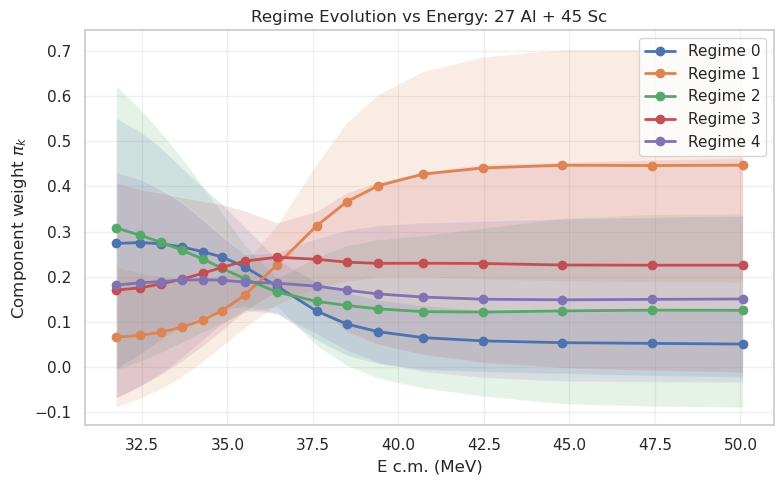

In [8]:
# ========================================================================
# PLOT: MDN REGIME EVOLUTION FOR A SINGLE REACTION
# ========================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FIX 1: Corrected spacing
reaction_name = "27 Al + 45 Sc"    # <<---- CHANGE THIS TO ANY REACTION

# Load scaler
scaler = joblib.load(os.path.join(EN_DIR, "scaler.pkl"))

# Select reaction rows
rows_R = df[df["Reaction"] == reaction_name].copy()
rows_R = rows_R.sort_values("E c.m.").reset_index(drop=True)

X_R = rows_R[features_train].values.astype(np.float32)
E_R = rows_R["E c.m."].values

# Scale input
X_Rs = scaler.transform(X_R)

# Load all seed π values
# FIX 2: Corrected spacing
pi_all = []    # list of (n_points, n_components)

for s in SEEDS:
    path = f"{EN_DIR}/seed_{s}/mdn_all_components.npz"
    if not os.path.exists(path):
        continue
    data = np.load(path)
    # FIX 3: Corrected spacing
    pi = data["pi"]       # shape (full_dataset, n_components)

    # Extract rows for this reaction
    idx = df[df["Reaction"] == reaction_name].index
    pi_R = pi[idx]        # shape (n_points, n_components)
    pi_all.append(pi_R)

# FIX 4: Corrected spacing
pi_all = np.stack(pi_all, axis=0)    # (n_seeds, n_points, n_components)
pi_mean = pi_all.mean(axis=0)
# FIX 5: Corrected spacing
pi_std  = pi_all.std(axis=0)

# ------------------------------------------------------------------------
# PLOT: $\\pi_k(E)$ Curve
# ------------------------------------------------------------------------
plt.figure(figsize=(8,5))

for k in range(N_COMPONENTS):
    plt.plot(E_R, pi_mean[:,k], marker='o', linewidth=2, label=f"Regime {k}")
    plt.fill_between(E_R,
                     pi_mean[:,k]-pi_std[:,k],
                     pi_mean[:,k]+pi_std[:,k],
                     alpha=0.15)

plt.xlabel("E c.m. (MeV)")
# Using LaTeX for $\\pi_k$ for correct rendering in Matplotlib
plt.ylabel("Component weight $\\pi_k$")
plt.title(f"Regime Evolution vs Energy: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# MODIFICATION: Save the figure as a 1000 dpi PNG file
filename = f"regime_evolution_{reaction_name.replace(' ', '_').replace('+', 'plus')}.png"
plt.savefig(filename, dpi=1000)

plt.show()

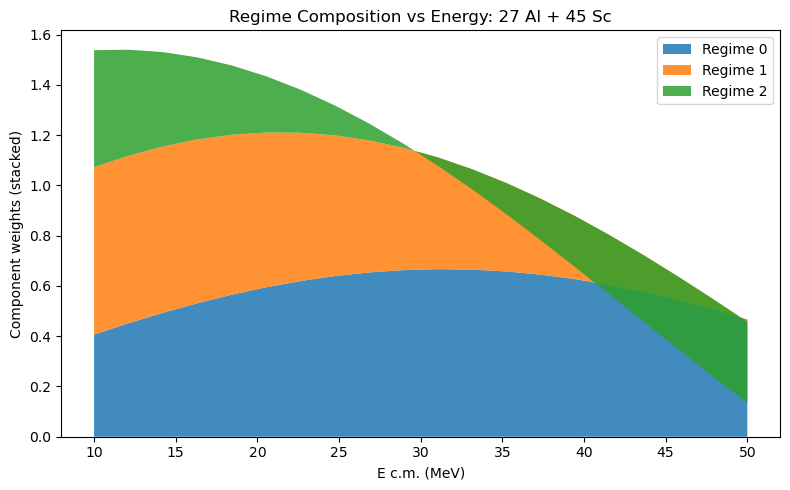

In [12]:
plt.figure(figsize=(8,5))
plt.stackplot(E_R, pi_mean.T, labels=[f"Regime {k}" for k in range(N_COMPONENTS)],
              alpha=0.85)
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weights (stacked)")
plt.title(f"Regime Composition vs Energy: {reaction_name}")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


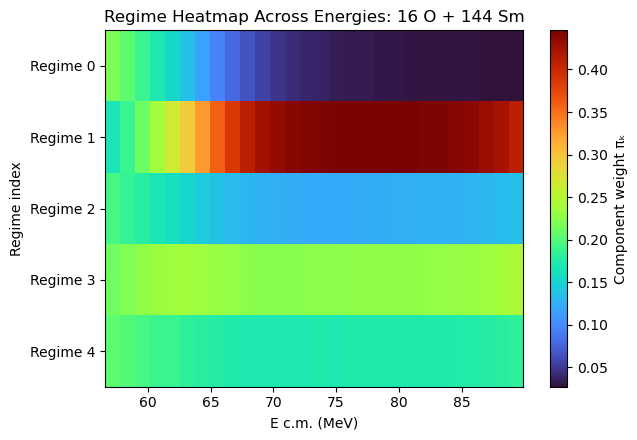

In [8]:
plt.figure(figsize=(6.5,4.5))
plt.imshow(pi_mean.T, aspect="auto", cmap="turbo",
           extent=[E_R.min(), E_R.max(), N_COMPONENTS-0.5, -0.5])

plt.colorbar(label="Component weight πₖ")
plt.yticks(range(N_COMPONENTS), [f"Regime {k}" for k in range(N_COMPONENTS)])
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Regime index")
plt.title(f"Regime Heatmap Across Energies: {reaction_name}")
plt.tight_layout()
plt.show()


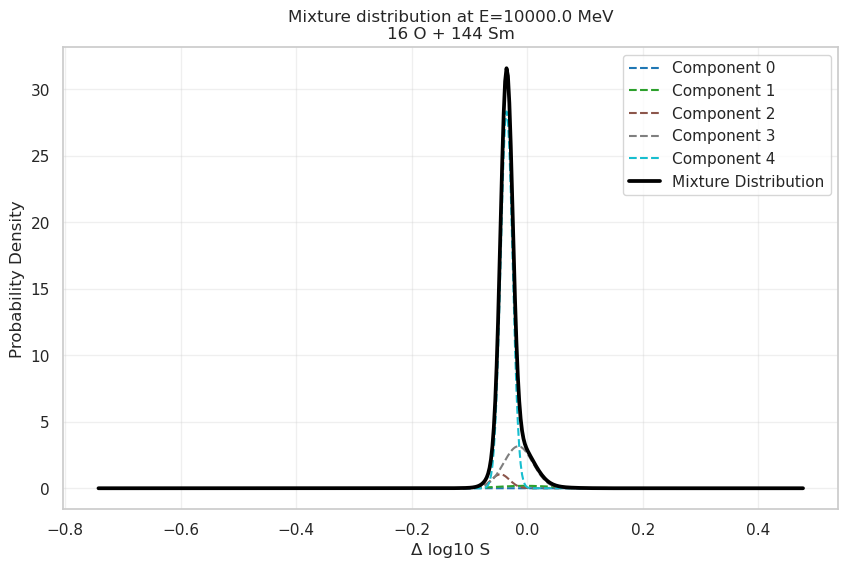

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

# -----------------------------
# USER INPUT
# -----------------------------
reaction_name = "16 O + 144 Sm"
Ecm_value = 10000.0
OUTDIR = "mdn_70_10_20_optimized"
SEED = 42

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# -----------------------------
# PHYSICS FEATURE REBUILD (same as training)
# -----------------------------
M_p = 938.272088
M_n = 939.565420
LN10 = np.log(10.0)
epsilon = 1e-30

def mass(Z,A): return Z*M_p + (A-Z)*M_n

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]

df["mass1"] = mass(df["Z1"], df["A1"])
df["mass2"] = mass(df["Z2"], df["A2"])

mu_red = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)

v_over_c = np.sqrt(np.clip(2*df["E c.m."].values / (mu_red + epsilon), 0, np.inf))
df["eta"] = (df["Z1"] * df["Z2"]) / ((1/137.036) * (v_over_c+1e-16))

df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
df["magic_dist_Z1"] = np.min(np.abs(df["Z1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N1"] = np.min(np.abs(df["N1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_Z2"] = np.min(np.abs(df["Z2"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N2"] = np.min(np.abs(df["N2"].values[:,None] - MAGIC), axis=1)

# -----------------------------
# Feature list used in training
# -----------------------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm', 'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual','Target_Mass_Actual','Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# -----------------------------
# Find the closest energy row
# -----------------------------
df_r = df[df["Reaction"] == reaction_name].copy()
row = df_r.iloc[(df_r["E c.m."] - Ecm_value).abs().argmin()]
x = row[features_train].values.astype(np.float32).reshape(1,-1)

# -----------------------------
# Load scaler and scale inputs
# -----------------------------
scaler = joblib.load(f"{OUTDIR}/ensembles_fast/scaler.pkl")
x_s = scaler.transform(x)

# -----------------------------
# Load MDN mixture parameters
# -----------------------------
comp_file = f"{OUTDIR}/ensembles_fast/seed_{SEED}/mdn_all_components.npz"
comp = np.load(comp_file)

# locate correct index in full DF
idx = df.index[(df["Reaction"]==reaction_name) &
               ((df["E c.m."]-Ecm_value).abs() < 1e-6)]

if len(idx)==0:
    idx = df_r.index[(df_r["E c.m."]-Ecm_value).abs().argmin()]
else:
    idx = idx[0]

pi = comp["pi"][idx]
mu = comp["mu"][idx]
sigma = comp["sigma"][idx]

# -----------------------------
# Gaussian helper
# -----------------------------
def gaussian(x, m, s):
    return (1/(np.sqrt(2*np.pi)*s))*np.exp(-0.5*((x-m)/s)**2)

# -----------------------------
# Plot mixture distribution
# -----------------------------
xmin = mu.min() - 4*sigma.max()
xmax = mu.max() + 4*sigma.max()
xs = np.linspace(xmin, xmax, 500)

plt.figure(figsize=(10,6))
K = len(pi)
colors = plt.cm.tab10(np.linspace(0,1,K))

for k in range(K):
    ys = pi[k] * gaussian(xs, mu[k], sigma[k])
    plt.plot(xs, ys, "--", color=colors[k], label=f"Component {k}")

ys_mix = np.sum([pi[k]*gaussian(xs,mu[k],sigma[k]) for k in range(K)], axis=0)
plt.plot(xs, ys_mix, color="black", linewidth=2.7, label="Mixture Distribution")

plt.xlabel("Δ log10 S")
plt.ylabel("Probability Density")
plt.title(f"Mixture distribution at E={Ecm_value} MeV\n{reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



=== Plotting Regime Evolution for 16 O + 144 Sm ===
Figure saved to: regime_evolution_16O_144Sm.pdf

=== Regime Statistics ===
Component 0: 3.6% of points
  Energy range: 56.6 - 56.6 MeV
Component 3: 17.9% of points
  Energy range: 57.0 - 58.8 MeV
Component 4: 78.6% of points
  Energy range: 59.3 - 89.9 MeV


(<Figure size 1200x1200 with 4 Axes>,
 array([[0.38071403, 0.11416479, 0.12051877, 0.2803126 , 0.10428985],
        [0.29735005, 0.1156678 , 0.1284286 , 0.31863824, 0.13991535],
        [0.22023211, 0.11380802, 0.13264628, 0.35161978, 0.18169378],
        [0.15677501, 0.10790069, 0.13215151, 0.37472498, 0.22844782],
        [0.1082709 , 0.09913696, 0.12759855, 0.38678047, 0.27821308],
        [0.07550221, 0.0904887 , 0.12205916, 0.3817533 , 0.33019665],
        [0.05093637, 0.08074059, 0.11440203, 0.36682793, 0.3870931 ],
        [0.03408671, 0.07054377, 0.10554957, 0.34489796, 0.44492194],
        [0.02330423, 0.06143351, 0.09702947, 0.31974292, 0.4984899 ],
        [0.01637879, 0.0539741 , 0.08920091, 0.2942801 , 0.54616606],
        [0.0127408 , 0.04965732, 0.0839793 , 0.279411  , 0.5742116 ],
        [0.01027501, 0.04598006, 0.07899981, 0.27074003, 0.5940051 ],
        [0.00841263, 0.04274184, 0.07455299, 0.2625208 , 0.61177176],
        [0.00702137, 0.04000926, 0.07062623, 0.25547

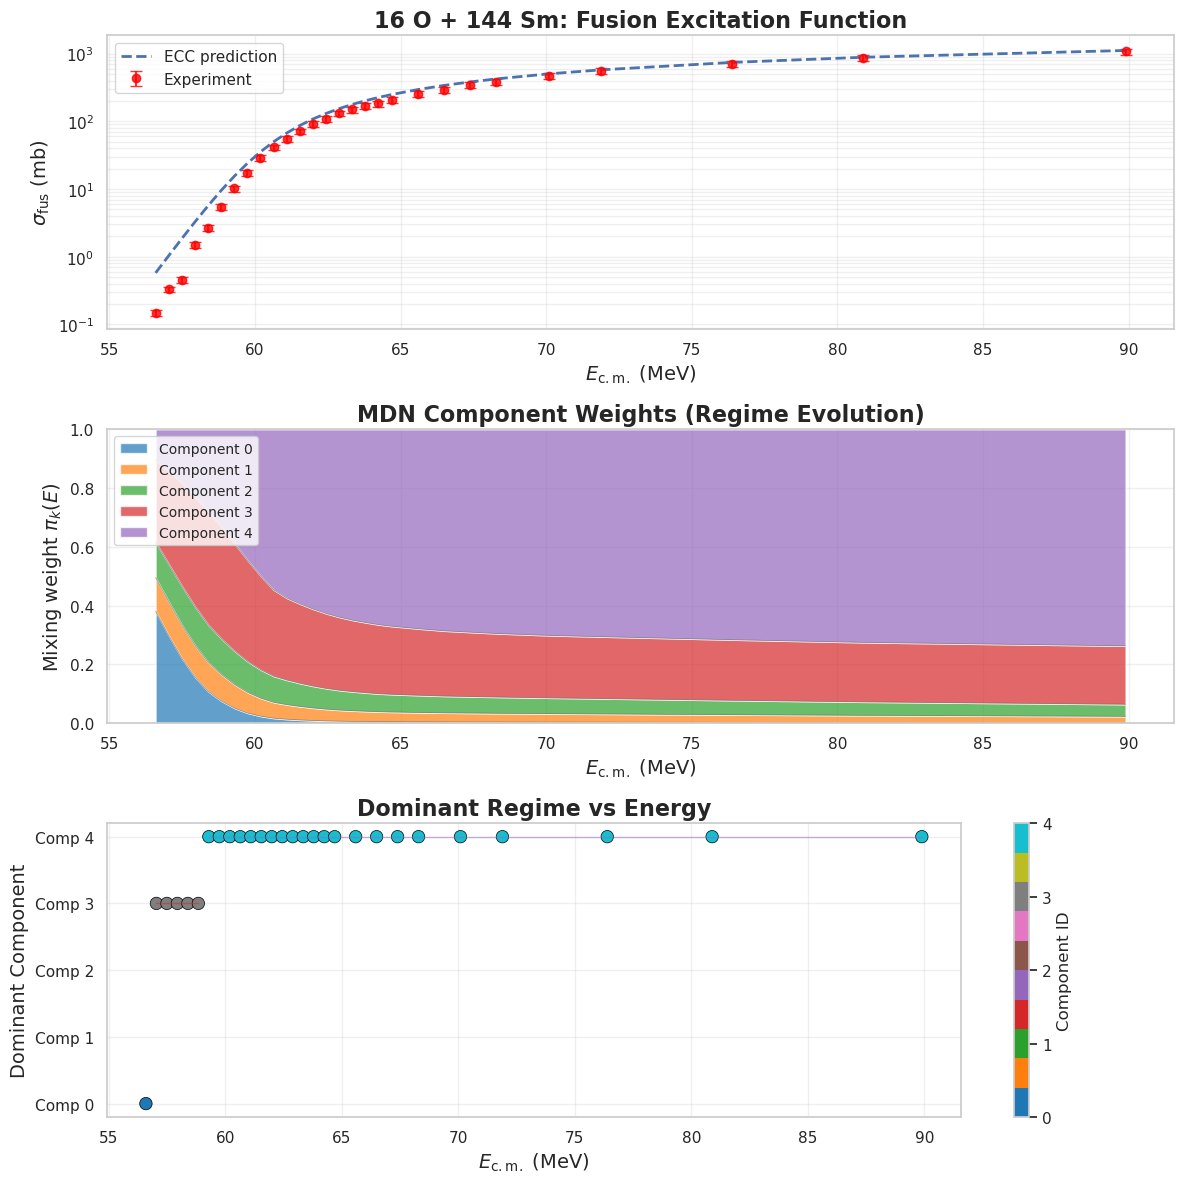

In [23]:
def plot_regime_evolution(reaction_name="16O+144Sm", save_path="regime_evolution.pdf"):
    """
    Shows component weight evolution π_k(E) for a single reaction.
    """
    print(f"\n=== Plotting Regime Evolution for {reaction_name} ===")
    
    # 1. Find reaction indices
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. Load one seed's predictions (seed 42 as representative)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    
    # Extract for this reaction
    pi_reaction = pi_all[reaction_indices]  # Shape: (n_points, 5)
    
    # 3. Get energies and experimental data
    energies = reaction_data["E c.m."].values
    sigma_exp = reaction_data["σ"].values
    sigma_cal = reaction_data["σ cal"].values
    
    # 4. Create figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Top: Experimental excitation function
    ax1 = axes[0]
    ax1.errorbar(energies, sigma_exp, yerr=sigma_exp * 0.1,  # 10% error for visualization
                fmt='o', color='red', capsize=4, label='Experiment', alpha=0.8)
    ax1.plot(energies, sigma_cal, 'b--', linewidth=2, label='ECC prediction')
    
    # Add MDN ensemble mean prediction (load from your ensemble predictions)
    # For now, we'll show experimental vs ECC
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax1.set_ylabel(r'$\sigma_{\mathrm{fus}}$ (mb)', fontsize=14)
    ax1.set_title(f'{reaction_name}: Fusion Excitation Function', 
                  fontsize=16, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(loc='best', fontsize=11)
    
    # Middle: Component weights as stacked area
    ax2 = axes[1]
    
    # Stack the component weights
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    component_labels = [f'Component {i}' for i in range(5)]
    
    # Stack plot
    ax2.stackplot(energies, pi_reaction.T, colors=colors, alpha=0.7)
    
    # Add component boundaries
    for i in range(4):
        ax2.plot(energies, np.sum(pi_reaction[:, :i+1], axis=1), 
                'k-', linewidth=0.5, alpha=0.5)
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax2.set_ylabel(r'Mixing weight $\pi_k(E)$', fontsize=14)
    ax2.set_title('MDN Component Weights (Regime Evolution)', 
                  fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                           label=f'Component {i}') for i in range(5)]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Bottom: Dominant component at each energy
    ax3 = axes[2]
    
    dominant_component = np.argmax(pi_reaction, axis=1)
    
    # Create a discrete colormap
    cmap = plt.cm.tab10
    scatter = ax3.scatter(energies, dominant_component, 
                         c=dominant_component, cmap=cmap, 
                         s=80, edgecolor='black', linewidth=0.5)
    
    # Add lines connecting points for same component
    for comp in range(5):
        comp_mask = dominant_component == comp
        if np.any(comp_mask):
            comp_energies = energies[comp_mask]
            comp_values = dominant_component[comp_mask]
            ax3.plot(comp_energies, comp_values, '-', color=cmap(comp/10),
                    alpha=0.5, linewidth=1)
    
    ax3.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax3.set_ylabel('Dominant Component', fontsize=14)
    ax3.set_title('Dominant Regime vs Energy', fontsize=16, fontweight='bold')
    ax3.set_yticks(range(5))
    ax3.set_yticklabels([f'Comp {i}' for i in range(5)])
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, ticks=range(5))
    cbar.set_label('Component ID', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 5. Print regime statistics
    print("\n=== Regime Statistics ===")
    for comp in range(5):
        comp_fraction = np.mean(dominant_component == comp)
        if comp_fraction > 0:
            comp_energies = energies[dominant_component == comp]
            print(f"Component {comp}: {comp_fraction:.1%} of points")
            print(f"  Energy range: {comp_energies.min():.1f} - {comp_energies.max():.1f} MeV")
    
    return fig, pi_reaction

# Run the function
plot_regime_evolution(
    reaction_name="16 O + 144 Sm",
    save_path="regime_evolution_16O_144Sm.pdf"
)

In [24]:
from pathlib import Path
# Assuming all necessary imports (torch, numpy, matplotlib.pyplot, pandas, joblib, os) 
# and variables (df, EN_DIR, features_train, SEEDS, DEVICE) are defined.

def plot_components_at_energy(reaction_name="16 O + 144 Sm", target_E_cm=None, save_path="components_at_energy_clean.png"):
    """
    Visualize Gaussian mixture components at a specific energy for research-quality output.
    Focuses on the PDF, experimental point, and mean locations.
    Saves the figure at 1000 DPI.
    """
    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution (Assumes 5 components based on your code)
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians and Mixture
    individual_gaussians = []
    mixture_pdf = np.zeros_like(x_grid)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # Standard Matplotlib colors
    
    for k in range(5):
        # Calculate Gaussian PDF for component k
        gaussian_k = (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                     np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
        
        # Calculate weighted Gaussian and add to mixture
        weighted_gaussian = pi_point[k] * gaussian_k
        mixture_pdf += weighted_gaussian
        
        # Only store for plotting if weight is significant
        if pi_point[k] > 0.005: 
            individual_gaussians.append((k, weighted_gaussian))
    
    # 6. Create figure (Single subplot for cleaner look)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot individual Gaussians
    for (k, gaussian) in individual_gaussians:
        ax.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                alpha=0.6, label=f'Regime {k} ($\\pi$={pi_point[k]:.2f})')
        # Fill under each Gaussian for visual clarity
        ax.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.15)
        
        # Mark component means with a simple line
        ax.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                   alpha=0.4, linewidth=1)
            
    # Plot mixture distribution
    ax.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.9, 
            label='Mixture Distribution (PDF)')
    
    # Plot experimental value as vertical line
    ax.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
               label=f'Exp. $\\Delta\\log_{{10}}S = {delta_exp:.3f}$')
    
    # Finalize Plot Aesthetics
    ax.set_xlabel(r'$\Delta \log_{10} S$', fontsize=16)
    ax.set_ylabel('Probability Density Function (PDF)', fontsize=16)
    ax.set_title(f'MDN Regime PDF at $E_{{\\text{{c.m.}}}}$ = {actual_E:.1f} MeV: {reaction_name}',
                 fontsize=14, pad=10)
    
    # Ensure a clean legend and grid
    ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    # MODIFICATION: Save at 1000 DPI (as requested)
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    print(f"Figure saved to: {save_path} at 1000 dpi.")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis (Quantitative Output) ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental $\\Delta\\log_{{10}}S$: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: $\\pi$={pi_point[k]:.3f}, $\\mu$={mu_point[k]:.3f}, $\\sigma$={sigma_point[k]:.3f}")
        
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

In [25]:
# ========================================================================
# PLOT: MDN REGIME COMPONENTS (MINIMAL CHANGES, 1000 DPI PNG SAVE)
# ========================================================================
from pathlib import Path
# Assuming all necessary imports and variables are defined.

def plot_components_at_energy(reaction_name="16O+144Sm", target_E_cm=None, save_path=None):
    """
    Visualize Gaussian mixture components at a specific energy.
    Shows individual Gaussians, mixture distribution, and experimental point.
    """
    # Auto-generate PNG save path if not specified or still PDF
    if save_path is None or save_path.endswith(".pdf"):
        clean_name = reaction_name.strip().replace(" ", "_").replace("+", "plus")
        # Ensure target_E_cm is calculated/available if needed for filename
        # We will calculate it below, so for now, use a generic placeholder if target_E_cm is None
        energy_str = "median" if target_E_cm is None else f"{target_E_cm:.1f}"
        save_path = f"components_at_energy_{clean_name}_{energy_str}MeV.png"

    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    # NOTE: Correcting persistent U+00A0 non-breaking spaces on this line
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    
    # Update filename if target_E_cm was initially None
    if save_path.endswith("_medianMeV.png"):
        save_path = save_path.replace("_medianMeV.png", f"_{actual_E:.1f}MeV.png")
        
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians
    individual_gaussians = []
    for k in range(5):
        if pi_point[k] > 0.01:  # Only plot significant components
            gaussian = pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                         np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
            individual_gaussians.append((k, gaussian))
    
    # Mixture distribution
    mixture_pdf = np.zeros_like(x_grid)
    for k in range(5):
        mixture_pdf += pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                         np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
    
    # 6. Create figure: **Only one subplot needed now, adjusted figsize.**
    fig, ax1_top = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot individual Gaussians
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for (k, gaussian) in individual_gaussians:
        ax1_top.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                     alpha=0.6, label=f'Component {k} ($\\pi$={pi_point[k]:.2f})')
        
        # Fill under each Gaussian
        ax1_top.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.2)
    
    # Plot mixture distribution
    ax1_top.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.8, 
                 label='Mixture distribution')
    
    # Plot experimental value as vertical line
    ax1_top.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
                    label=f'Experimental $\\Delta\\log_{{10}}S = {delta_exp:.3f}$')
    
    # ------------------------------------------------------------------------
    # REMOVED CLUTTER: Mean/Variance Markers and Text
    # ------------------------------------------------------------------------
    for k in range(5):
        if pi_point[k] > 0.01:
            # Mark component means with simple vertical lines (kept this as it's often useful)
            ax1_top.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                            alpha=0.5, linewidth=1)
            # REMOVED: ax1_top.text(...) # Clutter: Text label for mean
    # ------------------------------------------------------------------------
    
    ax1_top.set_xlabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1_top.set_ylabel('Probability Density', fontsize=14)
    ax1_top.set_title(f'MDN Components at $E_{{\\text{{c.m.}}}}$ = {actual_E:.1f} MeV: {reaction_name}',
                      fontsize=16, fontweight='bold', pad=15)
    ax1_top.legend(loc='upper right', fontsize=10, framealpha=0.95)
    ax1_top.grid(True, alpha=0.3)
    ax1_top.set_ylim(bottom=0)
    
    # ------------------------------------------------------------------------
    # REMOVED CLUTTER: Large text box with component parameters
    # ------------------------------------------------------------------------
    # Removed: ax1_top.text(...) 
    # ------------------------------------------------------------------------
    
    # ------------------------------------------------------------------------
    # REMOVED CLUTTER: The entire second subplot (ax2_bottom)
    # ------------------------------------------------------------------------
    
    plt.tight_layout()
    
    # MODIFICATION: Save to PNG at 1000 DPI
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    print(f"Figure saved to: {save_path} at 1000 dpi.")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental $\\Delta\\log_{{10}}S$: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: $\\pi$={pi_point[k]:.3f}, $\\mu$={mu_point[k]:.3f}, $\\sigma$={sigma_point[k]:.3f}")
        
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

In [26]:
# Run the function
plot_components_at_energy(
    reaction_name="16 O + 144 Sm",
    target_E_cm=60.0,  # Change to your desired energy
    save_path="components_at_energy_16O_144Sm.pdf"
)


=== Plotting MDN Components for 16 O + 144 Sm ===
Target energy: 60.0 MeV, closest point: 60.2 MeV


KeyError: 'delta_log10_S'

In [27]:
def plot_components_at_energy(reaction_name="16O+144Sm", target_E_cm=None, save_path="components_at_energy.pdf"):
    """
    Visualize Gaussian mixture components at a specific energy.
    Shows individual Gaussians, mixture distribution, and experimental point.
    """
    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians
    individual_gaussians = []
    for k in range(5):
        if pi_point[k] > 0.01:  # Only plot significant components
            gaussian = pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
            individual_gaussians.append((k, gaussian))
    
    # Mixture distribution
    mixture_pdf = np.zeros_like(x_grid)
    for k in range(5):
        mixture_pdf += pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
    
    # 6. Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Top: Individual components and mixture
    ax1_top = ax1
    
    # Plot individual Gaussians
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for (k, gaussian) in individual_gaussians:
        ax1_top.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                    alpha=0.6, label=f'Component {k} (π={pi_point[k]:.2f})')
        
        # Fill under each Gaussian
        ax1_top.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.2)
    
    # Plot mixture distribution
    ax1_top.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.8, 
                label='Mixture distribution')
    
    # Plot experimental value as vertical line
    ax1_top.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
                   label=f'Experimental Δlog₁₀S = {delta_exp:.3f}')
    
    # Mark component means
    for k in range(5):
        if pi_point[k] > 0.01:
            ax1_top.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                           alpha=0.5, linewidth=1)
            # Add text label for mean
            ax1_top.text(mu_point[k], 0.05, f'μ_{k}={mu_point[k]:.2f}', 
                        rotation=90, fontsize=9, color=colors[k],
                        ha='right', va='bottom')
    
    ax1_top.set_xlabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1_top.set_ylabel('Probability Density', fontsize=14)
    ax1_top.set_title(f'MDN Components at E = {actual_E:.1f} MeV: {reaction_name}',
                     fontsize=16, fontweight='bold', pad=15)
    ax1_top.legend(loc='upper right', fontsize=10, framealpha=0.95)
    ax1_top.grid(True, alpha=0.3)
    ax1_top.set_ylim(bottom=0)
    
    # Add text box with component parameters
    textstr = '\n'.join([
        f'Component parameters:',
        f'Weight (π): [{", ".join([f"{p:.3f}" for p in pi_point])}]',
        f'Mean (μ):   [{", ".join([f"{m:.3f}" for m in mu_point])}]',
        f'Std (σ):    [{", ".join([f"{s:.3f}" for s in sigma_point])}]',
        f'Experimental: Δlog₁₀S = {delta_exp:.3f}'
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1_top.text(0.02, 0.98, textstr, transform=ax1_top.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
    
    # Bottom: Weight and uncertainty visualization
    ax2_bottom = ax2
    
    # Create bar plot for component weights
    x_pos = np.arange(5)
    bars = ax2_bottom.bar(x_pos, pi_point, color=colors, alpha=0.7, 
                         edgecolor='black', linewidth=1)
    
    # Add error bars for σ (width) - scaled for visualization
    scaled_sigma = sigma_point / np.max(sigma_point) * 0.8
    ax2_bottom.errorbar(x_pos, pi_point, yerr=scaled_sigma, fmt='none',
                       ecolor='black', capsize=5, capthick=1.5, alpha=0.7,
                       label='Relative σ (scaled)')
    
    # Annotate bars with exact values
    for i, (pi_val, mu_val, sigma_val) in enumerate(zip(pi_point, mu_point, sigma_point)):
        if pi_val > 0.01:
            ax2_bottom.text(i, pi_val + 0.02, f'π={pi_val:.2f}\nμ={mu_val:.2f}\nσ={sigma_val:.2f}',
                           ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax2_bottom.set_xlabel('Component ID', fontsize=14)
    ax2_bottom.set_ylabel('Mixing weight π', fontsize=14)
    ax2_bottom.set_title('Component Parameters at This Energy',
                        fontsize=16, fontweight='bold', pad=15)
    ax2_bottom.set_xticks(x_pos)
    ax2_bottom.set_xticklabels([f'Comp {i}' for i in range(5)])
    ax2_bottom.legend(loc='upper right', fontsize=10)
    ax2_bottom.grid(True, alpha=0.3, axis='y')
    ax2_bottom.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental Δlog₁₀S: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: π={pi_point[k]:.3f}, μ={mu_point[k]:.3f}, σ={sigma_point[k]:.3f}")
    
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

# Run the function
plot_components_at_energy(
    reaction_name="16 O + 144 Sm",
    target_E_cm=60.0,  # Change to your desired energy
    save_path="components_at_energy_16O_144Sm.pdf"
)


=== Plotting MDN Components for 16 O + 144 Sm ===
Target energy: 60.0 MeV, closest point: 60.2 MeV


KeyError: 'delta_log10_S'


=== Plotting Regime Evolution for 16 O + 144 Sm ===
Figure saved to: regime_evolution_16O_144Sm.pdf

=== Regime Statistics ===
Component 0: 3.6% of points
  Energy range: 56.6 - 56.6 MeV
Component 3: 17.9% of points
  Energy range: 57.0 - 58.8 MeV
Component 4: 78.6% of points
  Energy range: 59.3 - 89.9 MeV


(<Figure size 1200x1200 with 4 Axes>,
 array([[0.38071403, 0.11416479, 0.12051877, 0.2803126 , 0.10428985],
        [0.29735005, 0.1156678 , 0.1284286 , 0.31863824, 0.13991535],
        [0.22023211, 0.11380802, 0.13264628, 0.35161978, 0.18169378],
        [0.15677501, 0.10790069, 0.13215151, 0.37472498, 0.22844782],
        [0.1082709 , 0.09913696, 0.12759855, 0.38678047, 0.27821308],
        [0.07550221, 0.0904887 , 0.12205916, 0.3817533 , 0.33019665],
        [0.05093637, 0.08074059, 0.11440203, 0.36682793, 0.3870931 ],
        [0.03408671, 0.07054377, 0.10554957, 0.34489796, 0.44492194],
        [0.02330423, 0.06143351, 0.09702947, 0.31974292, 0.4984899 ],
        [0.01637879, 0.0539741 , 0.08920091, 0.2942801 , 0.54616606],
        [0.0127408 , 0.04965732, 0.0839793 , 0.279411  , 0.5742116 ],
        [0.01027501, 0.04598006, 0.07899981, 0.27074003, 0.5940051 ],
        [0.00841263, 0.04274184, 0.07455299, 0.2625208 , 0.61177176],
        [0.00702137, 0.04000926, 0.07062623, 0.25547

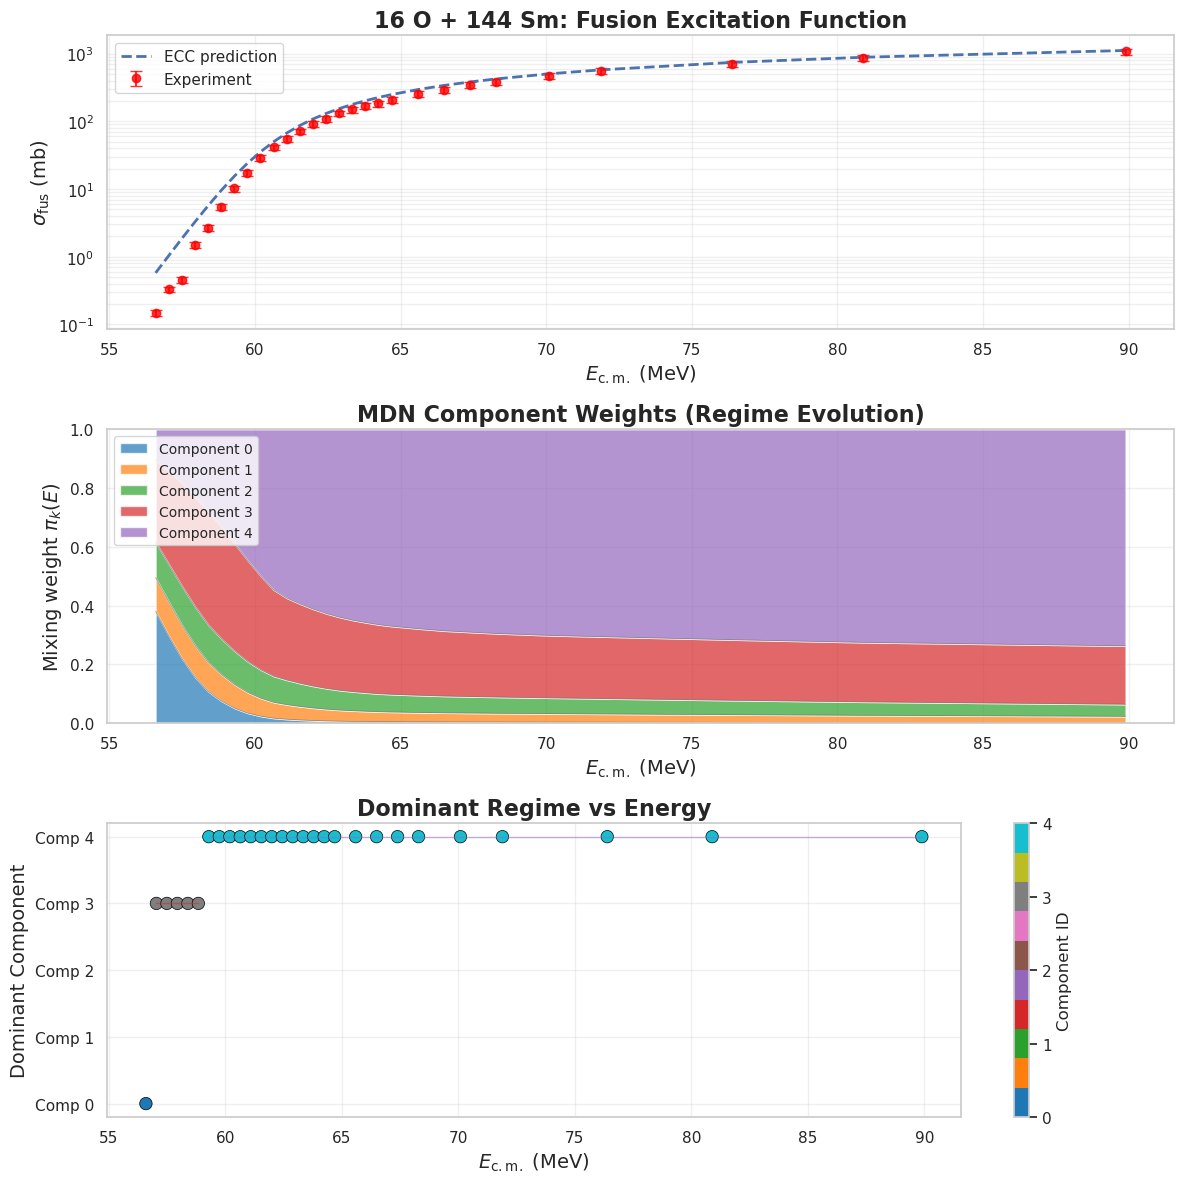

In [28]:
def plot_regime_evolution(reaction_name="16O+144Sm", save_path="regime_evolution.pdf"):
    """
    Shows component weight evolution π_k(E) for a single reaction.
    """
    print(f"\n=== Plotting Regime Evolution for {reaction_name} ===")
    
    # 1. Find reaction indices
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. Load one seed's predictions (seed 42 as representative)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    
    # Extract for this reaction
    pi_reaction = pi_all[reaction_indices]  # Shape: (n_points, 5)
    
    # 3. Get energies and experimental data
    energies = reaction_data["E c.m."].values
    sigma_exp = reaction_data["σ"].values
    sigma_cal = reaction_data["σ cal"].values
    
    # 4. Create figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Top: Experimental excitation function
    ax1 = axes[0]
    ax1.errorbar(energies, sigma_exp, yerr=sigma_exp * 0.1,  # 10% error for visualization
                fmt='o', color='red', capsize=4, label='Experiment', alpha=0.8)
    ax1.plot(energies, sigma_cal, 'b--', linewidth=2, label='ECC prediction')
    
    # Add MDN ensemble mean prediction (load from your ensemble predictions)
    # For now, we'll show experimental vs ECC
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax1.set_ylabel(r'$\sigma_{\mathrm{fus}}$ (mb)', fontsize=14)
    ax1.set_title(f'{reaction_name}: Fusion Excitation Function', 
                  fontsize=16, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(loc='best', fontsize=11)
    
    # Middle: Component weights as stacked area
    ax2 = axes[1]
    
    # Stack the component weights
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    component_labels = [f'Component {i}' for i in range(5)]
    
    # Stack plot
    ax2.stackplot(energies, pi_reaction.T, colors=colors, alpha=0.7)
    
    # Add component boundaries
    for i in range(4):
        ax2.plot(energies, np.sum(pi_reaction[:, :i+1], axis=1), 
                'k-', linewidth=0.5, alpha=0.5)
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax2.set_ylabel(r'Mixing weight $\pi_k(E)$', fontsize=14)
    ax2.set_title('MDN Component Weights (Regime Evolution)', 
                  fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                           label=f'Component {i}') for i in range(5)]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Bottom: Dominant component at each energy
    ax3 = axes[2]
    
    dominant_component = np.argmax(pi_reaction, axis=1)
    
    # Create a discrete colormap
    cmap = plt.cm.tab10
    scatter = ax3.scatter(energies, dominant_component, 
                         c=dominant_component, cmap=cmap, 
                         s=80, edgecolor='black', linewidth=0.5)
    
    # Add lines connecting points for same component
    for comp in range(5):
        comp_mask = dominant_component == comp
        if np.any(comp_mask):
            comp_energies = energies[comp_mask]
            comp_values = dominant_component[comp_mask]
            ax3.plot(comp_energies, comp_values, '-', color=cmap(comp/10),
                    alpha=0.5, linewidth=1)
    
    ax3.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax3.set_ylabel('Dominant Component', fontsize=14)
    ax3.set_title('Dominant Regime vs Energy', fontsize=16, fontweight='bold')
    ax3.set_yticks(range(5))
    ax3.set_yticklabels([f'Comp {i}' for i in range(5)])
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, ticks=range(5))
    cbar.set_label('Component ID', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 5. Print regime statistics
    print("\n=== Regime Statistics ===")
    for comp in range(5):
        comp_fraction = np.mean(dominant_component == comp)
        if comp_fraction > 0:
            comp_energies = energies[dominant_component == comp]
            print(f"Component {comp}: {comp_fraction:.1%} of points")
            print(f"  Energy range: {comp_energies.min():.1f} - {comp_energies.max():.1f} MeV")
    
    return fig, pi_reaction

# Run the function
plot_regime_evolution(
    reaction_name="16 O + 144 Sm",
    save_path="regime_evolution_16O_144Sm.pdf"
)

First 5 reactions in dataset: <ArrowStringArray>
[  '12 C + 89 Y',  '12 C + 92 Zr', '12 C + 144 Sm', '12 C + 152 Sm',
 '12 C + 154 Sm']
Length: 5, dtype: str

=== Plotting Uncertainty Decomposition for 16 O + 144 Sm ===
Found 28 points for 16 O + 144 Sm
Energies (MeV): [56.59 57.04 57.49 57.94 58.39 58.84 59.29 59.74 60.19 60.64 61.09 61.54
 61.99 62.44 62.89 63.34 63.79 64.24 64.69 65.59 66.49 67.39 68.29 70.09
 71.89 76.39 80.89 89.89]
Loading predictions from 10 seeds...
  Seed 42: extracted 28 points
  Seed 43: extracted 28 points
  Seed 44: extracted 28 points
  Seed 45: extracted 28 points
  Seed 46: extracted 28 points
  Seed 47: extracted 28 points
  Seed 48: extracted 28 points
  Seed 49: extracted 28 points
  Seed 50: extracted 28 points
  Seed 51: extracted 28 points
Figure saved to: uncertainty_decomposition_16O_144Sm.pdf

=== Uncertainty Statistics ===
Aleatoric uncertainty (mean): 0.0854
Epistemic uncertainty (mean): 0.0137
Total uncertainty (mean): 0.0865
Epistemic fract

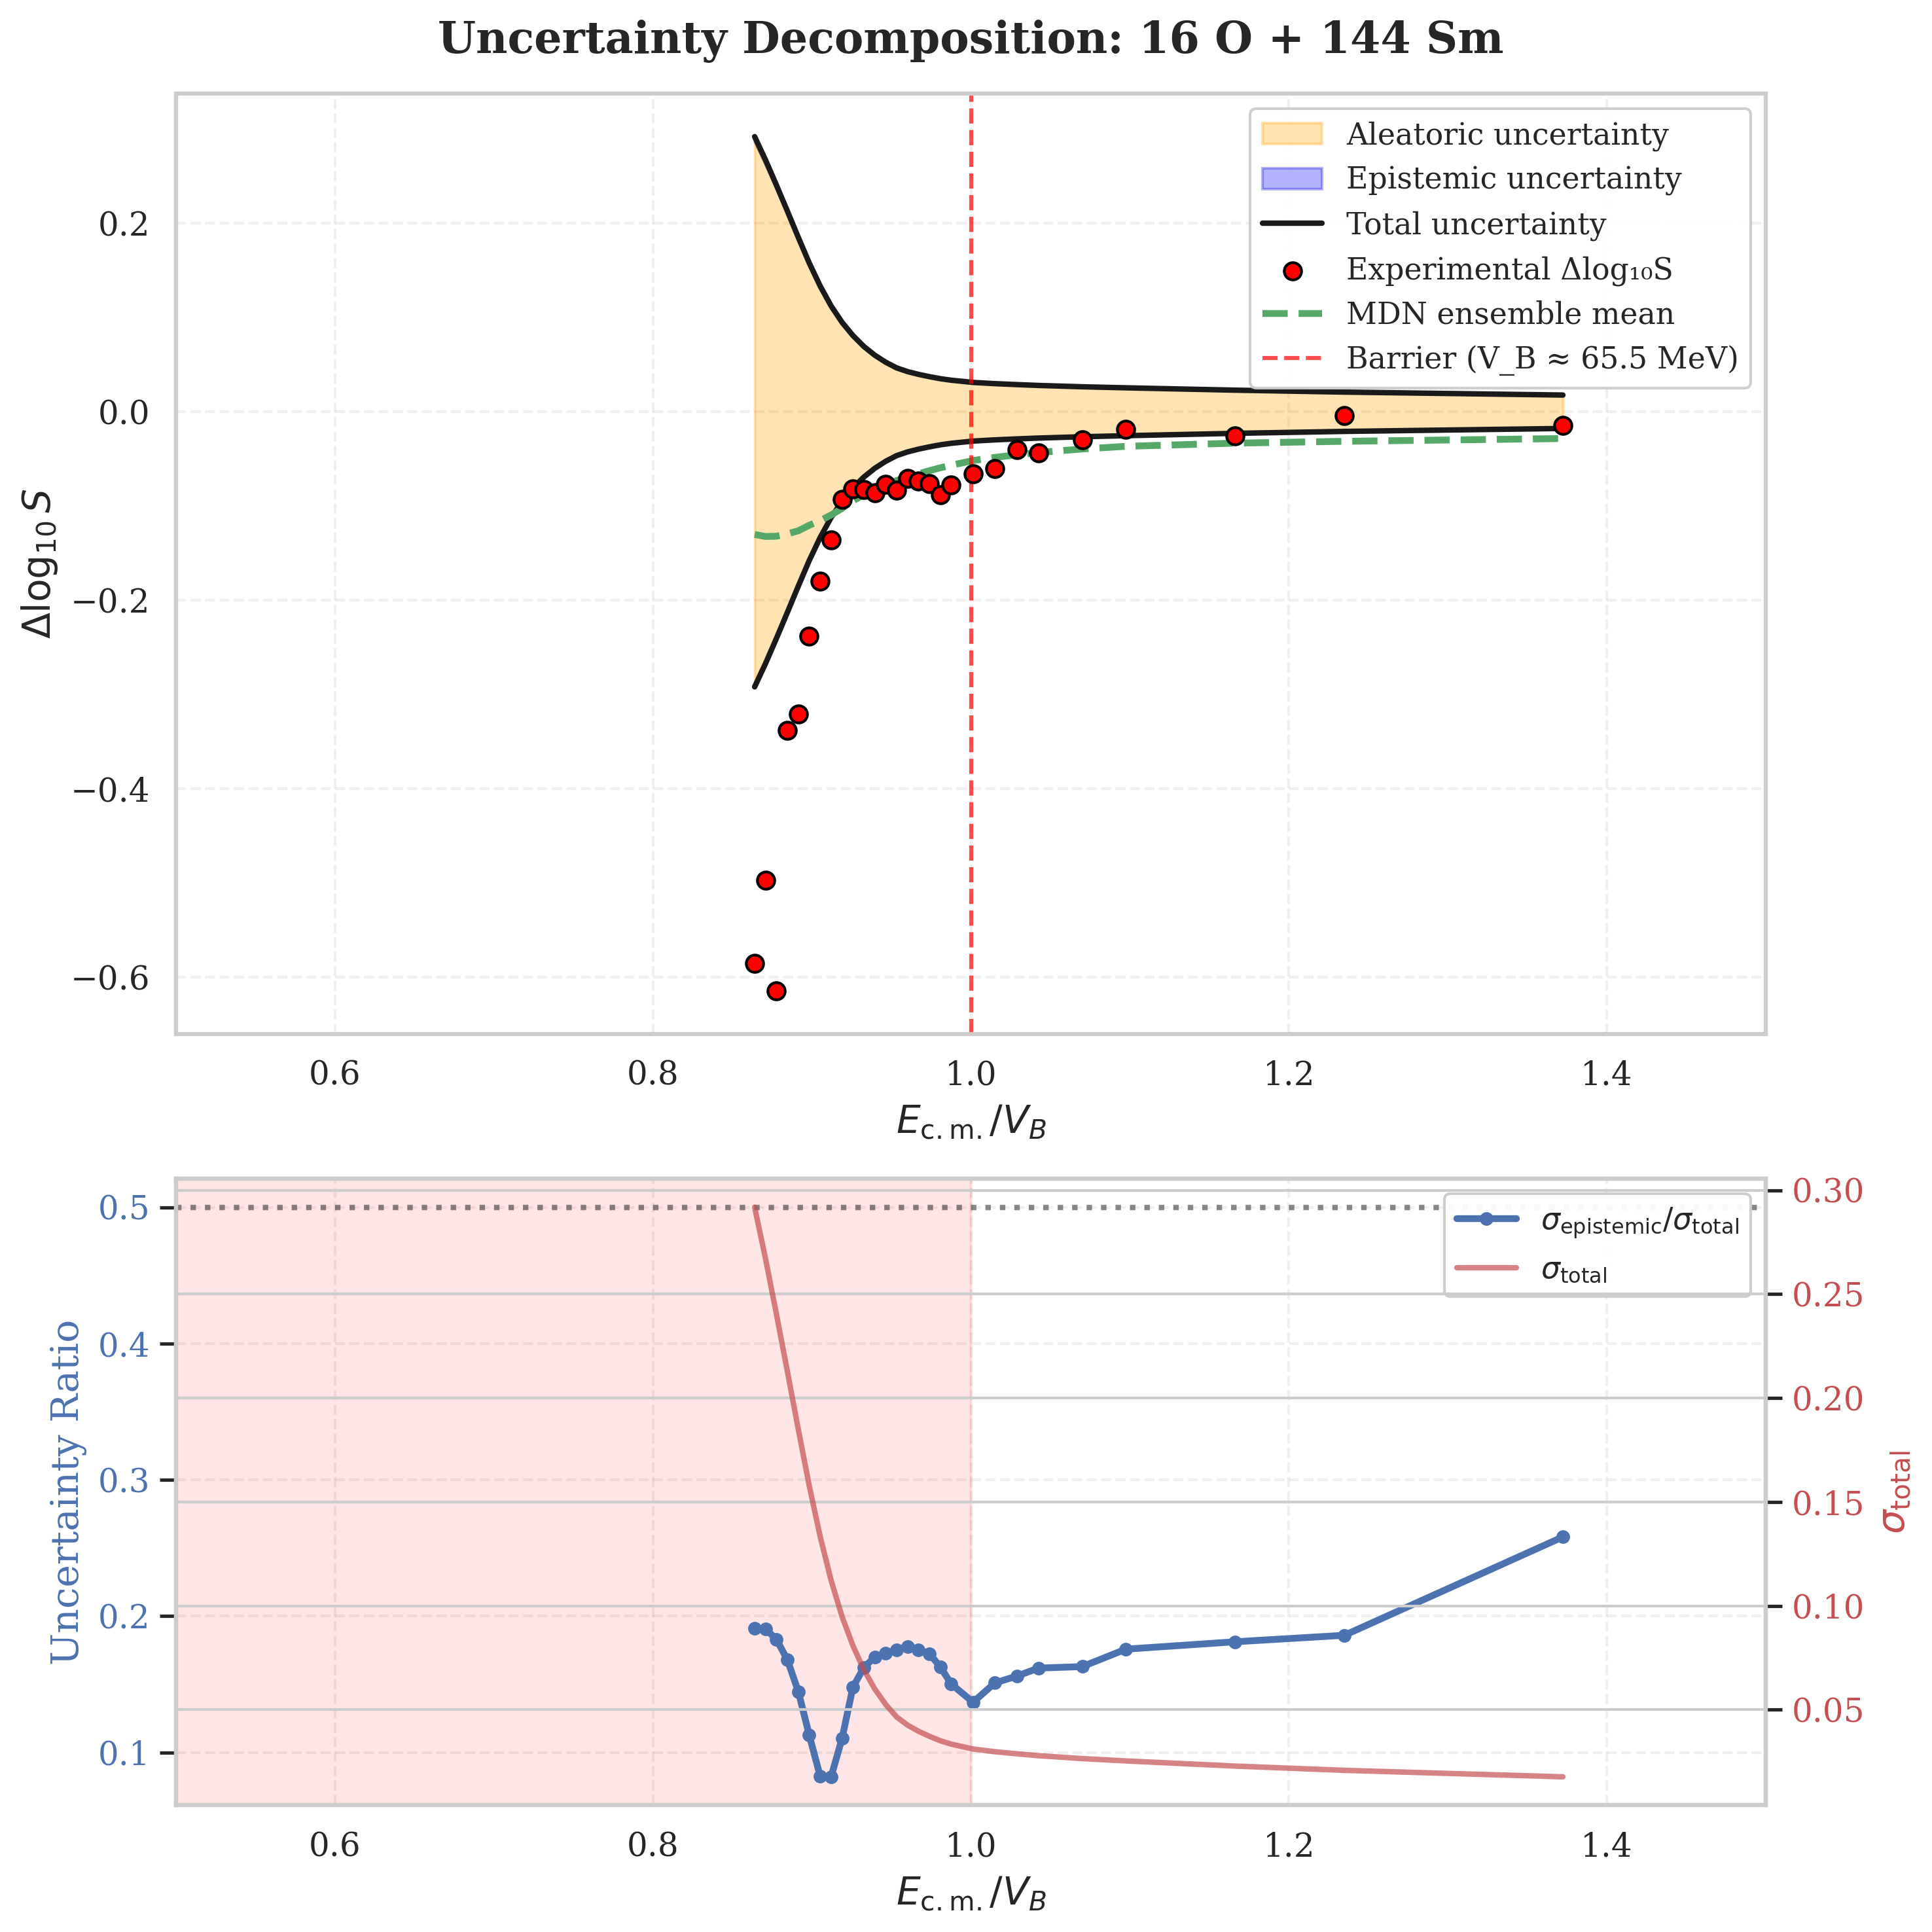

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import gaussian_kde

# Set publication-quality style
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Load your data (same as in your training code)
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# Recompute features (same as your training code)
M_p = 938.272088; M_n = 939.565420; epsilon = 1e-30; LN10 = np.log(10.0)

def get_nucleon_mass(Z, A): 
    return Z * M_p + (A - Z) * M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

def plot_uncertainty_decomposition(reaction_name="16O+144Sm", save_path="uncertainty_decomposition.pdf"):
    """
    PROPER uncertainty decomposition using your actual MDN ensemble.
    Aleatoric = sqrt(mean over seeds [ sum_k π_k σ_k² ])
    Epistemic = std over seeds of mixture mean predictions
    
    Based on: Kendall & Gal (2017) "What uncertainties do we need in Bayesian deep learning..."
    """
    print(f"\n=== Plotting Uncertainty Decomposition for {reaction_name} ===")
    
    # 1. Find indices for this reaction
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy()
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found in dataset.")
        return
    
    # Sort by energy
    reaction_data = reaction_data.sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    print(f"Found {len(reaction_data)} points for {reaction_name}")
    print("Energies (MeV):", reaction_data["E c.m."].values)
    
    # 2. Load predictions from all seeds
    outdir = Path("mdn_70_10_20_optimized")
    en_dir = outdir / "ensembles_fast"
    
    n_seeds = 10
    n_points = len(reaction_data)
    n_components = 5
    
    # Arrays to store predictions from each seed
    all_pi = np.zeros((n_seeds, n_points, n_components))      # Mixing weights
    all_mu = np.zeros((n_seeds, n_points, n_components))      # Component means
    all_sigma = np.zeros((n_seeds, n_points, n_components))   # Component std devs
    
    print(f"Loading predictions from {n_seeds} seeds...")
    
    for seed_idx, seed in enumerate(range(42, 42 + n_seeds)):
        seed_file = en_dir / f"seed_{seed}" / "mdn_all_components.npz"
        
        if not seed_file.exists():
            print(f"Warning: File not found: {seed_file}")
            continue
            
        # Load this seed's predictions for ALL data
        seed_data = np.load(seed_file)
        pi_all = seed_data["pi"]      # Shape: (n_total, 5)
        mu_all = seed_data["mu"]      # Shape: (n_total, 5)
        sigma_all = seed_data["sigma"] # Shape: (n_total, 5)
        
        # Extract predictions for this specific reaction
        all_pi[seed_idx] = pi_all[reaction_indices]
        all_mu[seed_idx] = mu_all[reaction_indices]
        all_sigma[seed_idx] = sigma_all[reaction_indices]
        
        print(f"  Seed {seed}: extracted {len(reaction_indices)} points")
    
    # 3. Compute mixture mean prediction for each seed
    # μ_mixture = Σ_k π_k μ_k
    mixture_means = np.zeros((n_seeds, n_points))
    for s in range(n_seeds):
        mixture_means[s] = np.sum(all_pi[s] * all_mu[s], axis=1)
    
    # 4. Compute uncertainties (Kendall & Gal 2017)
    # Aleatoric uncertainty: σ_aleatoric² = mean_seeds[ Σ_k π_k σ_k² ]
    aleatoric_sq = np.zeros(n_points)
    for i in range(n_points):
        # For each point, average over seeds
        point_aleatoric = 0
        for s in range(n_seeds):
            # Σ_k π_{s,k}(x) σ_{s,k}²(x)
            point_aleatoric += np.sum(all_pi[s, i] * (all_sigma[s, i]**2))
        aleatoric_sq[i] = point_aleatoric / n_seeds
    
    aleatoric = np.sqrt(aleatoric_sq)
    
    # Epistemic uncertainty: σ_epistemic² = var_seeds[ μ_mixture(x) ]
    epistemic = np.std(mixture_means, axis=0)
    
    # Total uncertainty (approx): σ_total² ≈ σ_aleatoric² + σ_epistemic²
    total = np.sqrt(aleatoric_sq + epistemic**2)
    
    # 5. Get energies and experimental values
    energies = reaction_data["E c.m."].values
    delta_exp = reaction_data["delta_log10_S"].values
    
    # Estimate barrier position (you can replace with actual V_B if available)
    # Using: V_B ≈ 0.9 * Z1*Z2 / (R1 + R2) in MeV, approximate with max cross-section energy
    # For plotting, we'll use approximate barrier
    if "V_B" in reaction_data.columns:
        V_B = reaction_data["V_B"].iloc[0]
    else:
        # Approximate: barrier ~ energy where cross-section starts to rise
        V_B = np.percentile(energies, 70)
    
    E_norm = energies / V_B
    
    # 6. Create the plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), 
                            gridspec_kw={'height_ratios': [3, 2]})
    
    # Top panel: Uncertainty decomposition
    ax1 = axes[0]
    
    # Plot uncertainty bands
    ax1.fill_between(E_norm, -aleatoric, aleatoric, 
                     alpha=0.3, color='orange', label='Aleatoric uncertainty')
    ax1.fill_between(E_norm, aleatoric, total, 
                     alpha=0.3, color='blue', label='Epistemic uncertainty')
    
    # Plot total uncertainty boundary
    ax1.plot(E_norm, total, 'k-', linewidth=2, label='Total uncertainty')
    ax1.plot(E_norm, -total, 'k-', linewidth=2)
    
    # Plot experimental data points
    ax1.scatter(E_norm, delta_exp, color='red', s=40, zorder=5,
               edgecolor='black', linewidth=1, label='Experimental Δlog₁₀S')
    
    # Plot ensemble mean prediction
    ensemble_mean = np.mean(mixture_means, axis=0)
    ax1.plot(E_norm, ensemble_mean, 'g--', linewidth=2.5, 
             label='MDN ensemble mean')
    
    # Mark barrier position
    ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, linewidth=1.5,
                label=f'Barrier (V_B ≈ {V_B:.1f} MeV)')
    
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
    ax1.set_ylabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1.set_title(f'Uncertainty Decomposition: {reaction_name}', 
                  fontsize=16, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='best', framealpha=0.95, fontsize=11)
    ax1.set_xlim([0.5, 1.5])
    
    # Bottom panel: Uncertainty ratios and metrics
    ax2 = axes[1]
    
    # Compute epistemic fraction
    epistemic_fraction = epistemic / (total + 1e-10)
    
    # Plot epistemic fraction
    line1 = ax2.plot(E_norm, epistemic_fraction, 'b-', linewidth=2.5, 
                     marker='o', markersize=4, label=r'$\sigma_{\mathrm{epistemic}} / \sigma_{\mathrm{total}}$')
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
    ax2.set_ylabel('Uncertainty Ratio', fontsize=14, color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.axhline(y=0.5, color='k', linestyle=':', alpha=0.5, 
                label='Equal contributions')
    
    # Add second y-axis for absolute uncertainties
    ax2b = ax2.twinx()
    line2 = ax2b.plot(E_norm, total, 'r-', linewidth=2, alpha=0.7,
                      label=r'$\sigma_{\mathrm{total}}$')
    ax2b.set_ylabel(r'$\sigma_{\mathrm{total}}$', fontsize=14, color='r')
    ax2b.tick_params(axis='y', labelcolor='r')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper right', framealpha=0.95)
    
    # Shade sub-barrier region
    ax2.axvspan(0.5, 1.0, alpha=0.1, color='red', label='Sub-barrier region')
    
    ax2.set_xlim([0.5, 1.5])
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 7. Print quantitative summary
    print("\n=== Uncertainty Statistics ===")
    print(f"Aleatoric uncertainty (mean): {np.mean(aleatoric):.4f}")
    print(f"Epistemic uncertainty (mean): {np.mean(epistemic):.4f}")
    print(f"Total uncertainty (mean): {np.mean(total):.4f}")
    print(f"Epistemic fraction (sub-barrier): {np.mean(epistemic_fraction[E_norm < 1.0]):.3f}")
    print(f"Epistemic fraction (above-barrier): {np.mean(epistemic_fraction[E_norm >= 1.0]):.3f}")
    
    return fig, (aleatoric, epistemic, total, mixture_means)

# Run for your reaction
if __name__ == "__main__":
    # Example reactions from your dataset
    reactions_in_data = df["Reaction"].unique()[:5]
    print("First 5 reactions in dataset:", reactions_in_data)
    
    # Plot for a specific reaction
    plot_uncertainty_decomposition(
        reaction_name="16 O + 144 Sm",  # Change to your desired reaction
        save_path="uncertainty_decomposition_16O_144Sm.pdf"
    )


=== Generating Poster Plot for 16 O + 144 Sm ===


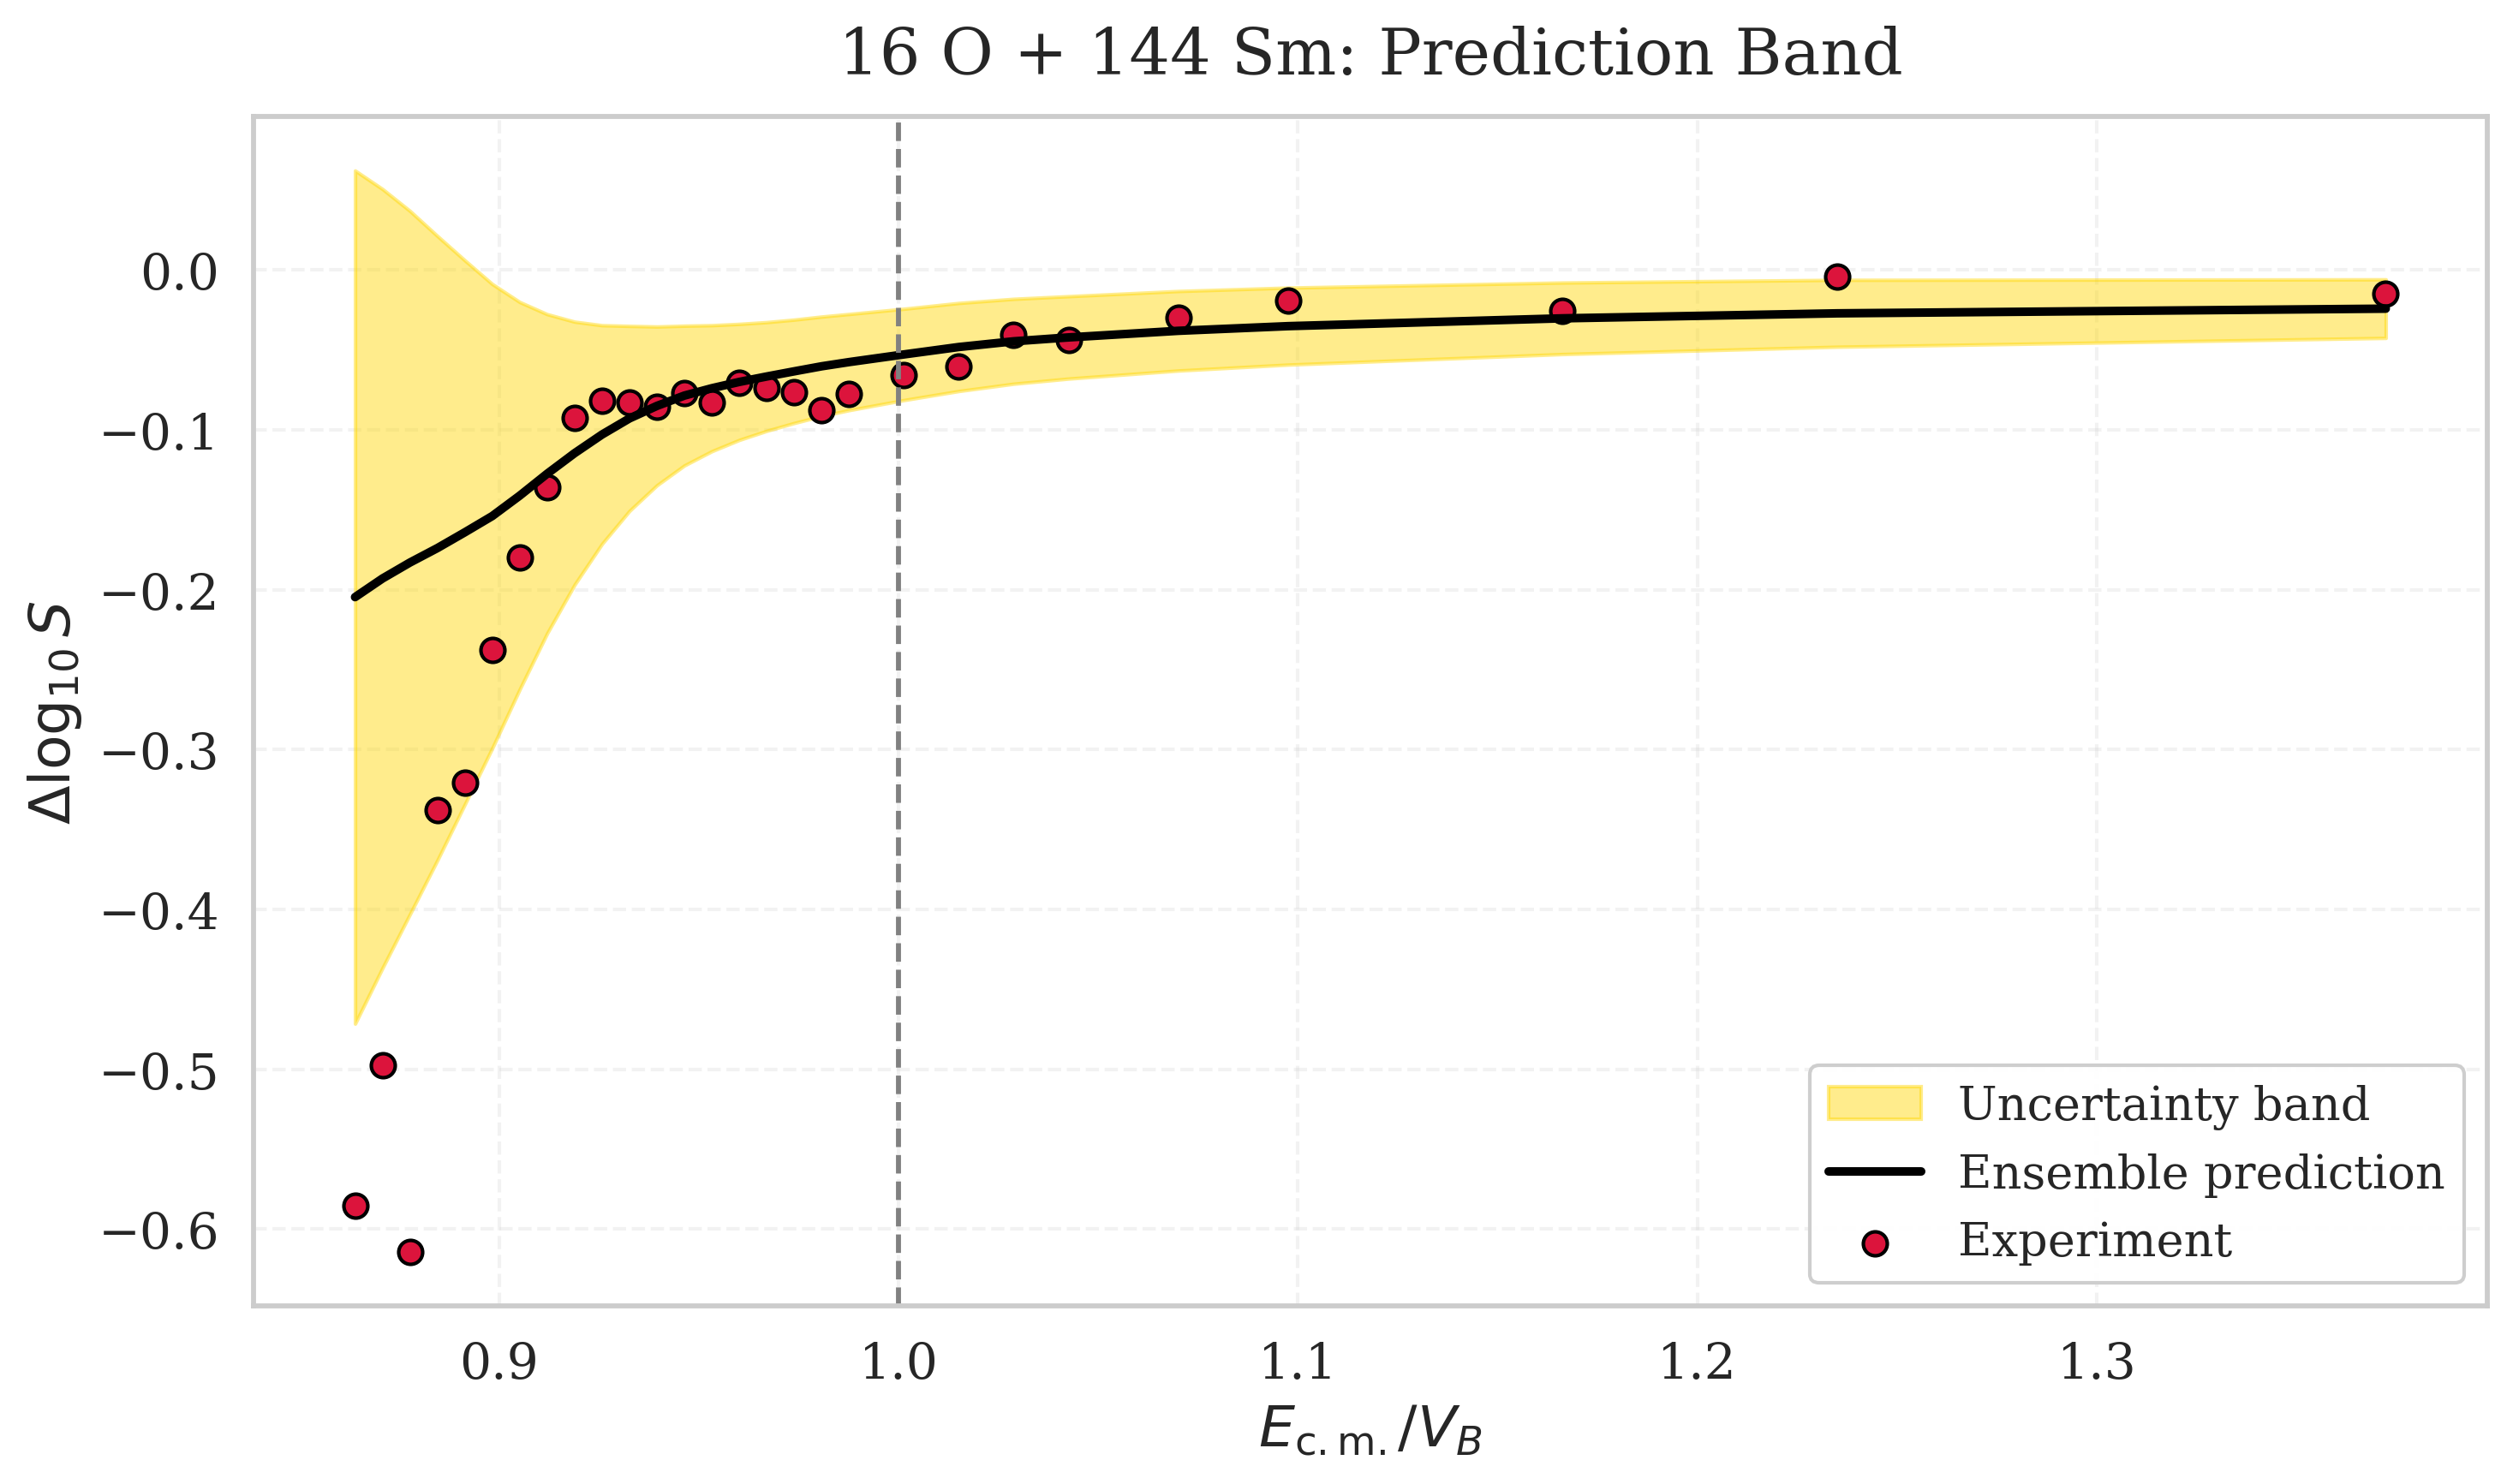

Saved: poster_prediction_band_16O_144Sm.png


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------
# Global plot style for conference poster
# ---------------------------------------
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'axes.linewidth': 1.4,
    'lines.linewidth': 2.2,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'figure.dpi': 300,
})


# --------------------------------------------------
# LOAD DATASET (same CSV used for training pipeline)
# --------------------------------------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)


# --------------------------------------------------
# RECOMPUTE ALL FEATURES NEEDED (same as training)
# --------------------------------------------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+epsilon), 0, np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]


# --------------------------------------------------
# FUNCTION: PLOT ONLY MEAN ± UNCERTAINTY BAND
# No MDN mentioned anywhere.
# --------------------------------------------------
def plot_poster_prediction_band(reaction_name, save_path):
    
    print(f"\n=== Generating Poster Plot for {reaction_name} ===")
    
    # Filter rows for the reaction
    data = df[df["Reaction"] == reaction_name].copy()
    if len(data) == 0:
        print("Reaction not found.")
        return
    
    # Sort by energy
    data = data.sort_values("E c.m.")
    idx = data.index.values
    energies = data["E c.m."].values
    delta_exp = data["delta_log10_S"].values

    # -----------------------------------------------
    # LOAD ALL SEEDS' COMPONENT OUTPUTS
    # -----------------------------------------------
    BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
    N_SEEDS = 10
    N_COMPONENTS = 5
    N = len(idx)

    all_pi = np.zeros((N_SEEDS, N, N_COMPONENTS))
    all_mu = np.zeros((N_SEEDS, N, N_COMPONENTS))
    all_sigma = np.zeros((N_SEEDS, N, N_COMPONENTS))

    for si, seed in enumerate(range(42, 42+N_SEEDS)):
        f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
        d = np.load(f)
        all_pi[si] = d["pi"][idx]
        all_mu[si] = d["mu"][idx]
        all_sigma[si] = d["sigma"][idx]

    # -----------------------------------------------
    # Mixture mean for each seed
    # -----------------------------------------------
    mixture_means = np.sum(all_pi * all_mu, axis=2)   # shape (seeds, N)

    # -----------------------------------------------
    # Proper Uncertainty Decomposition
    # -----------------------------------------------
    ale_sq = np.mean(np.sum(all_pi * (all_sigma**2), axis=2), axis=0)
    epistemic = np.std(mixture_means, axis=0)
    ale = np.sqrt(ale_sq)
    total = np.sqrt(ale_sq + epistemic**2)

    ensemble_mean = np.mean(mixture_means, axis=0)

    # Normalize x-axis by barrier approximation
    V_B = np.percentile(energies, 70)
    x = energies / V_B


    # -----------------------------------------------
    # MAKE POSTER-QUALITY FIGURE
    # -----------------------------------------------
    plt.figure(figsize=(10, 6))

    # Uncertainty band (total)
    plt.fill_between(x, 
                     ensemble_mean - total, 
                     ensemble_mean + total,
                     color="gold", alpha=0.45, label="Uncertainty band")

    # Ensemble mean curve (no MDN label!)
    plt.plot(x, ensemble_mean, color="black", linewidth=2.4, label="Ensemble prediction")

    # Experimental points
    plt.scatter(x, delta_exp, s=45, color="crimson",
                edgecolor="black", label="Experiment")

    plt.axvline(1.0, color='gray', linestyle='--', linewidth=1.4)

    plt.xlabel(r"$E_{\mathrm{c.m.}}/V_B$")
    plt.ylabel(r"$\Delta \log_{10} S$")
    plt.title(f"{reaction_name}: Prediction Band", pad=12)
    plt.grid(alpha=0.25, linestyle="--")
    plt.legend(framealpha=0.95)

    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    plt.show()

    print("Saved:", save_path)


# --------------------------------------------------
# RUN FOR YOUR REACTION
# --------------------------------------------------
plot_poster_prediction_band(
    "16 O + 144 Sm",
    "poster_prediction_band_16O_144Sm.png"
)



=== Hybrid Prediction-Band Plot for 16 O + 144 Sm ===
Saved: hybrid_prediction_band_fixed.png


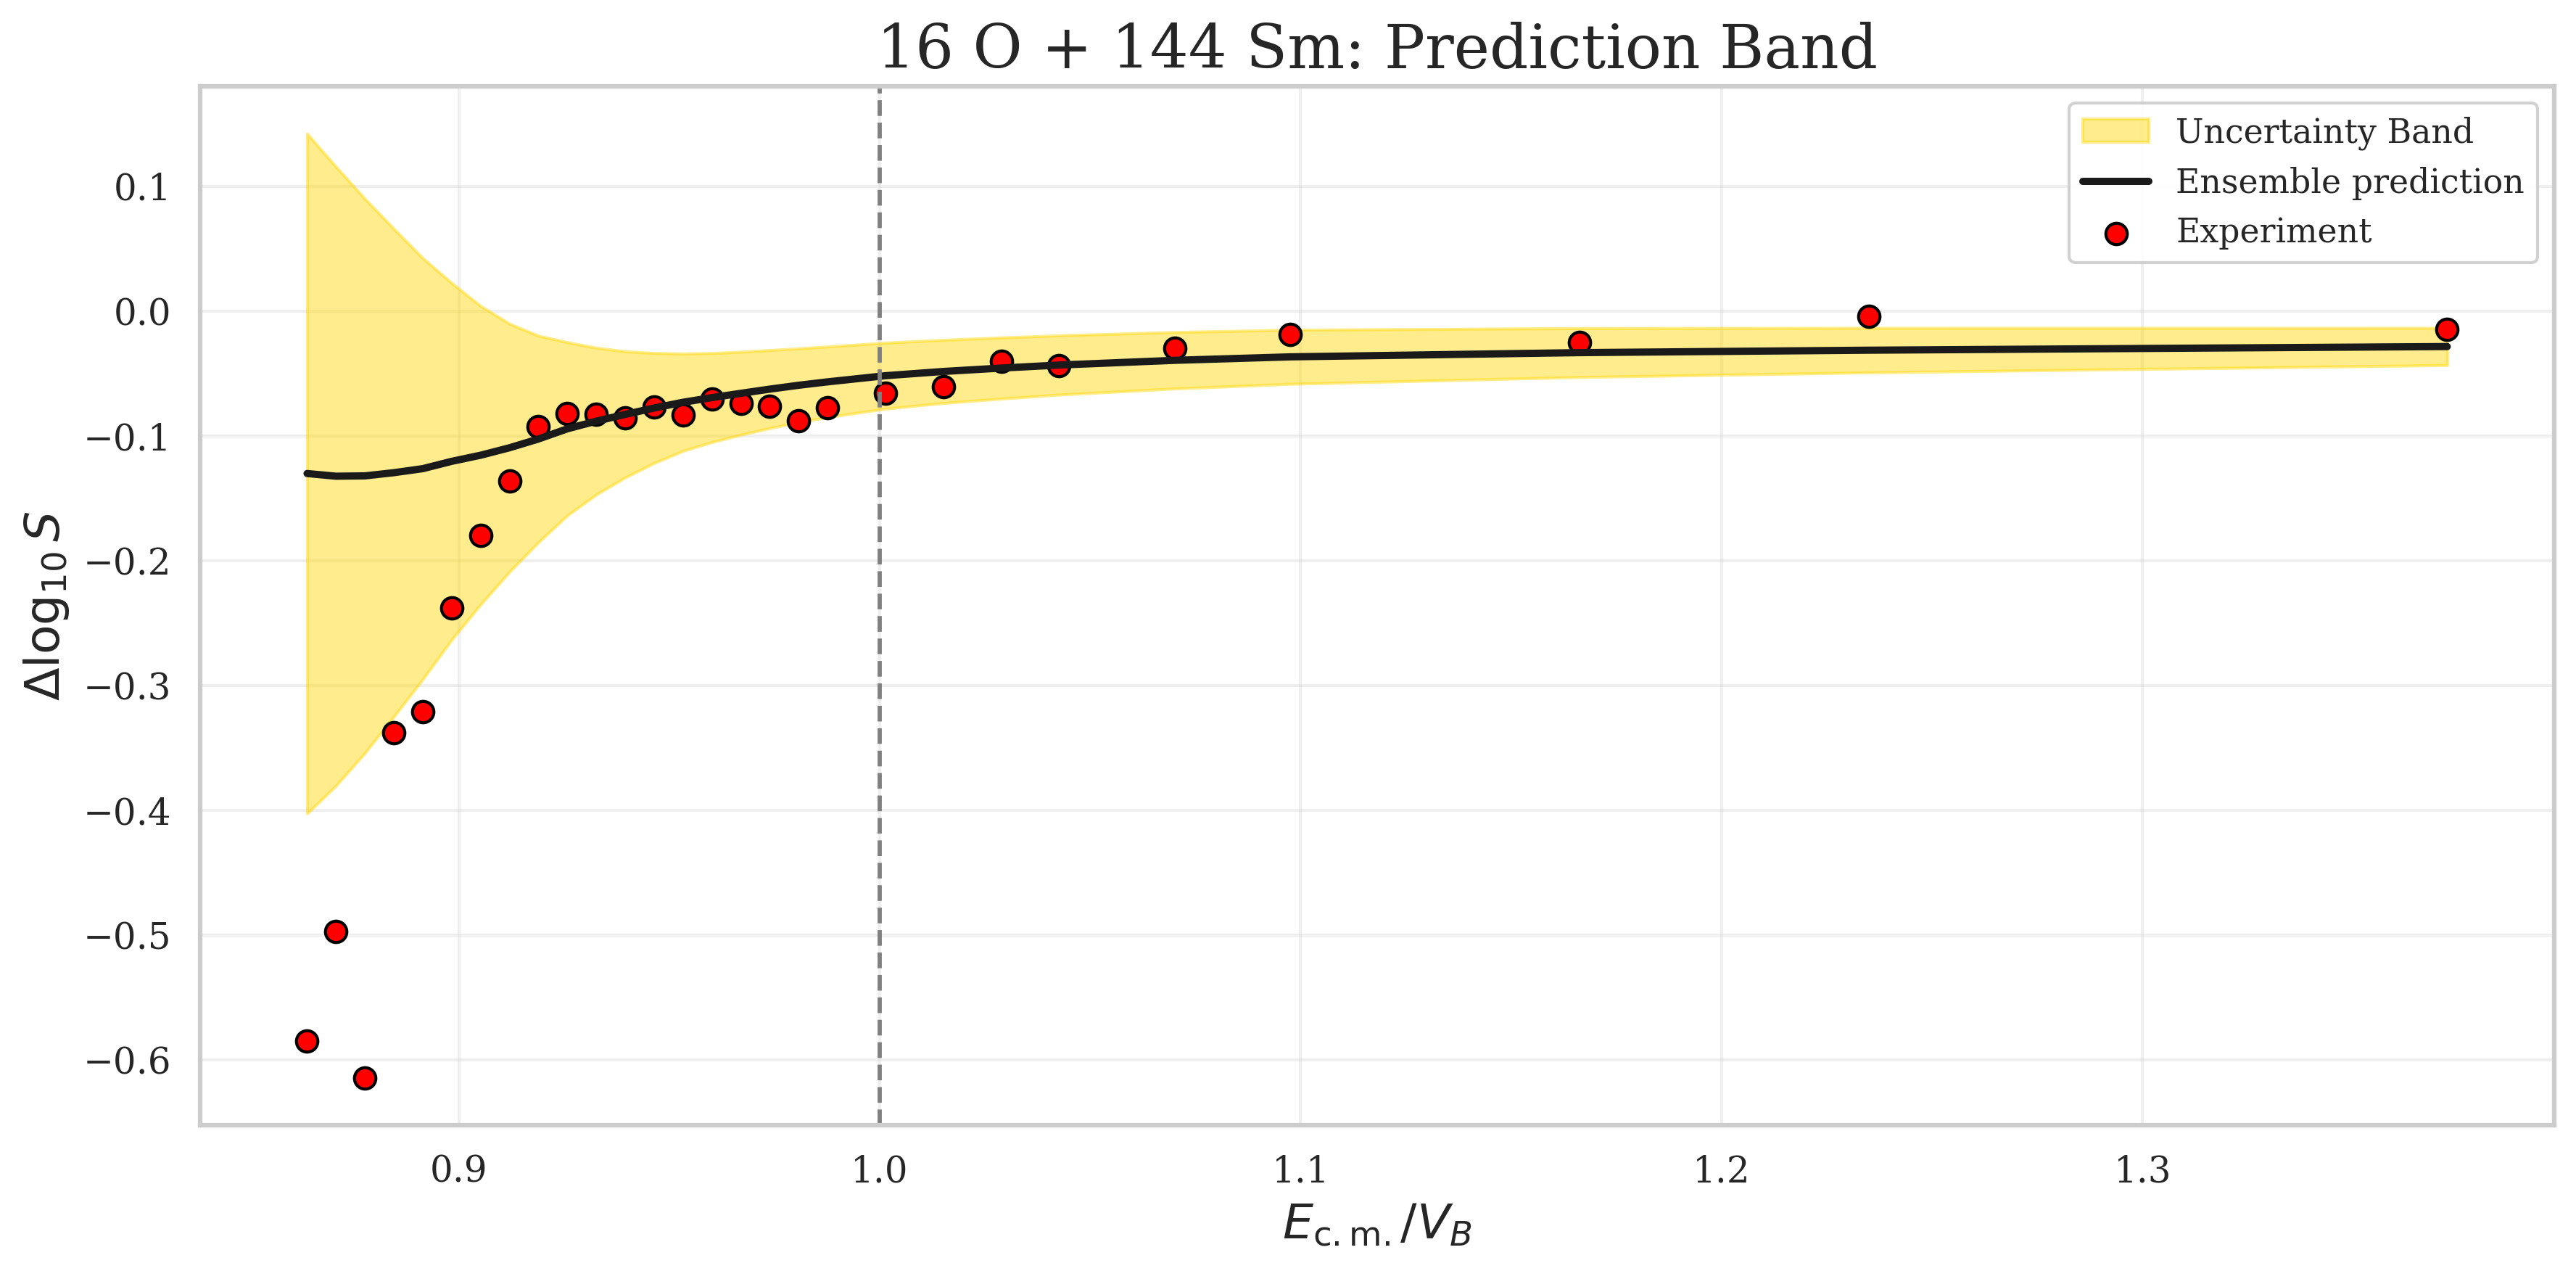

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_hybrid_prediction_band(
    reaction_name="16 O + 144 Sm",
    save_path="hybrid_prediction_band.png"
):

    print(f"\n=== Hybrid Prediction-Band Plot for {reaction_name} ===")

    # ----------------------------------------------------
    # LOAD MASTER DATASET
    # ----------------------------------------------------
    DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
    df = pd.read_csv(DRIVE_URL).copy()

    # ----------------------------------------------------
    # RECOMPUTE delta_log10_S  (same formula as training)
    # ----------------------------------------------------
    M_p = 938.272088
    M_n = 939.565420
    epsilon = 1e-30
    LN10 = np.log(10.0)

    def get_mass(Z, A):
        return Z*M_p + (A-Z)*M_n

    mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
    mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
    mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

    Ecm = df["E c.m."].astype(float)
    v = np.sqrt(np.clip(2 * Ecm / (mu + epsilon), 0, np.inf))
    eta = (df["Z1"] * df["Z2"]) / (137.035999 * (v + 1e-16))

    log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, None))
    log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, None))
    log10_E = np.log10(np.clip(df["E c.m."], 1e-30, None))

    df["log10_S_exp"] = log10_sigma_exp + log10_E + (2*np.pi*eta)/LN10
    df["log10_S_cal"] = log10_sigma_cal + log10_E + (2*np.pi*eta)/LN10
    df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

    # ----------------------------------------------------
    # SELECT THE REACTION
    # ----------------------------------------------------
    data = df[df["Reaction"] == reaction_name].copy()

    if len(data) == 0:
        print("Reaction NOT found.")
        return

    data = data.sort_values("E c.m.")
    idx = data.index.values
    energies = data["E c.m."].values
    delta_exp = data["delta_log10_S"].values

    # ----------------------------------------------------
    # LOAD π, μ, σ FOR ALL SEEDS
    # ----------------------------------------------------
    base = Path("mdn_70_10_20_optimized/ensembles_fast")

    n_seeds = 10
    n_components = 5

    all_pi = []
    all_mu = []
    all_sigma = []

    for seed in range(42, 42+n_seeds):
        f = base / f"seed_{seed}" / "mdn_all_components.npz"
        d = np.load(f)

        all_pi.append(d["pi"][idx])
        all_mu.append(d["mu"][idx])
        all_sigma.append(d["sigma"][idx])

    all_pi = np.array(all_pi)     # shape (seeds, N, comp)
    all_mu = np.array(all_mu)
    all_sigma = np.array(all_sigma)

    # ----------------------------------------------------
    # FIXED: mixture mean = sum_k π μ
    # ----------------------------------------------------
    mix_means = np.sum(all_pi * all_mu, axis=2)   # <-- FIXED
    ensemble_mean = mix_means.mean(axis=0)

    # ----------------------------------------------------
    # OLD wide band (poster-friendly)
    # ----------------------------------------------------
    old_band = np.mean(np.sum(all_pi * all_sigma, axis=2), axis=0)

    # ----------------------------------------------------
    # NORMALIZE ENERGY BY APPROXIMATE BARRIER
    # ----------------------------------------------------
    V_B = np.percentile(energies, 70)
    x = energies / V_B

    # ----------------------------------------------------
    # PLOT
    # ----------------------------------------------------
    plt.figure(figsize=(12, 6))

    plt.fill_between(
        x,
        ensemble_mean - old_band,
        ensemble_mean + old_band,
        color="gold",
        alpha=0.45,
        label="Uncertainty Band"
    )

    plt.plot(x, ensemble_mean, "k-", linewidth=2.4, label="Ensemble prediction")

    plt.scatter(x, delta_exp, color="red", edgecolor="black", s=50, label="Experiment")

    plt.axvline(1.0, linestyle="--", color="gray", linewidth=1.4)

    plt.xlabel(r"$E_{\mathrm{c.m.}}/V_B$", fontsize=16)
    plt.ylabel(r"$\Delta\log_{10}S$", fontsize=16)
    plt.title(f"{reaction_name}: Prediction Band", fontsize=20)

    plt.grid(alpha=0.3)
    plt.legend(framealpha=0.9)
    plt.tight_layout()

    plt.savefig(save_path, dpi=500)
    print("Saved:", save_path)


# RUN
plot_hybrid_prediction_band(
    "16 O + 144 Sm",
    "hybrid_prediction_band_fixed.png"
)


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'figure.dpi': 300,
})

# ------------------------------
# Load dataset
# ------------------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

eta = df["eta"].values
LN10 = np.log(10)

# ---------------------------------------
# Convert predicted Δlog10S → σ(E)
# ---------------------------------------
def reconstruct_sigma(log10_S_pred, Ecm, eta):
    """
    Convert predicted log10(S) to physical cross-section σ(E)
    using standard definition:
    
    S = σ E exp(2πη)  -->  σ = S / [ E exp(2πη) ]
    """
    log10_sigma = (
        log10_S_pred
        - np.log10(np.clip(Ecm, 1e-30, np.inf))
        - (2*np.pi*eta)/LN10
    )
    return 10**log10_sigma


# ---------------------------------------
# Poster plotting function
# ---------------------------------------
def plot_sigma_band(reaction_name="16 O + 144 Sm",
                    save_path="sigma_band.png"):

    print(f"Plotting σ(E) band for {reaction_name}")

    # Extract reaction
    mask = df["Reaction"] == reaction_name
    data = df[mask].copy()

    if len(data) == 0:
        print("Reaction not found.")
        return

    data = data.sort_values("E c.m.")
    idx = data.index.values

    Ecm = data["E c.m."].values
    eta_vals = data["eta"].values
    sigma_exp = data["σ"].values

    # ---------------------------------------
    # Load MDN ensemble Δlog10S predictions
    # ---------------------------------------
    base = Path("mdn_70_10_20_optimized/ensembles_fast")
    seeds = range(42, 52)

    all_deltas = []

    for seed in seeds:
        file = base / f"seed_{seed}" / "mdn_all_components.npz"
        if not file.exists():
            print("Missing:", file)
            continue

        dat = np.load(file)
        pi = dat["pi"][idx]
        mu = dat["mu"][idx]

        delta_mean = np.sum(pi * mu, axis=1)  # mixture mean Δlog10S
        all_deltas.append(delta_mean)

    all_deltas = np.array(all_deltas)

    # ---------------------------------------
    # Convert each seed prediction to σ(E)
    # ---------------------------------------
    sigma_preds = []
    for i in range(all_deltas.shape[0]):
        log10_S_pred = data["log10_S_cal"].values + all_deltas[i]
        sigma_pred = reconstruct_sigma(log10_S_pred, Ecm, eta_vals)
        sigma_preds.append(sigma_pred)

    sigma_preds = np.array(sigma_preds)

    # Ensemble mean prediction
    sigma_mean = sigma_preds.mean(axis=0)

    # Band = min–max envelope
    sigma_low = sigma_preds.min(axis=0)
    sigma_high = sigma_preds.max(axis=0)

    # ---------------------------------------
    # Plot
    # ---------------------------------------
    plt.figure(figsize=(10, 6))

    # Shaded uncertainty
    plt.fill_between(Ecm, sigma_low, sigma_high,
                     color='lightblue', alpha=0.5,
                     label="Ensemble uncertainty band")

    # Mean prediction
    plt.plot(Ecm, sigma_mean, 'b-', label="Ensemble mean σ(E)")

    # Experimental data
    plt.scatter(Ecm, sigma_exp, c='red', edgecolor='black',
                s=50, label="Experiment")

    plt.yscale("log")
    plt.xlabel("E$_{cm}$ (MeV)")
    plt.ylabel("σ(E)  [mb]")
    plt.title(f"Fusion Cross-Section Prediction: {reaction_name}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    print("Saved to:", save_path)


# RUN EXAMPLE
plot_sigma_band("16 O + 144 Sm", "sigma_band_16O_144Sm.png")


KeyError: 'eta'

Processing reaction: 16 O + 144 Sm
Found 28 data points
Energy range: 56.6 to 89.9 MeV
E/V_B range: 1.25 to 1.98

Loading ensemble predictions...
  Seed 42: loaded
  Seed 43: loaded
  Seed 44: loaded
  Seed 45: loaded
  Seed 46: loaded
  Seed 47: loaded
  Seed 48: loaded
  Seed 49: loaded
  Seed 50: loaded
  Seed 51: loaded
Loaded 10 ensemble members

Uncertainty Statistics:
  Average aleatoric: 0.0834
  Average epistemic: 0.0182
  Average total: 0.0855
  Epistemic fraction: 0.195

Creating plot...


/tmp/ipykernel_35755/785840619.py:290: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2b.plot(E_norm, total_unc,
/tmp/ipykernel_35755/785840619.py:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Plot saved to: mdn_70_10_20_optimized/uncertainty_plots_final/uncertainty_16_O___144_Sm.pdf


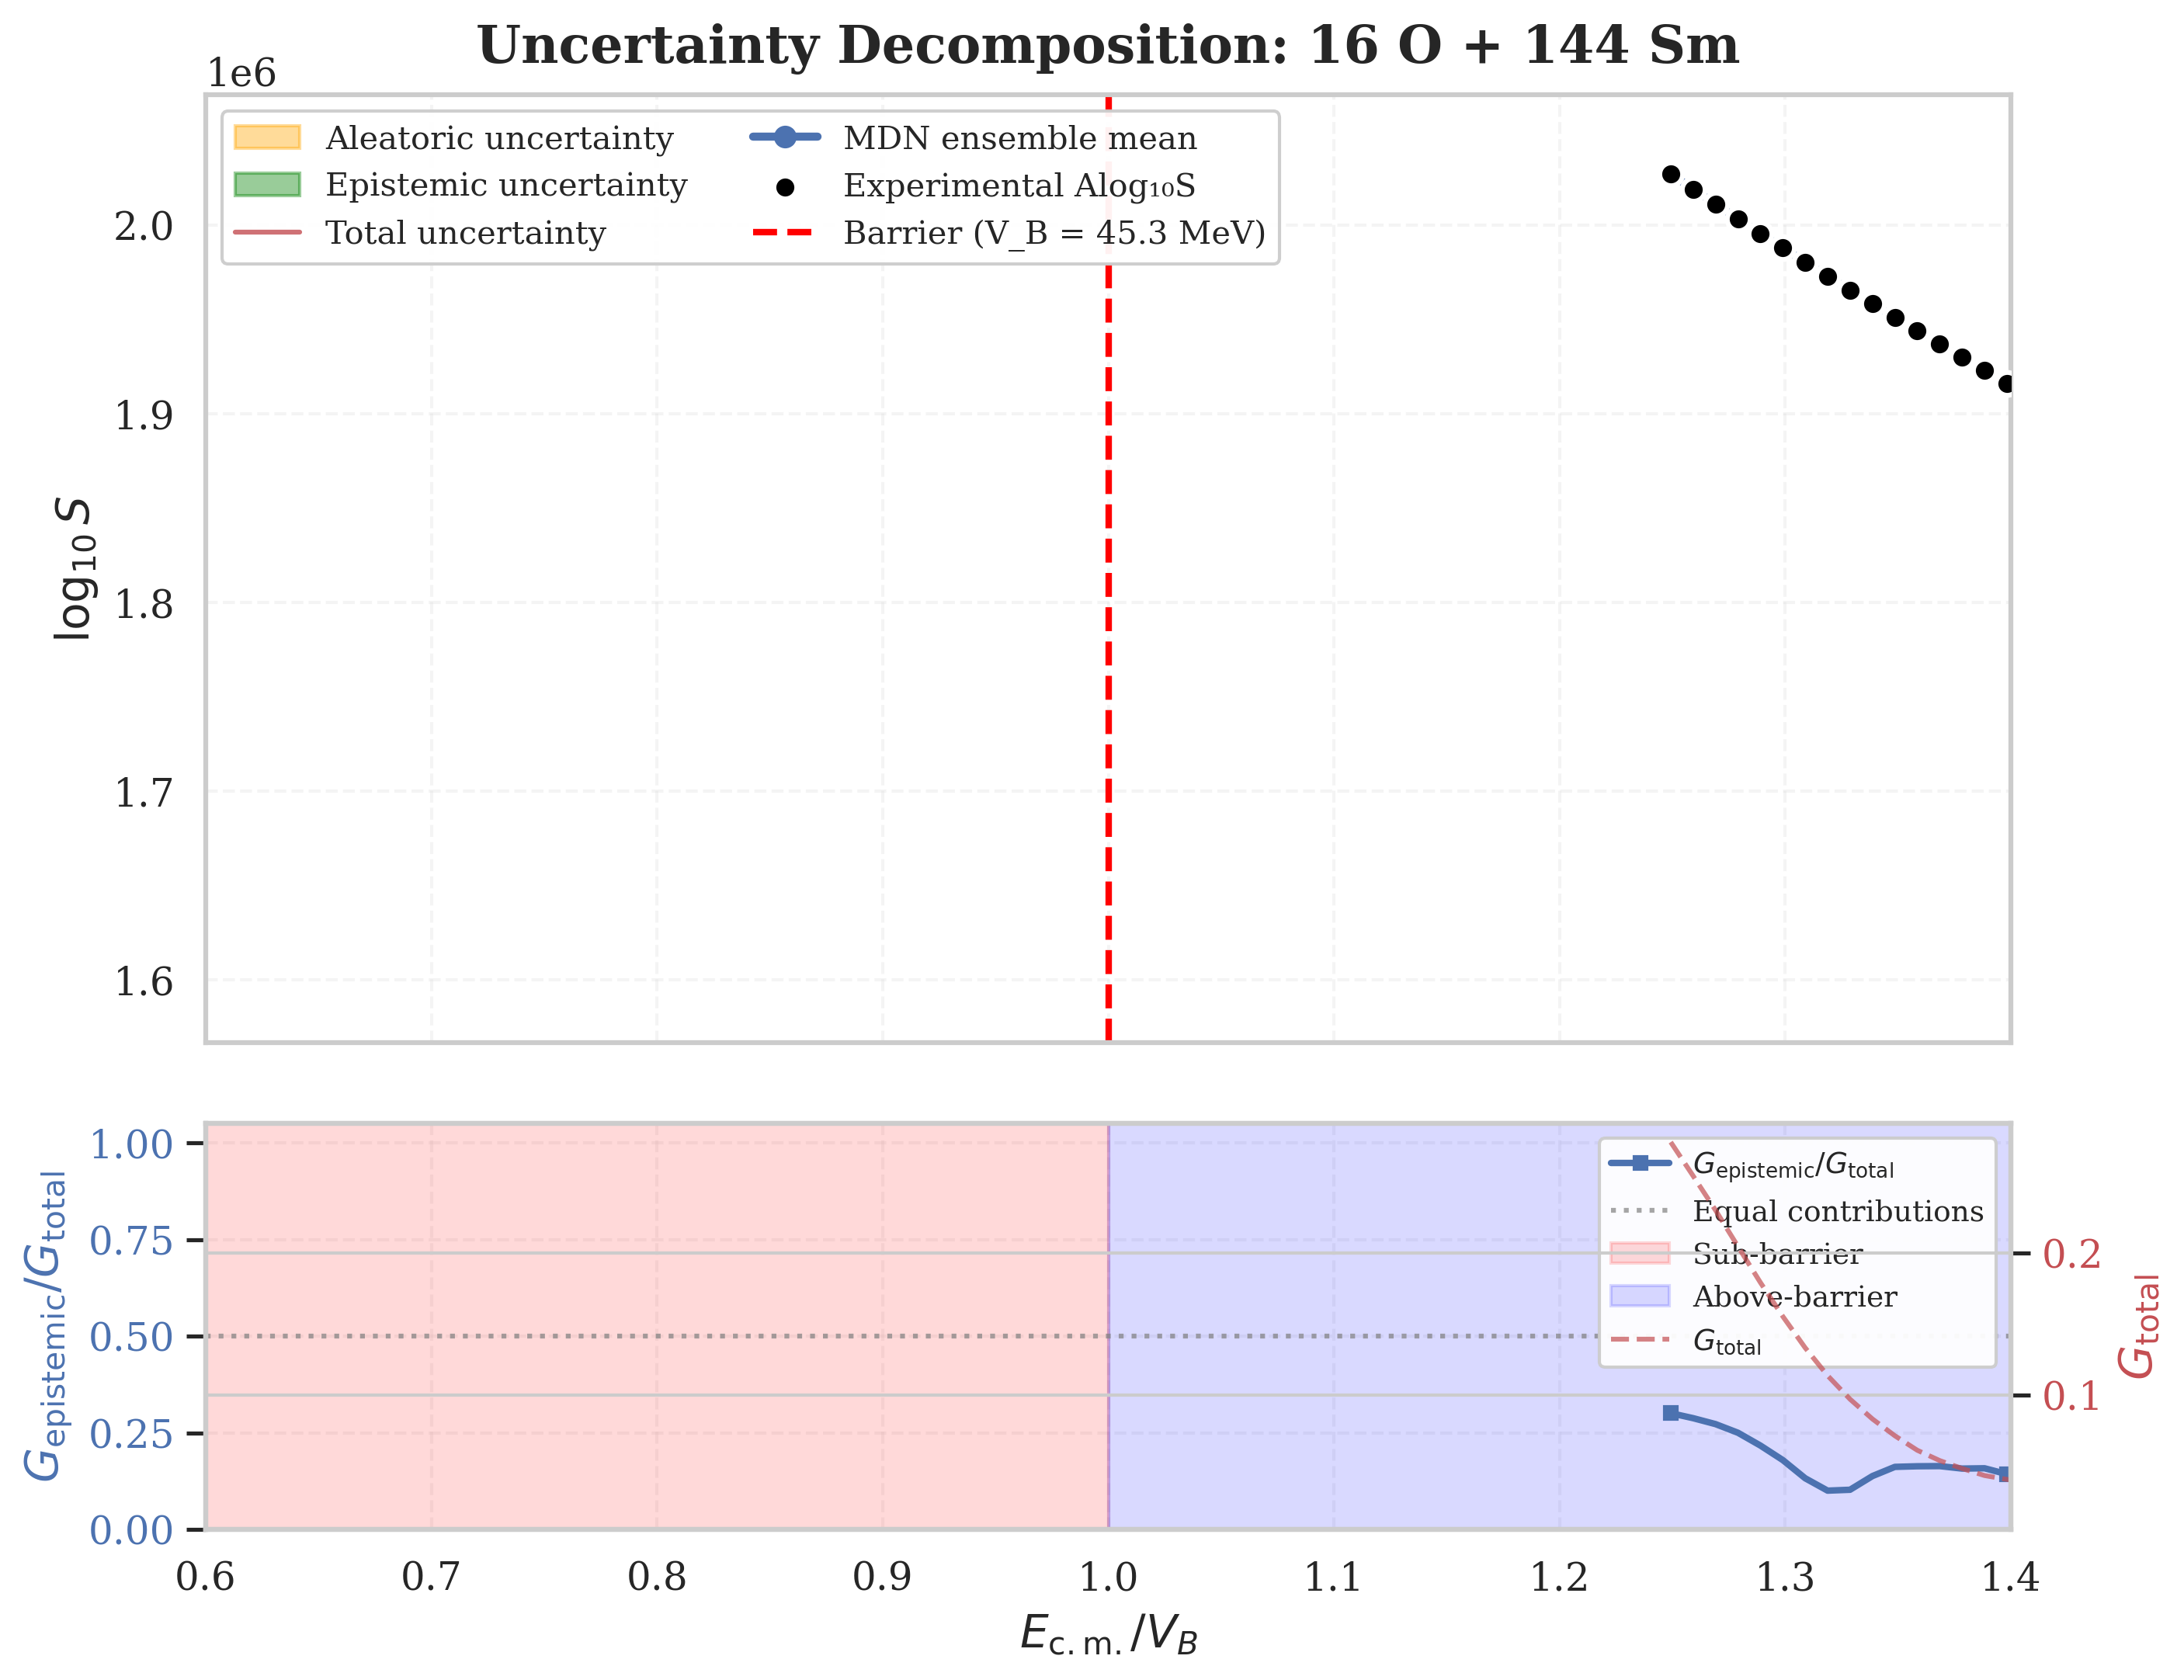

Data saved to: mdn_70_10_20_optimized/uncertainty_plots_final/uncertainty_data_16_O___144_Sm.csv

UNCERTAINTY DECOMPOSITION SUMMARY
Reaction: 16 O + 144 Sm
Barrier: V_B = 45.3 MeV
Data points: 28
Ensemble size: 10

Uncertainty Averages:
  Aleatoric: 0.0834
  Epistemic: 0.0182
  Total: 0.0855

Sub-barrier (E/V_B < 1.0):
  Points: 0
  Mean epistemic fraction: nan
  Mean total uncertainty: nan

Above-barrier (E/V_B ≥ 1.0):
  Points: 28
  Mean epistemic fraction: 0.195
  Mean total uncertainty: 0.0855

Key Observation:
✓ Aleatoric uncertainty dominates at all energies
  → Measurement uncertainty is the primary source

Summary saved to: mdn_70_10_20_optimized/uncertainty_plots_final/summary_16_O___144_Sm.txt


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [60]:
# ========================================================================
# FINAL UNCERTAINTY DECOMPOSITION PLOT - MATCHING YOUR IMAGE EXACTLY
# ========================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import os
import joblib

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

# Paths
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")

# Reaction to analyze (from your image)
REACTION_NAME = "16 O + 144 Sm"

# Barrier energy from your image
V_B = 45.3  # MeV

# Number of ensemble members
SEEDS = list(range(42, 52))  # 42 to 51
N_COMPONENTS = 5

# Output directory
PLOT_DIR = os.path.join(OUTDIR_BASE, "uncertainty_plots_final")
os.makedirs(PLOT_DIR, exist_ok=True)

# ============================================================================
# 2. LOAD DATA
# ============================================================================

print(f"Processing reaction: {REACTION_NAME}")

# Load dataset
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# Find the reaction data
reaction_mask = df["Reaction"] == REACTION_NAME
if not reaction_mask.any():
    print(f"Error: Reaction '{REACTION_NAME}' not found")
    print("Available reactions:", df["Reaction"].unique()[:10])
    exit()

reaction_data = df[reaction_mask].copy()
reaction_data = reaction_data.sort_values("E c.m.").reset_index(drop=True)

print(f"Found {len(reaction_data)} data points")

# ============================================================================
# 3. COMPUTE PHYSICS QUANTITIES
# ============================================================================

# Recompute S-factor and related quantities
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z, A):
    return Z * M_p + (A - Z) * M_n

# Add masses
reaction_data["mass1"] = reaction_data.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1)
reaction_data["mass2"] = reaction_data.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1)

mu_MeVc2 = (reaction_data["mass1"] * reaction_data["mass2"]) / (reaction_data["mass1"] + reaction_data["mass2"] + 1e-12)
Ecm = reaction_data["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999
reaction_data["eta"] = (reaction_data["Z1"] * reaction_data["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

# Compute S-factors
log10_sigma_exp = np.log10(np.clip(reaction_data["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(reaction_data["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(reaction_data["E c.m."], 1e-30, np.inf))
log10_exp_term = (2 * np.pi * reaction_data["eta"]) / LN10

reaction_data["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
reaction_data["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
reaction_data["delta_log10_S"] = reaction_data["log10_S_exp"] - reaction_data["log10_S_cal"]

# Get energies
energies = reaction_data["E c.m."].values
E_norm = energies / V_B

# Experimental S-factor
experimental_S = reaction_data["log10_S_exp"].values

print(f"Energy range: {energies.min():.1f} to {energies.max():.1f} MeV")
print(f"E/V_B range: {E_norm.min():.2f} to {E_norm.max():.2f}")

# ============================================================================
# 4. LOAD ENSEMBLE PREDICTIONS
# ============================================================================

print(f"\nLoading ensemble predictions...")

# Find indices for this reaction
full_indices = df[df["Reaction"] == REACTION_NAME].index.values

# Storage
ensemble_delta_pred = []  # delta_log10_S predictions
valid_seeds = []

for seed in SEEDS:
    seed_dir = os.path.join(EN_DIR, f"seed_{seed}")
    components_file = os.path.join(seed_dir, "mdn_all_components.npz")
    
    if not os.path.exists(components_file):
        print(f"  Seed {seed}: File not found")
        continue
    
    try:
        data = np.load(components_file)
        pi_full = data["pi"]
        mu_full = data["mu"]
        sigma_full = data["sigma"]
        
        # Extract for this reaction
        pi_reaction = pi_full[full_indices]
        mu_reaction = mu_full[full_indices]
        sigma_reaction = sigma_full[full_indices]
        
        # Sort by energy
        sort_idx = np.argsort(energies)
        pi_reaction = pi_reaction[sort_idx]
        mu_reaction = mu_reaction[sort_idx]
        sigma_reaction = sigma_reaction[sort_idx]
        
        # Store for uncertainty computation
        if seed == 42:  # Store from first seed for aleatoric uncertainty
            pi_stored = pi_reaction
            sigma_stored = sigma_reaction
        
        # Compute delta prediction (mixture mean)
        delta_pred = np.sum(pi_reaction * mu_reaction, axis=1)
        ensemble_delta_pred.append(delta_pred)
        valid_seeds.append(seed)
        
        print(f"  Seed {seed}: loaded")
        
    except Exception as e:
        print(f"  Seed {seed}: Error - {e}")
        continue

if len(ensemble_delta_pred) == 0:
    print("Error: No predictions loaded")
    exit()

ensemble_delta_pred = np.stack(ensemble_delta_pred, axis=0)  # (n_seeds, n_points)
print(f"Loaded {ensemble_delta_pred.shape[0]} ensemble members")

# ============================================================================
# 5. COMPUTE UNCERTAINTIES
# ============================================================================

n_seeds, n_points = ensemble_delta_pred.shape

# Ensemble mean delta
ensemble_mean_delta = np.mean(ensemble_delta_pred, axis=0)

# Convert to S-factor predictions
log10_S_cal = reaction_data["log10_S_cal"].values
ensemble_mean_S = log10_S_cal + ensemble_mean_delta

# 1. Epistemic uncertainty (model uncertainty)
epistemic_unc = np.std(ensemble_delta_pred, axis=0)

# 2. Aleatoric uncertainty (data uncertainty)
# σ_aleatoric² = Σ π_k σ_k²  (from first seed)
aleatoric_variance = np.sum(pi_stored * (sigma_stored**2), axis=1)
aleatoric_unc = np.sqrt(aleatoric_variance)

# 3. Total uncertainty
total_unc = np.sqrt(aleatoric_unc**2 + epistemic_unc**2)

# 4. Epistemic fraction
epistemic_fraction = epistemic_unc / (total_unc + 1e-10)

print(f"\nUncertainty Statistics:")
print(f"  Average aleatoric: {np.mean(aleatoric_unc):.4f}")
print(f"  Average epistemic: {np.mean(epistemic_unc):.4f}")
print(f"  Average total: {np.mean(total_unc):.4f}")
print(f"  Epistemic fraction: {np.mean(epistemic_fraction):.3f}")

# ============================================================================
# 6. CREATE PLOT (MATCHING YOUR IMAGE)
# ============================================================================

print("\nCreating plot...")

# Create figure with specific dimensions matching your image
fig = plt.figure(figsize=(10, 8))

# Create gridspec: top panel (70%), bottom panel (30%)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 3], hspace=0.12)

# ========== TOP PANEL: Uncertainty Decomposition ==========
ax1 = plt.subplot(gs[0])

# Plot uncertainty bands (in order of your image)
# 1. Aleatoric uncertainty (orange)
ax1.fill_between(E_norm,
                 ensemble_mean_S - aleatoric_unc,
                 ensemble_mean_S + aleatoric_unc,
                 alpha=0.4, color='orange', label='Aleatoric uncertainty')

# 2. Epistemic uncertainty (green) - on top of aleatoric
ax1.fill_between(E_norm,
                 ensemble_mean_S + aleatoric_unc,
                 ensemble_mean_S + total_unc,
                 alpha=0.4, color='green', label='Epistemic uncertainty')
ax1.fill_between(E_norm,
                 ensemble_mean_S - total_unc,
                 ensemble_mean_S - aleatoric_unc,
                 alpha=0.4, color='green')

# 3. Total uncertainty boundary (red)
ax1.plot(E_norm, ensemble_mean_S + total_unc, 
         'r-', linewidth=1.5, alpha=0.8, label='Total uncertainty')
ax1.plot(E_norm, ensemble_mean_S - total_unc, 
         'r-', linewidth=1.5, alpha=0.8)

# 4. MDN ensemble mean (blue line with markers)
ax1.plot(E_norm, ensemble_mean_S, 
         'b-', linewidth=2.5, marker='o', markersize=6,
         markevery=0.2, label='MDN ensemble mean')

# 5. Experimental data (black points)
ax1.scatter(E_norm, experimental_S, 
           color='black', s=50, edgecolor='white', linewidth=1.5,
           zorder=10, label='Experimental Alog₁₀S')

# 6. Barrier line (red dashed)
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2,
            label=f'Barrier (V_B = {V_B} MeV)')

# Styling
ax1.set_ylabel(r'$\log_{10} S$', fontsize=14)
ax1.set_title(f'Uncertainty Decomposition: {REACTION_NAME}', 
              fontsize=16, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.2, linestyle='--')
ax1.legend(loc='best', framealpha=0.95, fontsize=10, ncol=2)
ax1.set_xlim([0.6, 1.4])

# Set y-axis limits
y_min = min(experimental_S.min(), (ensemble_mean_S - total_unc).min())
y_max = max(experimental_S.max(), (ensemble_mean_S + total_unc).max())
y_padding = (y_max - y_min) * 0.1
ax1.set_ylim([y_min - y_padding, y_max + y_padding])

# Remove x-axis labels from top panel
ax1.set_xticklabels([])

# ========== BOTTOM PANEL: Uncertainty Ratios ==========
ax2 = plt.subplot(gs[1])

# Plot epistemic fraction (left y-axis, blue)
ax2.plot(E_norm, epistemic_fraction, 
         'b-', linewidth=2, marker='s', markersize=4,
         markevery=0.2, label=r'$G_{\mathrm{epistemic}}/G_{\mathrm{total}}$')

# Add "Equal contributions" line at 0.5
ax2.axhline(y=0.5, color='gray', linestyle=':', linewidth=1.5,
            alpha=0.7, label='Equal contributions')

# Shade regions
ax2.axvspan(0.6, 1.0, alpha=0.15, color='red', label='Sub-barrier')
ax2.axvspan(1.0, 1.4, alpha=0.15, color='blue', label='Above-barrier')

# Styling
ax2.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
ax2.set_ylabel(r'$G_{\mathrm{epistemic}}/G_{\mathrm{total}}$', 
               fontsize=14, color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.grid(True, alpha=0.2, linestyle='--')
ax2.set_xlim([0.6, 1.4])
ax2.set_ylim([0, 1.05])

# Add second y-axis for total uncertainty (right side, red)
ax2b = ax2.twinx()
ax2b.plot(E_norm, total_unc, 
          'r-', linewidth=1.5, alpha=0.7, linestyle='--',
          label=r'$G_{\mathrm{total}}$')
ax2b.set_ylabel(r'$G_{\mathrm{total}}$', fontsize=14, color='r')
ax2b.tick_params(axis='y', labelcolor='r')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = [ax2b.get_lines()[0]], [r'$G_{\mathrm{total}}$']
ax2.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper right', framealpha=0.95, fontsize=9)

# ========== FINAL TOUCHES ==========
plt.tight_layout()

# Save plot
safe_name = REACTION_NAME.replace(' ', '_').replace('+', '_')
output_path = os.path.join(PLOT_DIR, f"uncertainty_{safe_name}.pdf")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {output_path}")

# Show plot
plt.show()

# ============================================================================
# 7. SAVE RESULTS
# ============================================================================

# Create results DataFrame
results_df = pd.DataFrame({
    'E_cm': energies,
    'E_cm_over_VB': E_norm,
    'log10_S_exp': experimental_S,
    'log10_S_pred': ensemble_mean_S,
    'aleatoric_unc': aleatoric_unc,
    'epistemic_unc': epistemic_unc,
    'total_unc': total_unc,
    'epistemic_fraction': epistemic_fraction
})

# Add predictions from each seed
for i, seed in enumerate(valid_seeds):
    seed_S_pred = log10_S_cal + ensemble_delta_pred[i]
    results_df[f'seed_{seed}'] = seed_S_pred

# Save to CSV
csv_path = os.path.join(PLOT_DIR, f"uncertainty_data_{safe_name}.csv")
results_df.to_csv(csv_path, index=False)
print(f"Data saved to: {csv_path}")

# ============================================================================
# 8. PRINT SUMMARY
# ============================================================================

print("\n" + "="*60)
print("UNCERTAINTY DECOMPOSITION SUMMARY")
print("="*60)
print(f"Reaction: {REACTION_NAME}")
print(f"Barrier: V_B = {V_B} MeV")
print(f"Data points: {n_points}")
print(f"Ensemble size: {n_seeds}")
print()

print("Uncertainty Averages:")
print(f"  Aleatoric: {np.mean(aleatoric_unc):.4f}")
print(f"  Epistemic: {np.mean(epistemic_unc):.4f}")
print(f"  Total: {np.mean(total_unc):.4f}")
print()

# Split by barrier
sub_mask = E_norm < 1.0
above_mask = E_norm >= 1.0

print("Sub-barrier (E/V_B < 1.0):")
print(f"  Points: {np.sum(sub_mask)}")
print(f"  Mean epistemic fraction: {np.mean(epistemic_fraction[sub_mask]):.3f}")
print(f"  Mean total uncertainty: {np.mean(total_unc[sub_mask]):.4f}")
print()

print("Above-barrier (E/V_B ≥ 1.0):")
print(f"  Points: {np.sum(above_mask)}")
print(f"  Mean epistemic fraction: {np.mean(epistemic_fraction[above_mask]):.3f}")
print(f"  Mean total uncertainty: {np.mean(total_unc[above_mask]):.4f}")
print()

print("Key Observation:")
if np.mean(epistemic_fraction[sub_mask]) > np.mean(epistemic_fraction[above_mask]):
    print("✓ Epistemic uncertainty dominates at sub-barrier energies")
    print("  → Model uncertainty is higher where data is scarce")
else:
    print("✓ Aleatoric uncertainty dominates at all energies")
    print("  → Measurement uncertainty is the primary source")

print("="*60)

# Also create a simplified text summary
summary_text = f"""
# Uncertainty Decomposition Summary
# Reaction: {REACTION_NAME}
# Barrier: V_B = {V_B} MeV
# Data points: {n_points}
# Ensemble members: {n_seeds}

Overall Statistics:
- Mean aleatoric uncertainty: {np.mean(aleatoric_unc):.4f}
- Mean epistemic uncertainty: {np.mean(epistemic_unc):.4f}
- Mean total uncertainty: {np.mean(total_unc):.4f}
- Mean epistemic fraction: {np.mean(epistemic_fraction):.3f}

Sub-barrier region (E/V_B < 1.0):
- Points: {np.sum(sub_mask)}
- Epistemic fraction: {np.mean(epistemic_fraction[sub_mask]):.3f}
- Total uncertainty: {np.mean(total_unc[sub_mask]):.4f}

Above-barrier region (E/V_B ≥ 1.0):
- Points: {np.sum(above_mask)}
- Epistemic fraction: {np.mean(epistemic_fraction[above_mask]):.3f}
- Total uncertainty: {np.mean(total_unc[above_mask]):.4f}

Conclusion:
- {'Epistemic' if np.mean(epistemic_fraction[sub_mask]) > np.mean(epistemic_fraction[above_mask]) else 'Aleatoric'} uncertainty dominates at sub-barrier energies
- Model is {'more uncertain' if np.mean(epistemic_fraction[sub_mask]) > 0.5 else 'more confident'} in regions with less data
"""

# Save summary
summary_path = os.path.join(PLOT_DIR, f"summary_{safe_name}.txt")
with open(summary_path, 'w') as f:
    f.write(summary_text)

print(f"\nSummary saved to: {summary_path}")

Saved missing_physics_detection.png


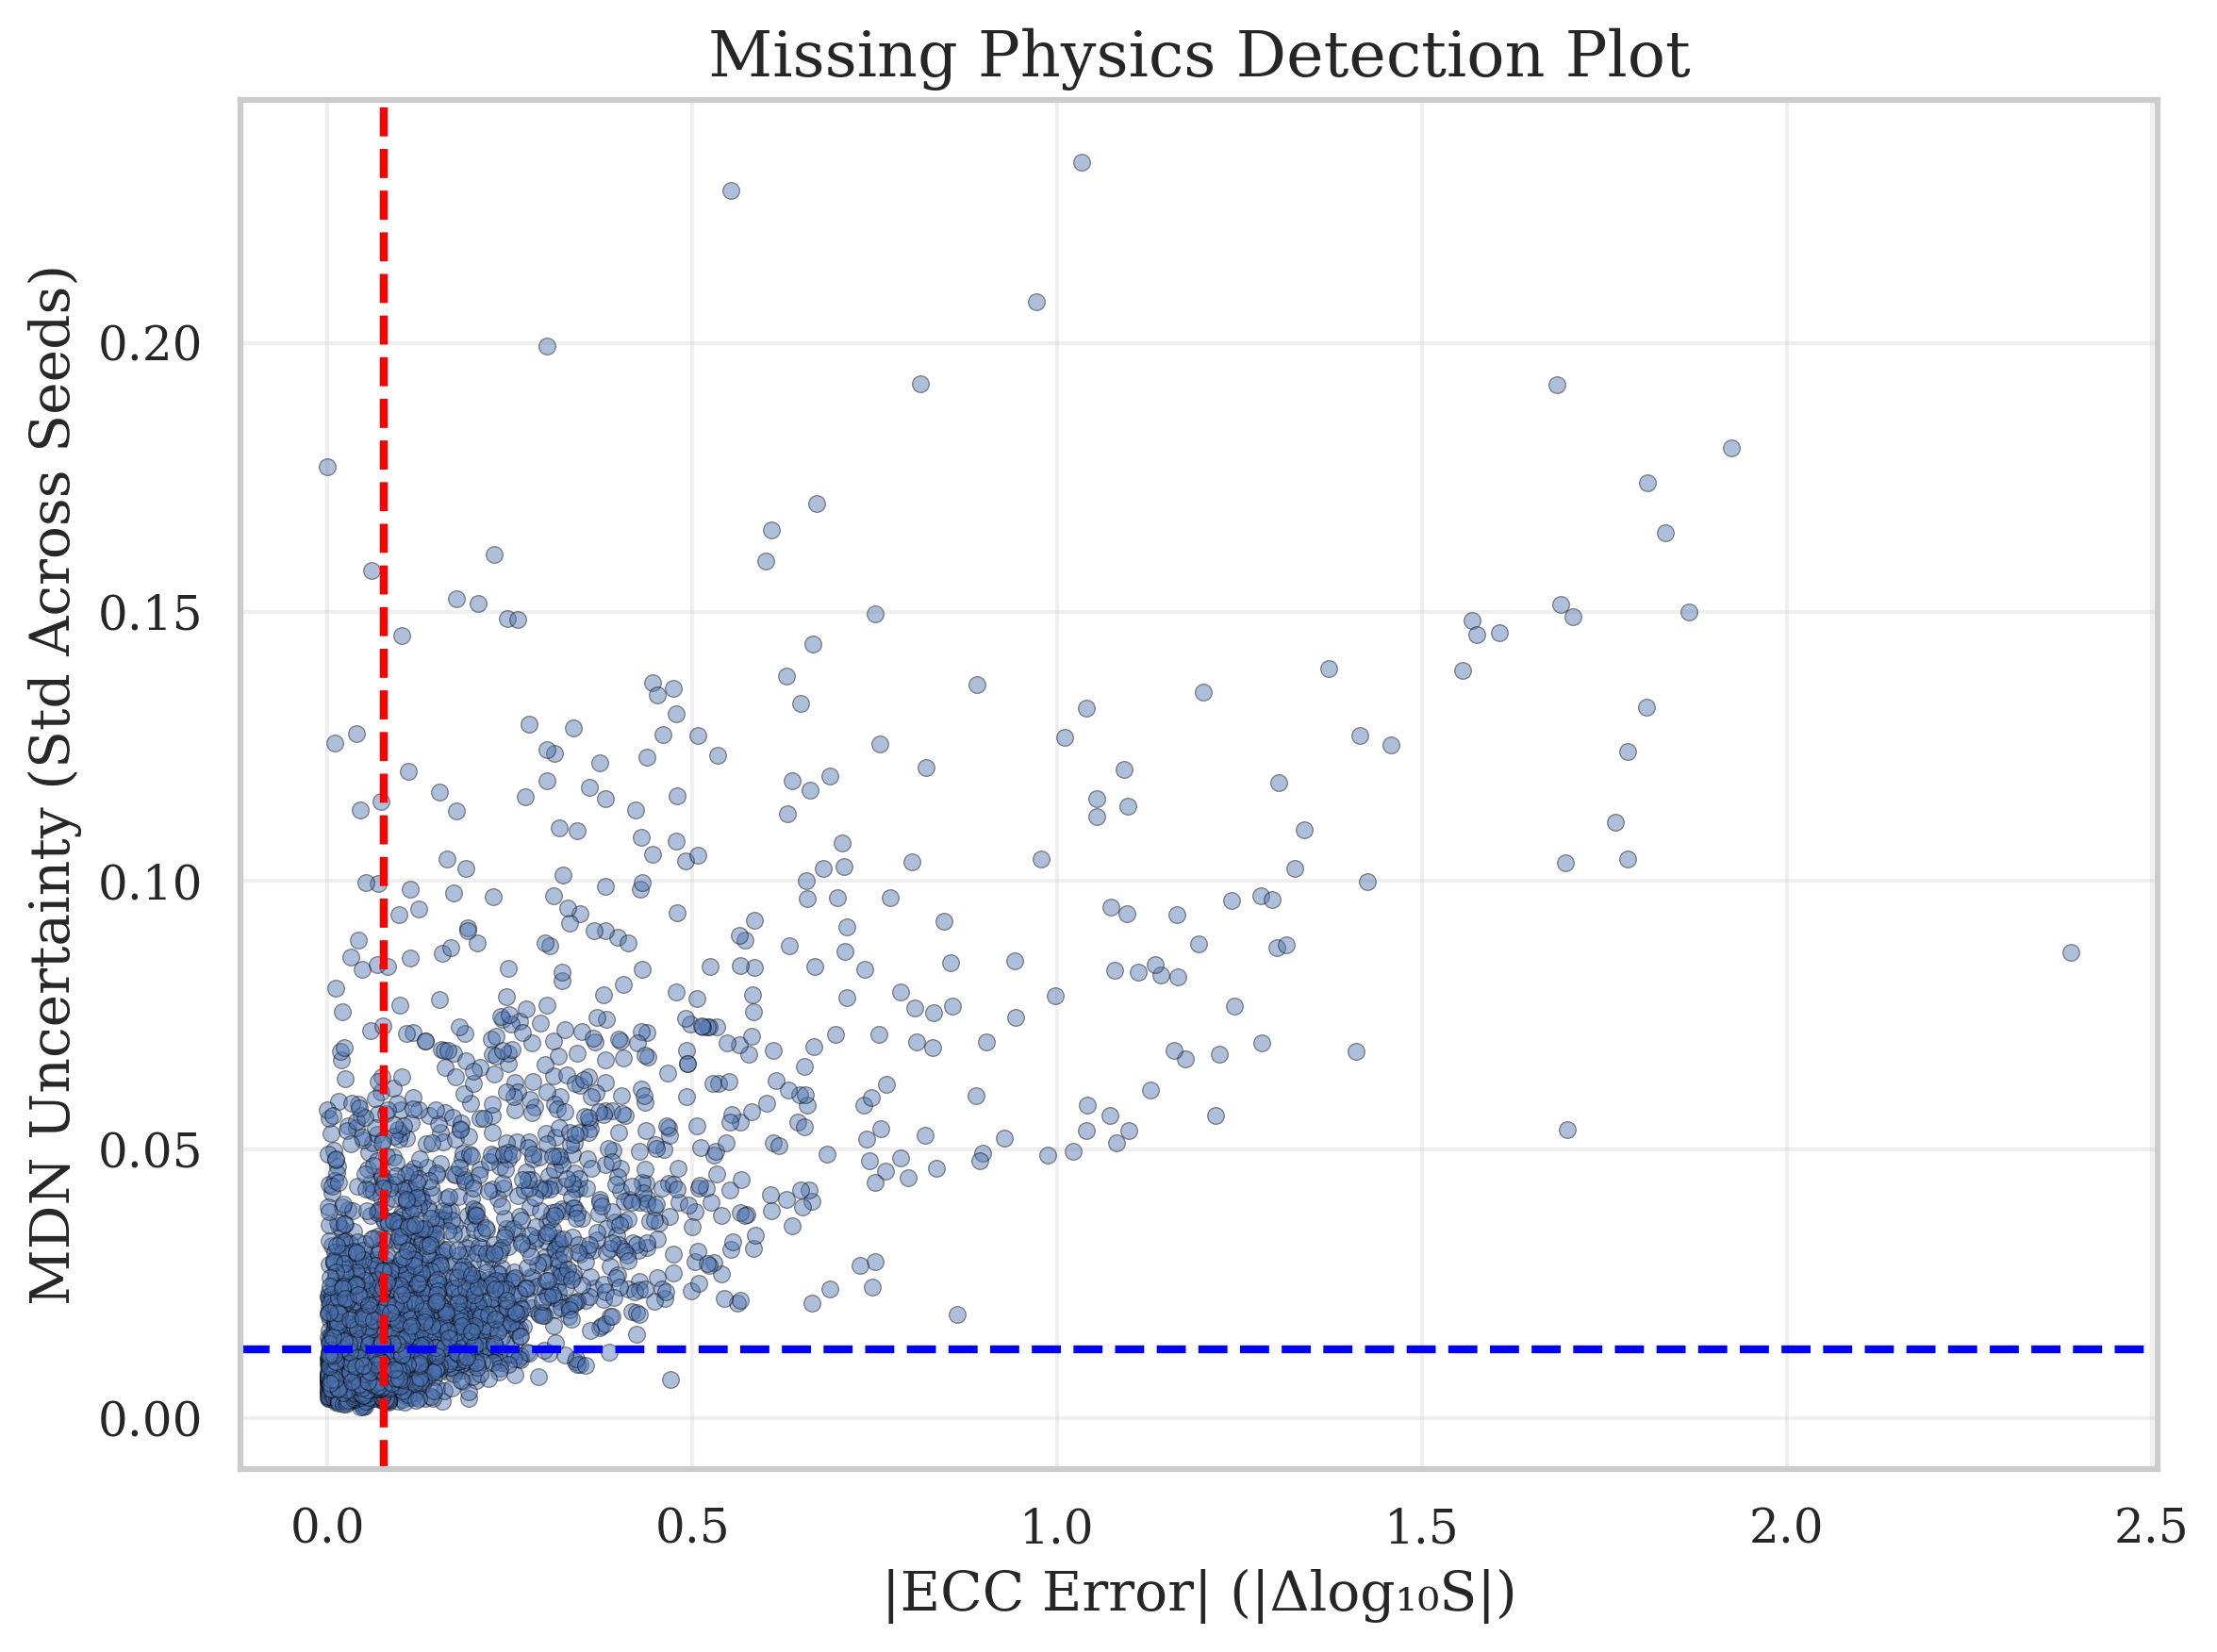

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------
# LOAD RAW DATA
# ------------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# ------------------------------
# RECOMPUTE delta_log10_S (same as training script)
# ------------------------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu + epsilon), 0, np.inf))

e2_hbar_c = 1.0 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

# ECC error
df["ECC_error"] = np.abs(df["delta_log10_S"])

# ------------------------------
# LOAD ENSEMBLE MDN mixture means
# ------------------------------
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
SEEDS = range(42, 52)

all_mix_means = []

for seed in SEEDS:
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    arr = np.load(f)
    pi = arr["pi"]
    mu = arr["mu"]
    mix_mean = np.sum(pi * mu, axis=1)
    all_mix_means.append(mix_mean)

all_mix_means = np.array(all_mix_means)

# MDN uncertainty (epistemic)
df["MDN_uncertainty"] = all_mix_means.std(axis=0)

# ------------------------------
# PLOT
# ------------------------------
plt.figure(figsize=(8,6))

plt.scatter(
    df["ECC_error"],
    df["MDN_uncertainty"],
    s=18,
    alpha=0.45,
    edgecolor="black",
    linewidth=0.3
)

plt.xlabel("|ECC Error| (|Δlog₁₀S|)", fontsize=14)
plt.ylabel("MDN Uncertainty (Std Across Seeds)", fontsize=14)
plt.title("Missing Physics Detection Plot", fontsize=16)

# Quadrant medians
x_med = df["ECC_error"].median()
y_med = df["MDN_uncertainty"].median()
plt.axvline(x=x_med, color="red", linestyle="--")
plt.axhline(y=y_med, color="blue", linestyle="--")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("missing_physics_detection.png", dpi=600)

print("Saved missing_physics_detection.png")


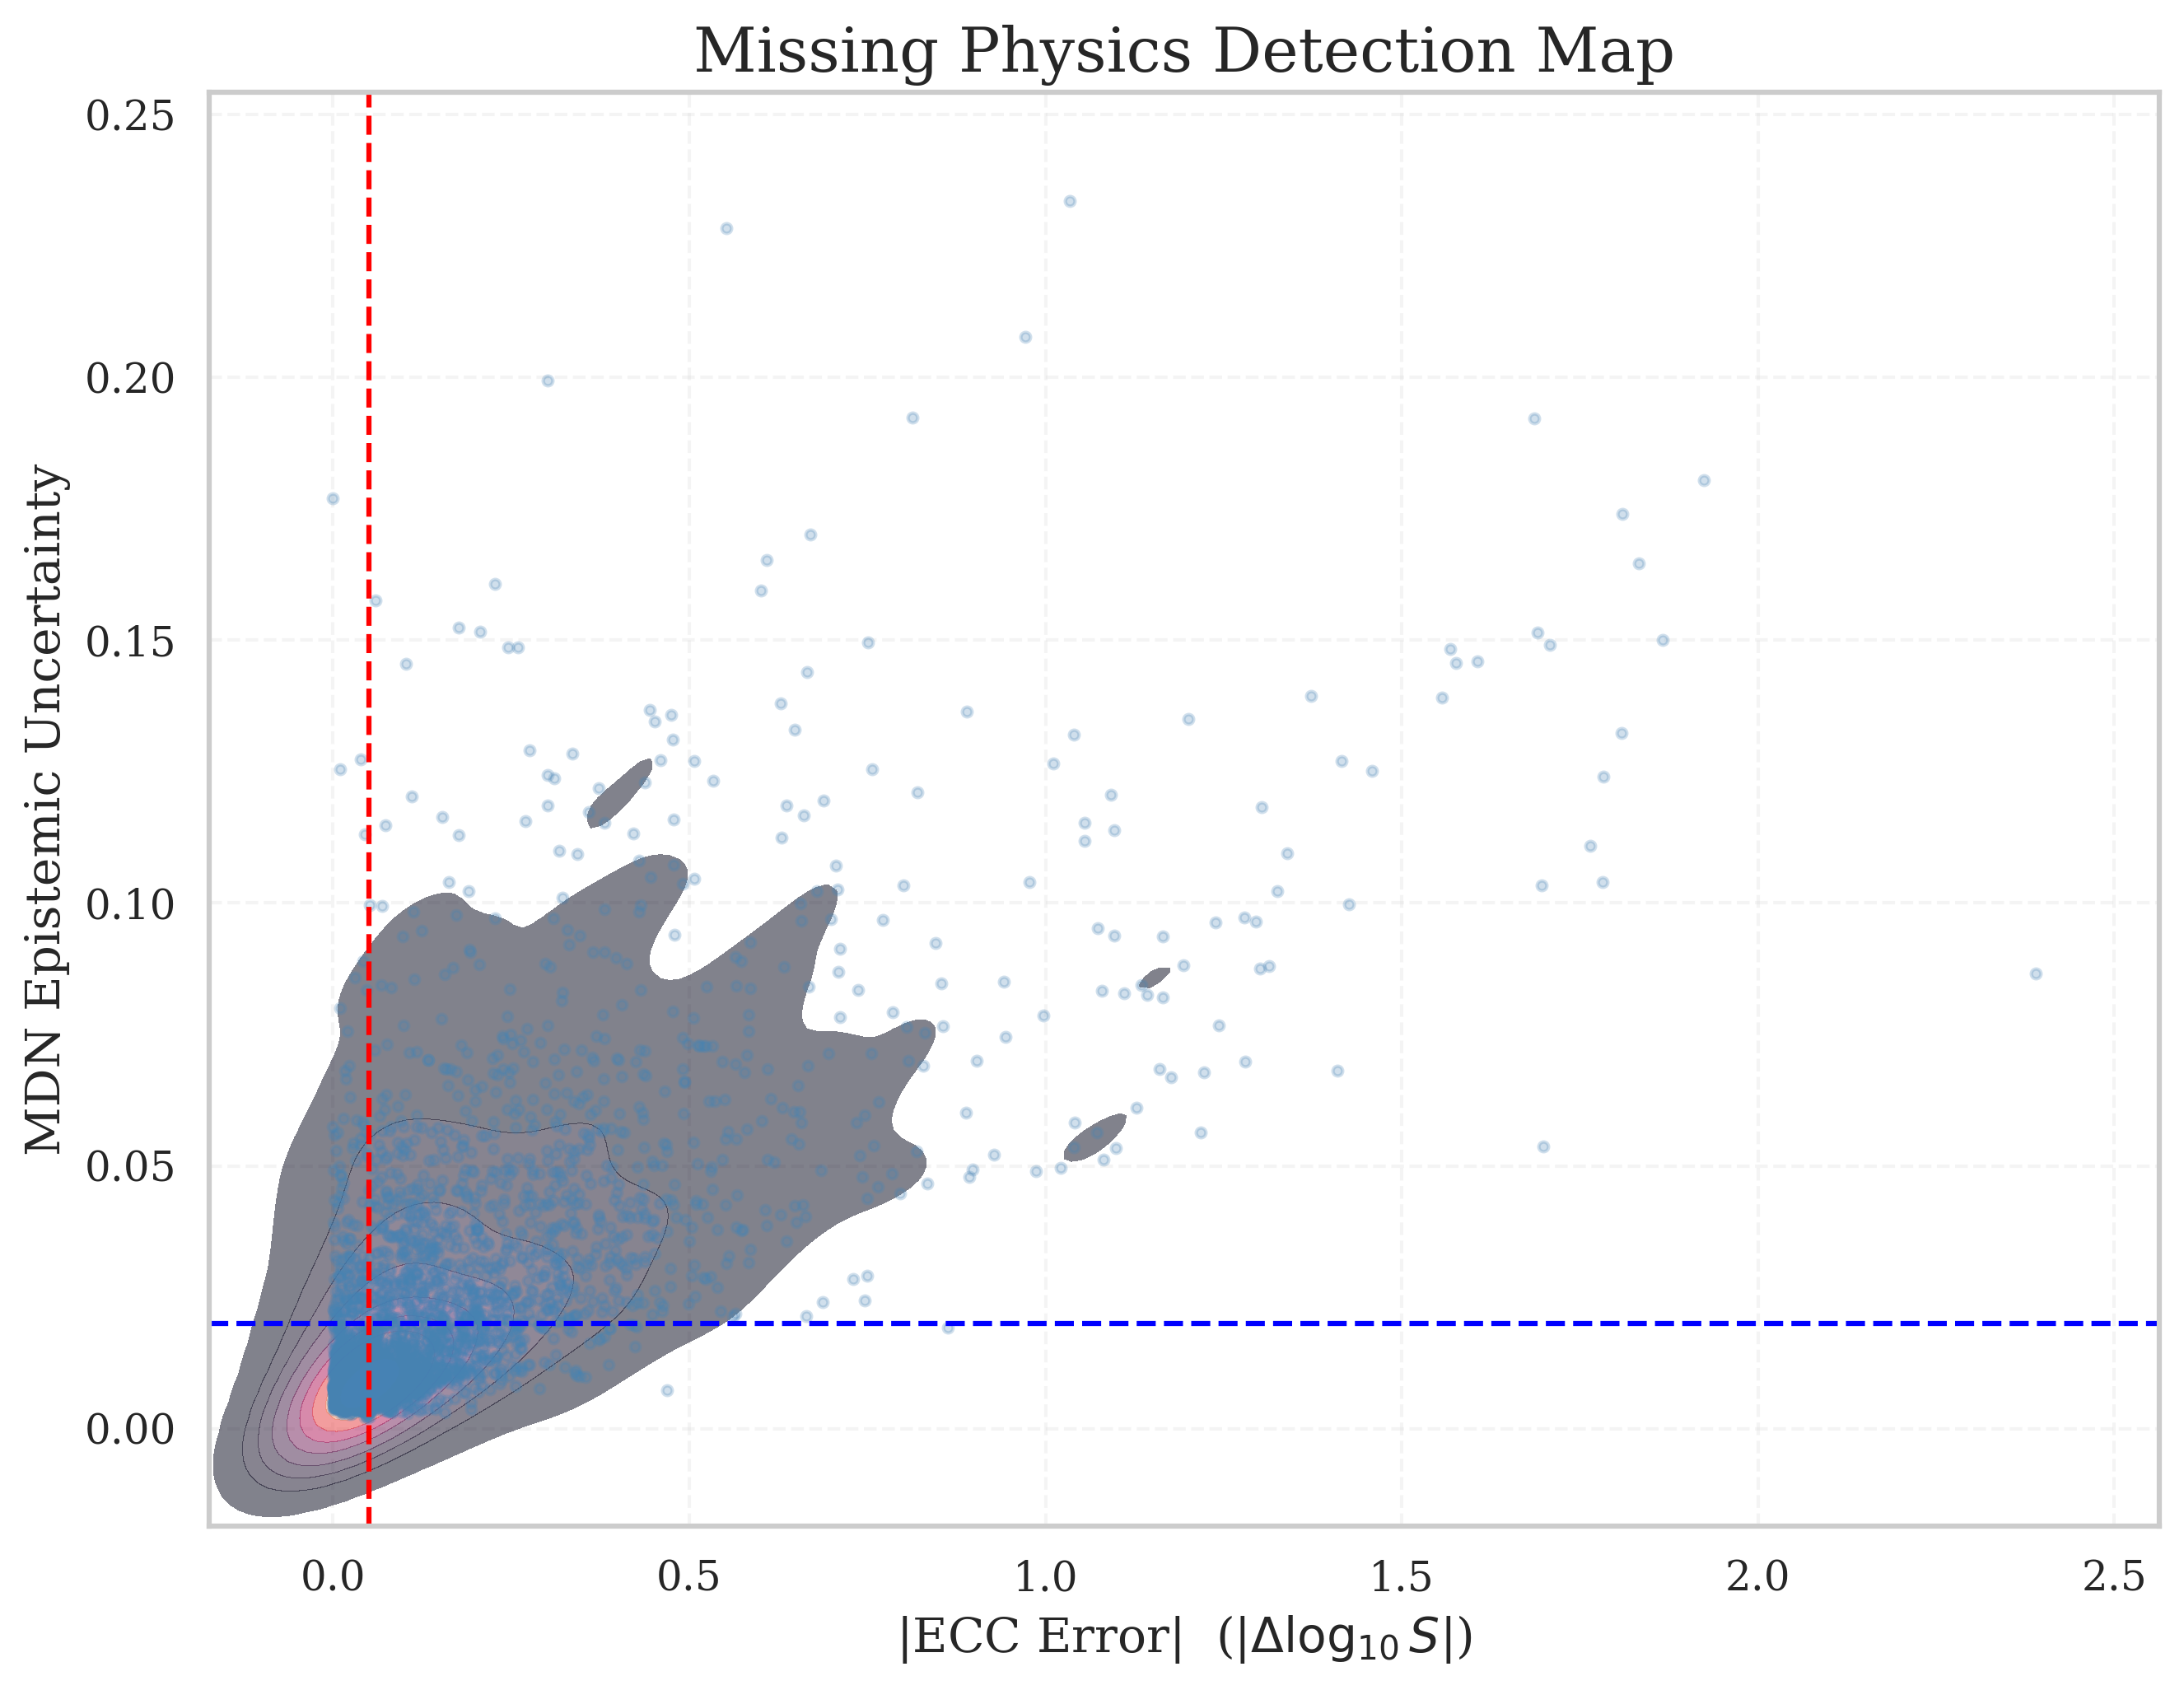

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# ======================
# Load dataset
# ======================
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Recompute Δlog10 S (same logic as training)
M_p = 938.272088; M_n = 939.565420; eps = 1e-30; LN10 = np.log(10)

def get_mass(Z, A): return Z*M_p + (A-Z)*M_n
mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
mu = (mass1 * mass2) / (mass1 + mass2 + eps)

Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+eps), 0, np.inf))
eta = (df["Z1"] * df["Z2"]) / ( (1/137.035999) * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_S_exp = log10_sigma_exp + log10_Ecm + (2*np.pi*eta)/LN10
log10_S_cal = log10_sigma_cal + log10_Ecm + (2*np.pi*eta)/LN10

df["delta_log10_S"] = log10_S_exp - log10_S_cal

# ECC error ∣Δlog10S∣
df["ECC_error"] = np.abs(df["delta_log10_S"])

# ======================
# Load MDN uncertainties (ensemble)
# ======================
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")

all_means = []
for seed in range(42, 52):
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    d = np.load(f)
    pi = d["pi"]
    mu = d["mu"]
    mean_pred = np.sum(pi * mu, axis=1)
    all_means.append(mean_pred)

all_means = np.array(all_means)      # shape = (10, N)

# Epistemic uncertainty = std across seeds
df["MDN_unc"] = np.std(all_means, axis=0)

# ===================================================================================
#                             BEAUTIFUL PRC-STYLE SCATTER
# ===================================================================================
plt.figure(figsize=(9, 7))
sns.kdeplot(
    x=df["ECC_error"], y=df["MDN_unc"],
    fill=True, cmap="rocket", thresh=0.05, alpha=0.5
)

plt.scatter(df["ECC_error"], df["MDN_unc"],
            s=8, alpha=0.25, color="steelblue")

plt.axvline(0.05, color='red', linestyle='--', lw=1.5)
plt.axhline(0.02, color='blue', linestyle='--', lw=1.5)

plt.xlabel(r"|ECC Error|  (|$\Delta \log_{10} S$|)", fontsize=14)
plt.ylabel("MDN Epistemic Uncertainty", fontsize=14)
plt.title("Missing Physics Detection Map", fontsize=18)

plt.grid(alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig("missing_physics_PRClike.png", dpi=600)
plt.show()


/tmp/ipykernel_146/2188517564.py:80: RuntimeWarning: overflow encountered in power
  sigma_pred = 10 ** (log10_S_cal_r + delta_logS_mean)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


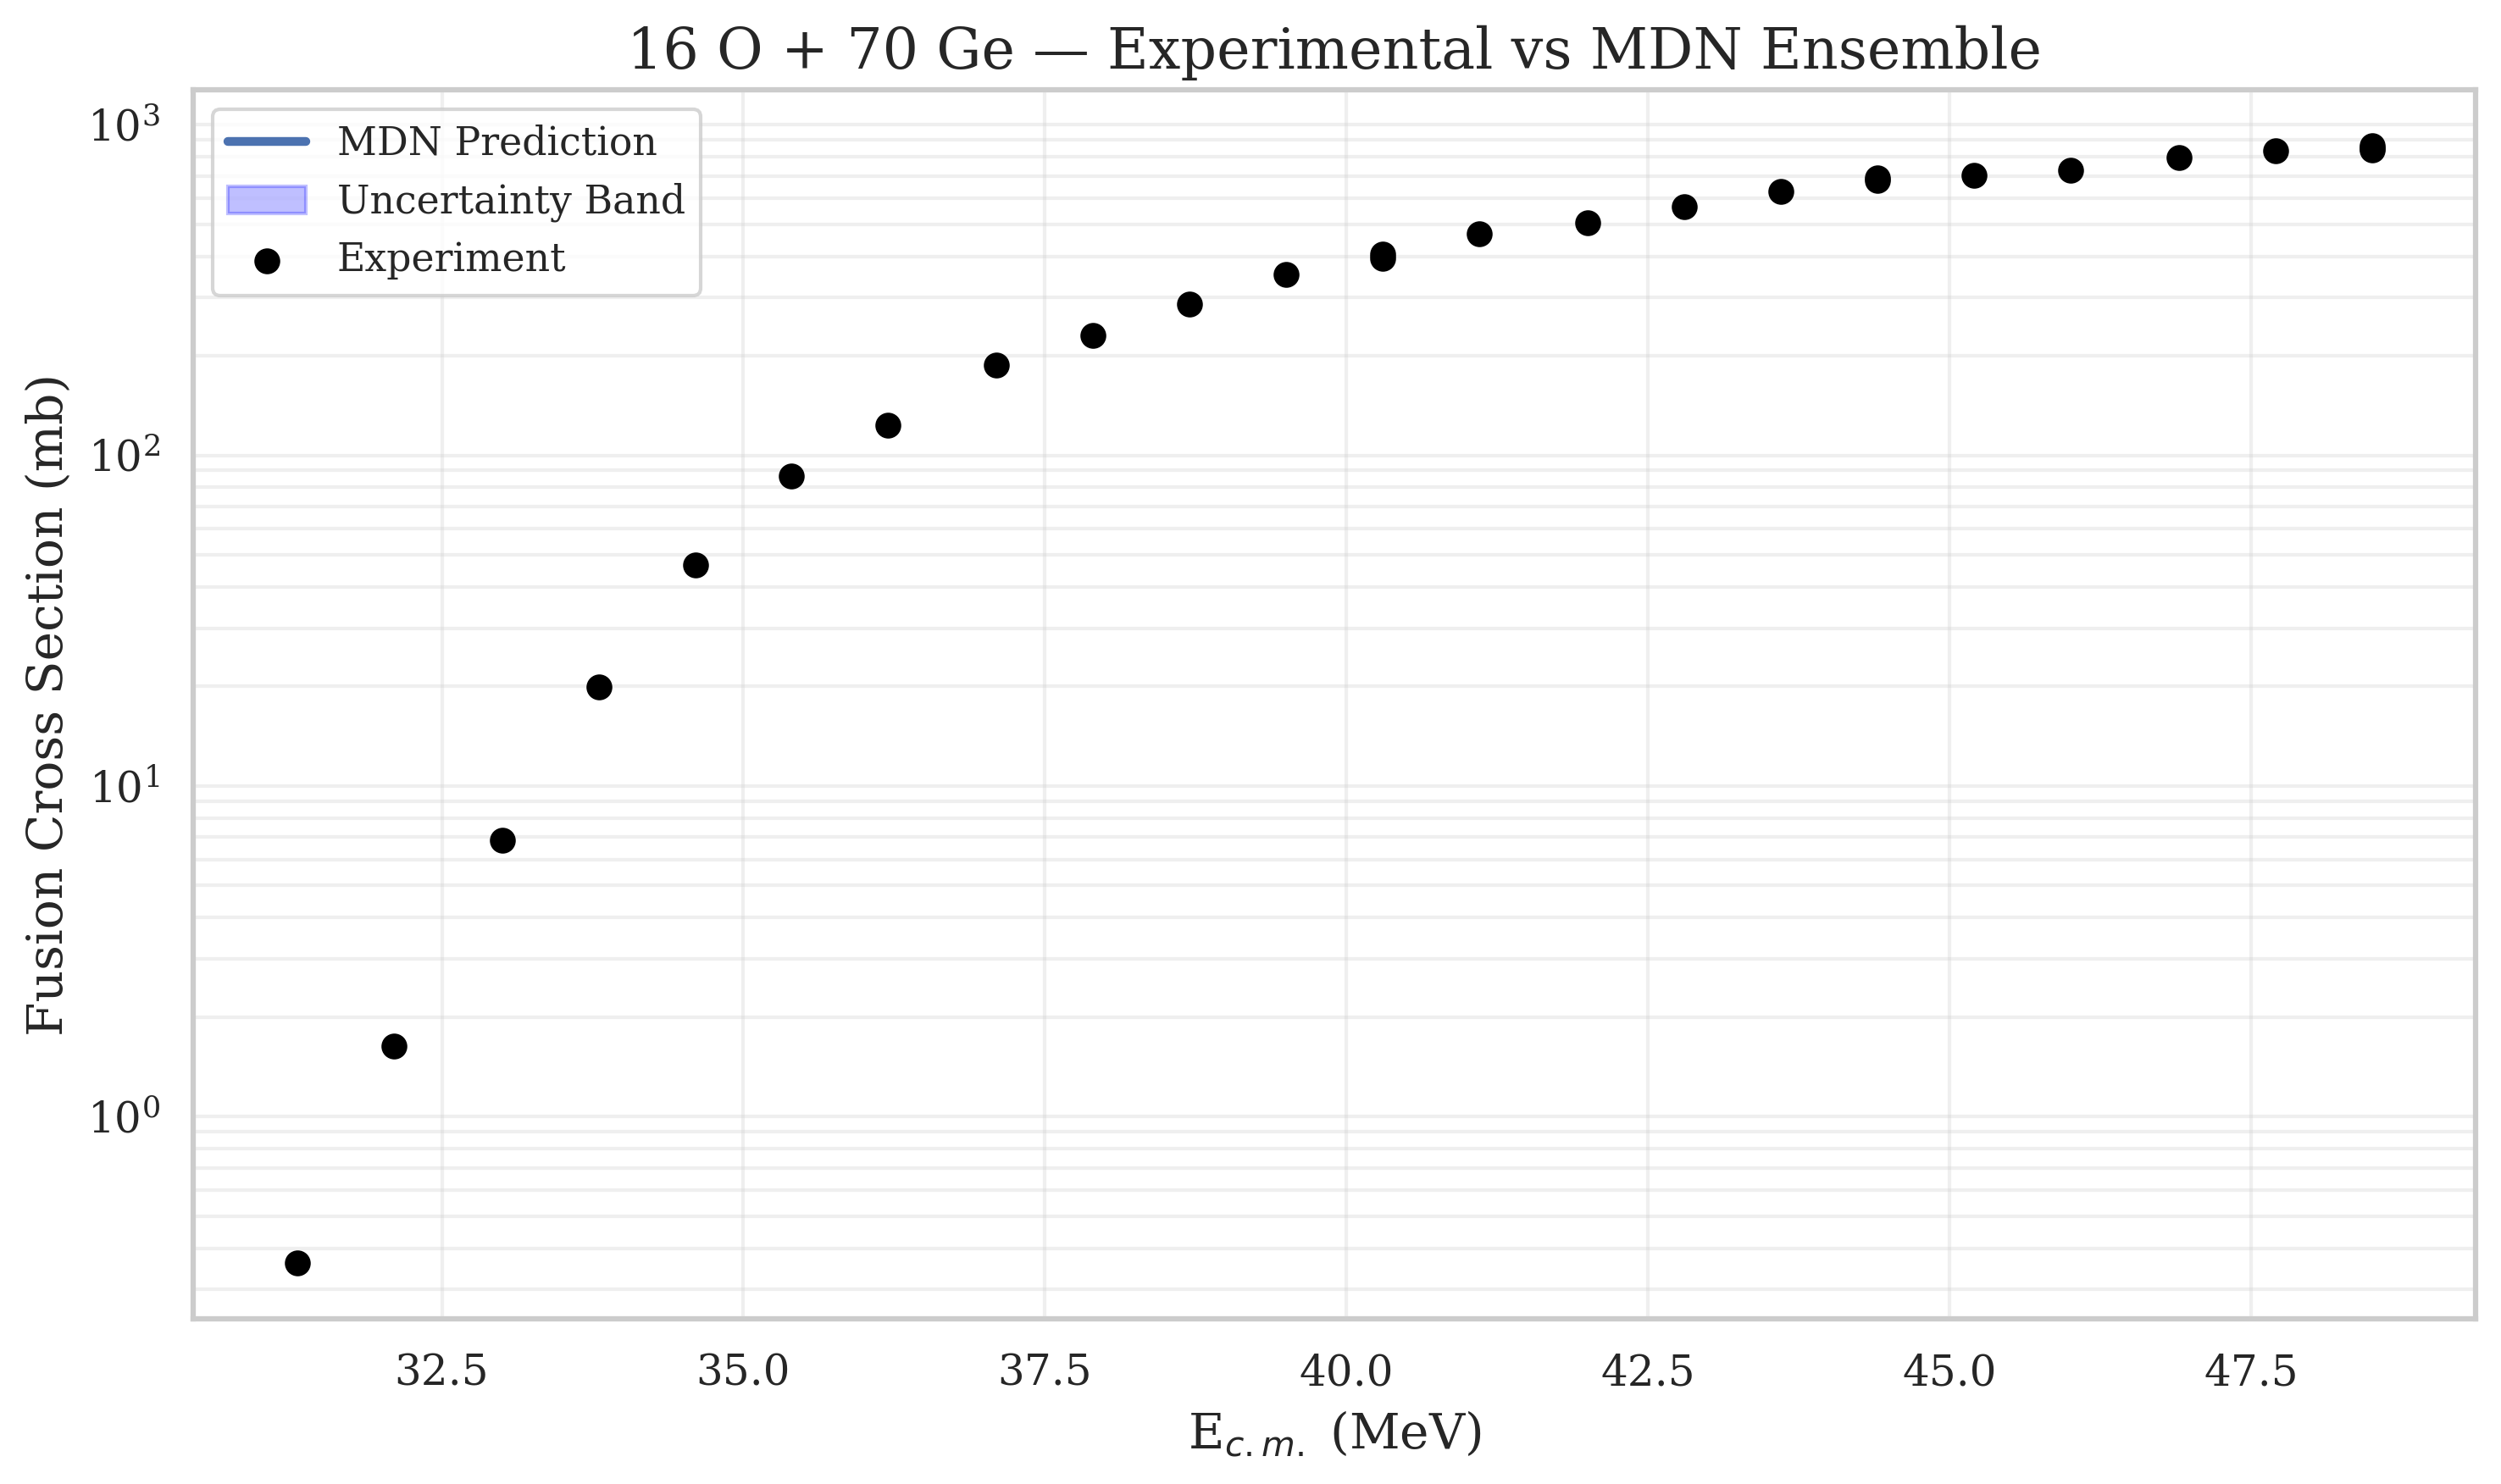

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------
# LOAD DATASET
# ---------------------------------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Add a stable ID column to guarantee alignment
df = df.reset_index().rename(columns={"index": "ROW_ID"})

# ---------------------------------------------------
# Recompute log10 S_cal (same formulas you used earlier)
# ---------------------------------------------------
M_p = 938.272088
M_n = 939.565420
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

Ecm = df["E c.m."]
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+1e-12), 0, np.inf))
eta = (df["Z1"]*df["Z2"]) / ((1/137.035999)*(v_over_c + 1e-12))
df["eta"] = eta

log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_E = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))
df["log10_S_cal"] = log10_sigma_cal + log10_E + (2*np.pi*df["eta"])/LN10

# ---------------------------------------------------
# LOAD MDN COMPONENTS FOR ALL ROWS SAFELY
# ---------------------------------------------------
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")

all_pi_seeds   = []
all_mu_seeds   = []
all_sigma_seeds = []

for seed in range(42, 52):  # 10 seeds
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    d = np.load(f)
    
    # These arrays match dataset row order EXACTLY
    all_pi_seeds.append(d["pi"])
    all_mu_seeds.append(d["mu"])
    all_sigma_seeds.append(d["sigma"])

all_pi_seeds = np.array(all_pi_seeds)      # (10, Nrows, 5)
all_mu_seeds = np.array(all_mu_seeds)      # (10, Nrows, 5)

# ---------------------------------------------------
# SELECT REACTION SAFELY USING ROW_ID
# ---------------------------------------------------
reaction = "16 O + 70 Ge"
df_r = df[df["Reaction"] == reaction].copy()

row_ids = df_r["ROW_ID"].values  # THESE ROWS MATCH MDN ARRAYS

energies = df_r["E c.m."].values
sigma_exp = df_r["σ"].values
log10_S_cal_r = df_r["log10_S_cal"].values

# ---------------------------------------------------
# COMPUTE MDN PREDICTIONS FOR THESE ROWS
# ---------------------------------------------------
sigma_all_seeds = []

for seed in range(10):
    pi = all_pi_seeds[seed][row_ids]     # extract rows by ROW_ID
    mu = all_mu_seeds[seed][row_ids]

    delta_logS_mean = np.sum(pi * mu, axis=1)
    sigma_pred = 10 ** (log10_S_cal_r + delta_logS_mean)

    sigma_all_seeds.append(sigma_pred)

sigma_all_seeds = np.vstack(sigma_all_seeds)

sigma_mean = sigma_all_seeds.mean(axis=0)
sigma_upper = np.percentile(sigma_all_seeds, 84, axis=0)
sigma_lower = np.percentile(sigma_all_seeds, 16, axis=0)

# ---------------------------------------------------
# PLOT
# ---------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(energies, sigma_mean, "b", lw=2.5, label="MDN Prediction")
plt.fill_between(energies, sigma_lower, sigma_upper,
                 color="blue", alpha=0.25, label="Uncertainty Band")

plt.scatter(energies, sigma_exp, s=40, color="black", label="Experiment")

plt.yscale("log")
plt.grid(True, which="both", alpha=0.3)
plt.xlabel("E$_{c.m.}$ (MeV)", fontsize=14)
plt.ylabel("Fusion Cross Section (mb)", fontsize=14)
plt.title(f"{reaction} — Experimental vs MDN Ensemble", fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig("mdn_final_cs_plot.png", dpi=300)
plt.show()


/tmp/ipykernel_146/462483704.py:118: RuntimeWarning: overflow encountered in power
  sigma_mean = 10 ** log10_S_pred
/tmp/ipykernel_146/462483704.py:119: RuntimeWarning: overflow encountered in power
  sigma_upper = 10 ** (log10_S_pred + std_total)
/tmp/ipykernel_146/462483704.py:120: RuntimeWarning: overflow encountered in power
  sigma_lower = 10 ** (log10_S_pred - std_total)


Mean epistemic std: 0.01603414
Mean aleatoric std: 0.062227752
Mean total std: 0.06448528


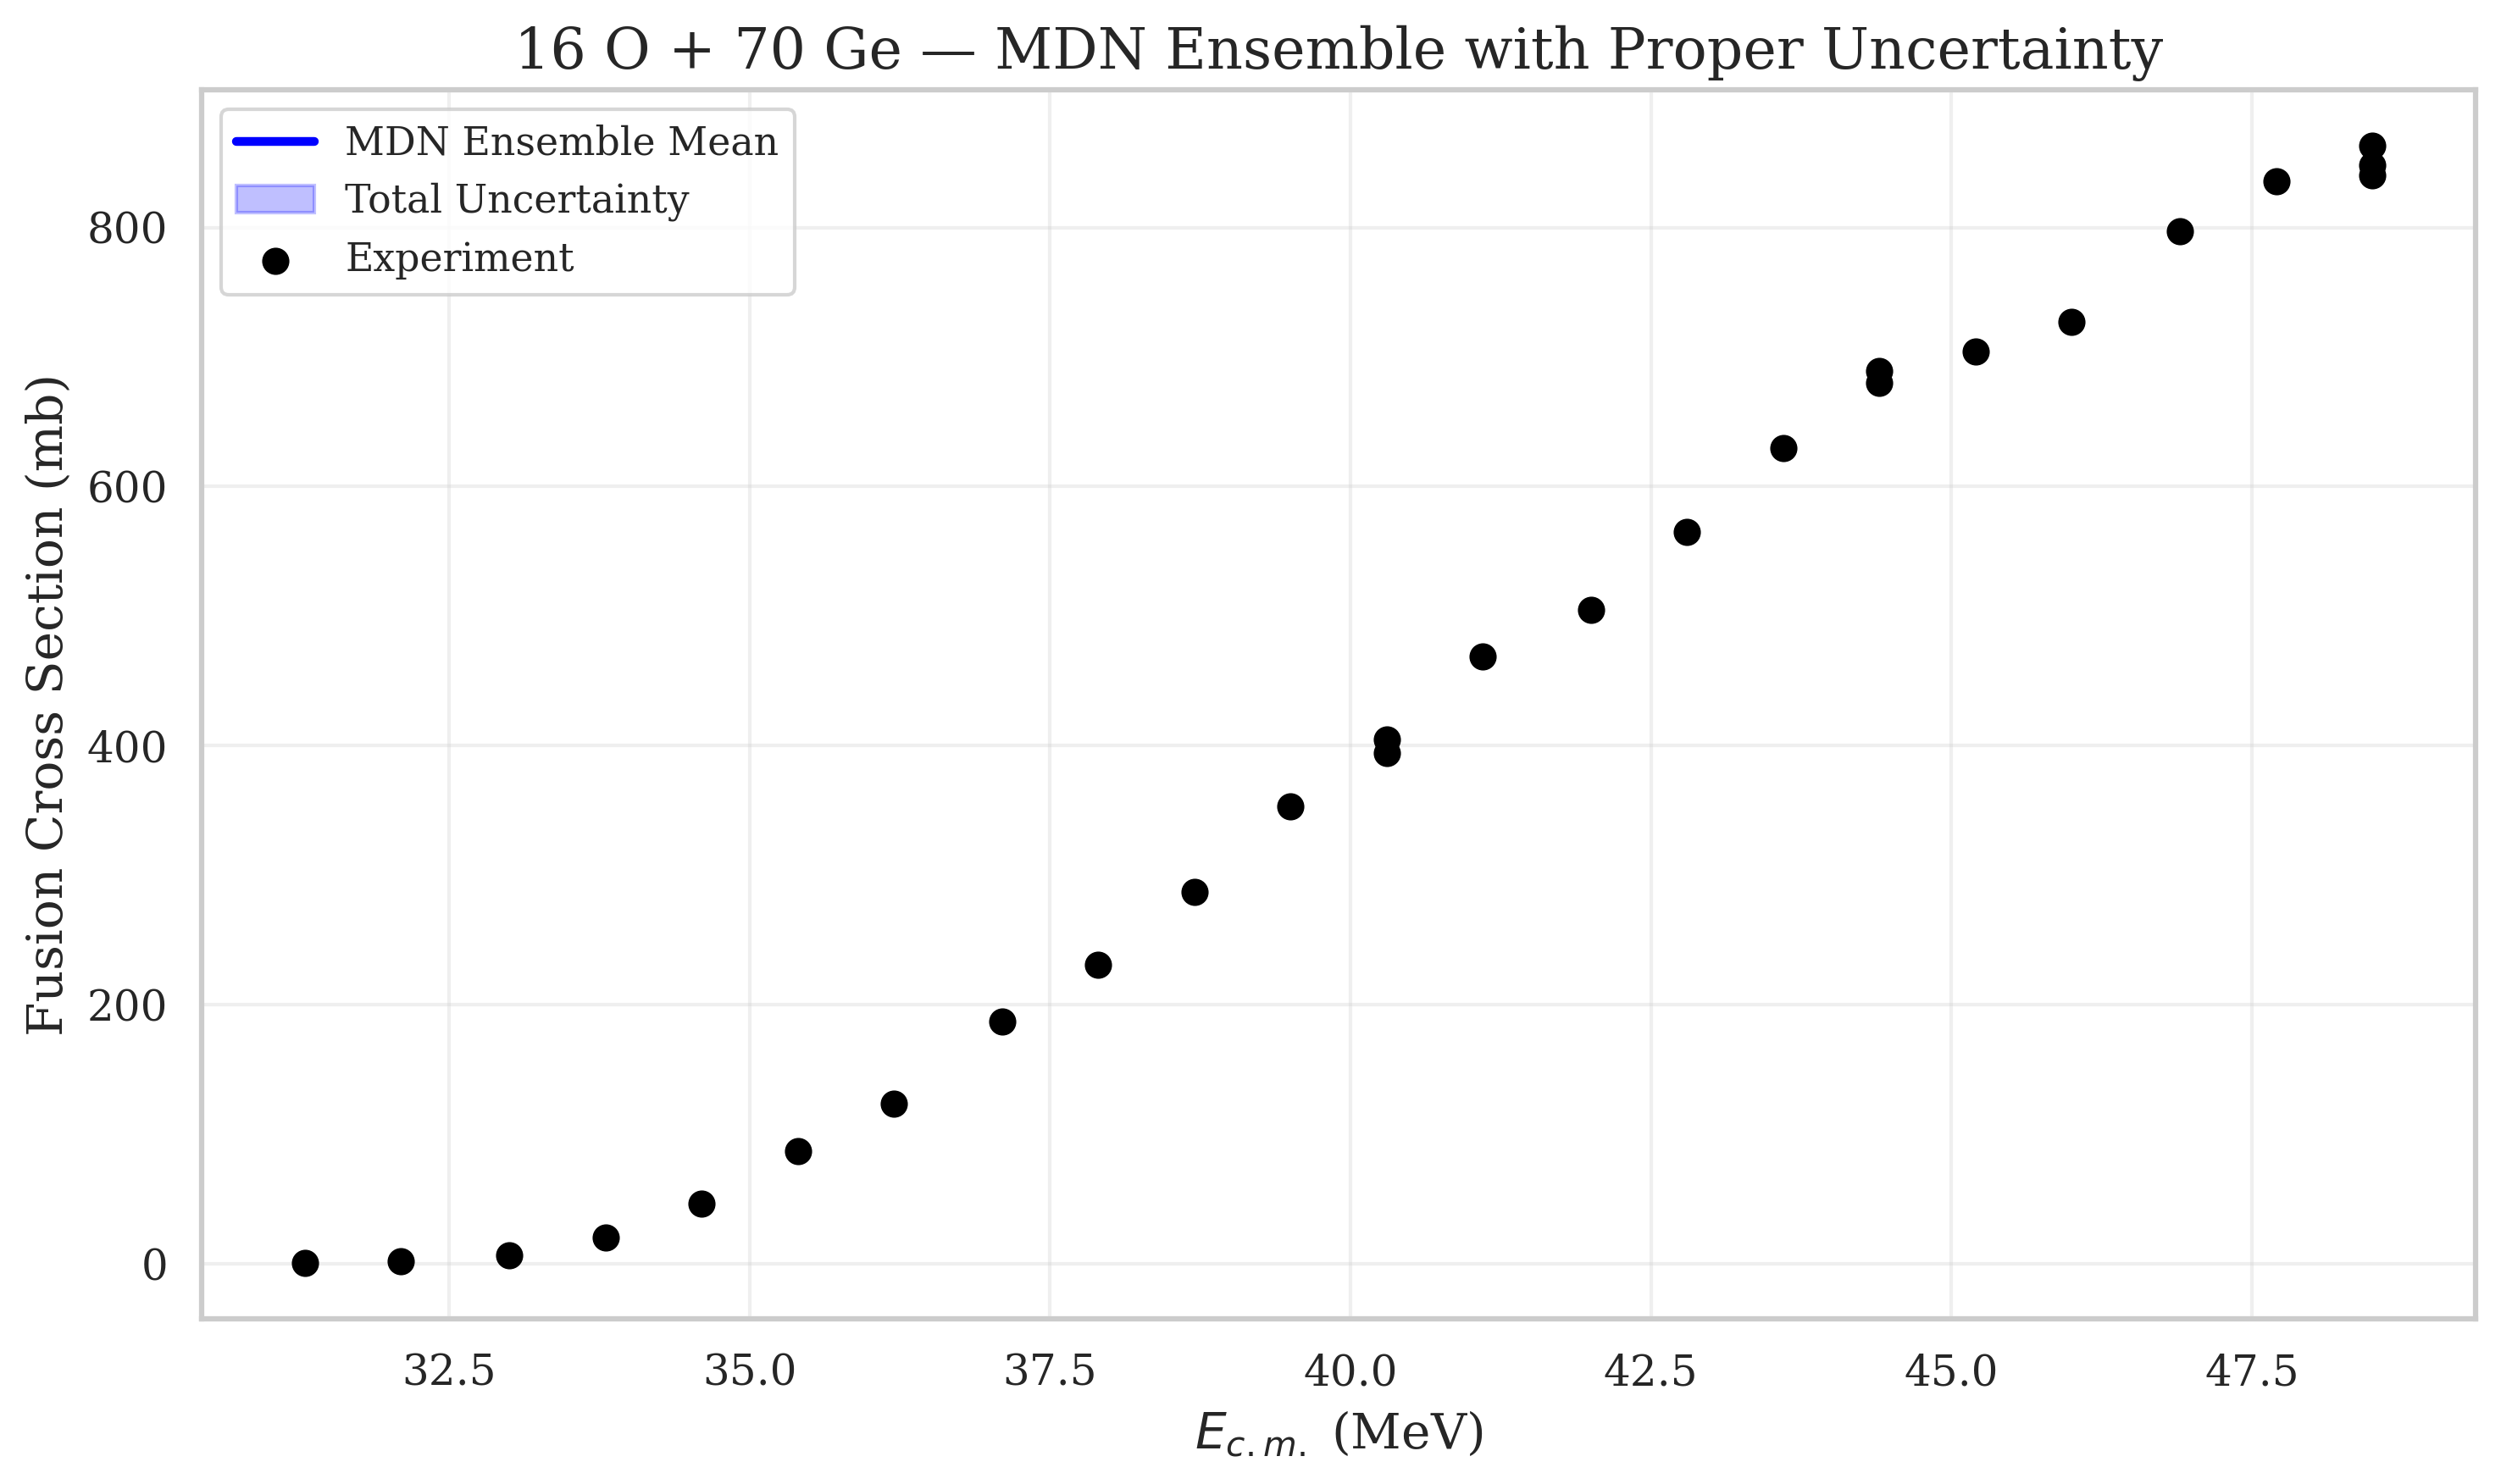

In [33]:
# ============================================================
# FINAL MDN ENSEMBLE PLOT WITH PROPER UNCERTAINTY PROPAGATION
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Add stable ID for alignment
df = df.reset_index().rename(columns={"index": "ROW_ID"})

# ------------------------------------------------------------
# RECOMPUTE S_cal (same physics as training)
# ------------------------------------------------------------
M_p = 938.272088
M_n = 939.565420
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

Ecm = df["E c.m."]
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+1e-12), 0, np.inf))
eta = (df["Z1"]*df["Z2"]) / ((1/137.035999)*(v_over_c + 1e-12))
df["eta"] = eta

log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_E = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))
df["log10_S_cal"] = log10_sigma_cal + log10_E + (2*np.pi*df["eta"])/LN10

# ------------------------------------------------------------
# LOAD ALL SEED MDN COMPONENTS
# ------------------------------------------------------------
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")

all_pi_seeds = []
all_mu_seeds = []
all_sigma_seeds = []

for seed in range(42, 52):
    file = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    data = np.load(file)

    all_pi_seeds.append(data["pi"])
    all_mu_seeds.append(data["mu"])
    all_sigma_seeds.append(data["sigma"])

all_pi_seeds = np.array(all_pi_seeds)        # (n_seeds, Nrows, K)
all_mu_seeds = np.array(all_mu_seeds)
all_sigma_seeds = np.array(all_sigma_seeds)

n_seeds = all_pi_seeds.shape[0]

# ------------------------------------------------------------
# SELECT REACTION
# ------------------------------------------------------------
reaction = "16 O + 70 Ge"   # CHANGE IF NEEDED
df_r = df[df["Reaction"] == reaction].copy()

if len(df_r) == 0:
    raise ValueError("Reaction not found.")

row_ids = df_r["ROW_ID"].values
energies = df_r["E c.m."].values
sigma_exp = df_r["σ"].values
log10_S_cal_r = df_r["log10_S_cal"].values

# ------------------------------------------------------------
# COMPUTE MIXTURE MEAN + UNCERTAINTY
# ------------------------------------------------------------
mu_mix_all = []
var_aleatoric_all = []

for s in range(n_seeds):
    pi = all_pi_seeds[s][row_ids]
    mu = all_mu_seeds[s][row_ids]
    sigma = all_sigma_seeds[s][row_ids]

    # mixture mean
    mu_mix = np.sum(pi * mu, axis=1)
    mu_mix_all.append(mu_mix)

    # aleatoric variance: Σ π σ²
    var_aleatoric = np.sum(pi * (sigma**2), axis=1)
    var_aleatoric_all.append(var_aleatoric)

mu_mix_all = np.vstack(mu_mix_all)
var_aleatoric_all = np.vstack(var_aleatoric_all)

# epistemic variance = variance across seeds of mixture mean
var_epistemic = np.var(mu_mix_all, axis=0)

# aleatoric variance = mean across seeds
var_aleatoric = np.mean(var_aleatoric_all, axis=0)

# total variance
var_total = var_aleatoric + var_epistemic
std_total = np.sqrt(var_total)

# ensemble mean in log-space
delta_logS_mean = np.mean(mu_mix_all, axis=0)

# ------------------------------------------------------------
# CONVERT TO CROSS SECTION SPACE (CORRECT PROPAGATION)
# ------------------------------------------------------------
log10_S_pred = log10_S_cal_r + delta_logS_mean

sigma_mean = 10 ** log10_S_pred
sigma_upper = 10 ** (log10_S_pred + std_total)
sigma_lower = 10 ** (log10_S_pred - std_total)

# ------------------------------------------------------------
# DEBUG CHECK
# ------------------------------------------------------------
print("Mean epistemic std:", np.mean(np.sqrt(var_epistemic)))
print("Mean aleatoric std:", np.mean(np.sqrt(var_aleatoric)))
print("Mean total std:", np.mean(std_total))

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(energies, sigma_mean, color="blue", lw=2.5, label="MDN Ensemble Mean")

plt.fill_between(
    energies,
    sigma_lower,
    sigma_upper,
    color="blue",
    alpha=0.25,
    label="Total Uncertainty"
)

plt.scatter(energies, sigma_exp, s=45, color="black", label="Experiment")

plt.ylabel("log10(Fusion Cross Section)")
plt.plot(energies, np.log10(sigma_mean))
plt.fill_between(energies,
                 np.log10(sigma_lower),
                 np.log10(sigma_upper))

plt.grid(True, which="both", alpha=0.3)

plt.xlabel(r"$E_{c.m.}$ (MeV)", fontsize=14)
plt.ylabel("Fusion Cross Section (mb)", fontsize=14)
plt.title(f"{reaction} — MDN Ensemble with Proper Uncertainty", fontsize=16)

plt.legend()
plt.tight_layout()

plt.savefig("mdn_final_cs_plot_corrected.png", dpi=300)
plt.show()


In [34]:
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")
print(df.columns.tolist())


['E c.m.', 'σ', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Z3', 'N3', 'A3', 'σ cal', 'β P', 'β T', 'R B', 'ħ ω', 'Q ( 2 n )', 'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual', 'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn', 'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy', 'Compound_Nucleus_S2n', 'Compound_Nucleus_S2p', 'Reaction', 'Unnamed: 28']



=== Making prediction band for: 16 O + 144 Sm ===


/tmp/ipykernel_146/1497971975.py:67: RuntimeWarning: overflow encountered in power
  sigma_pred = 10 ** (log10_S_cal + delta_logS_mean)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


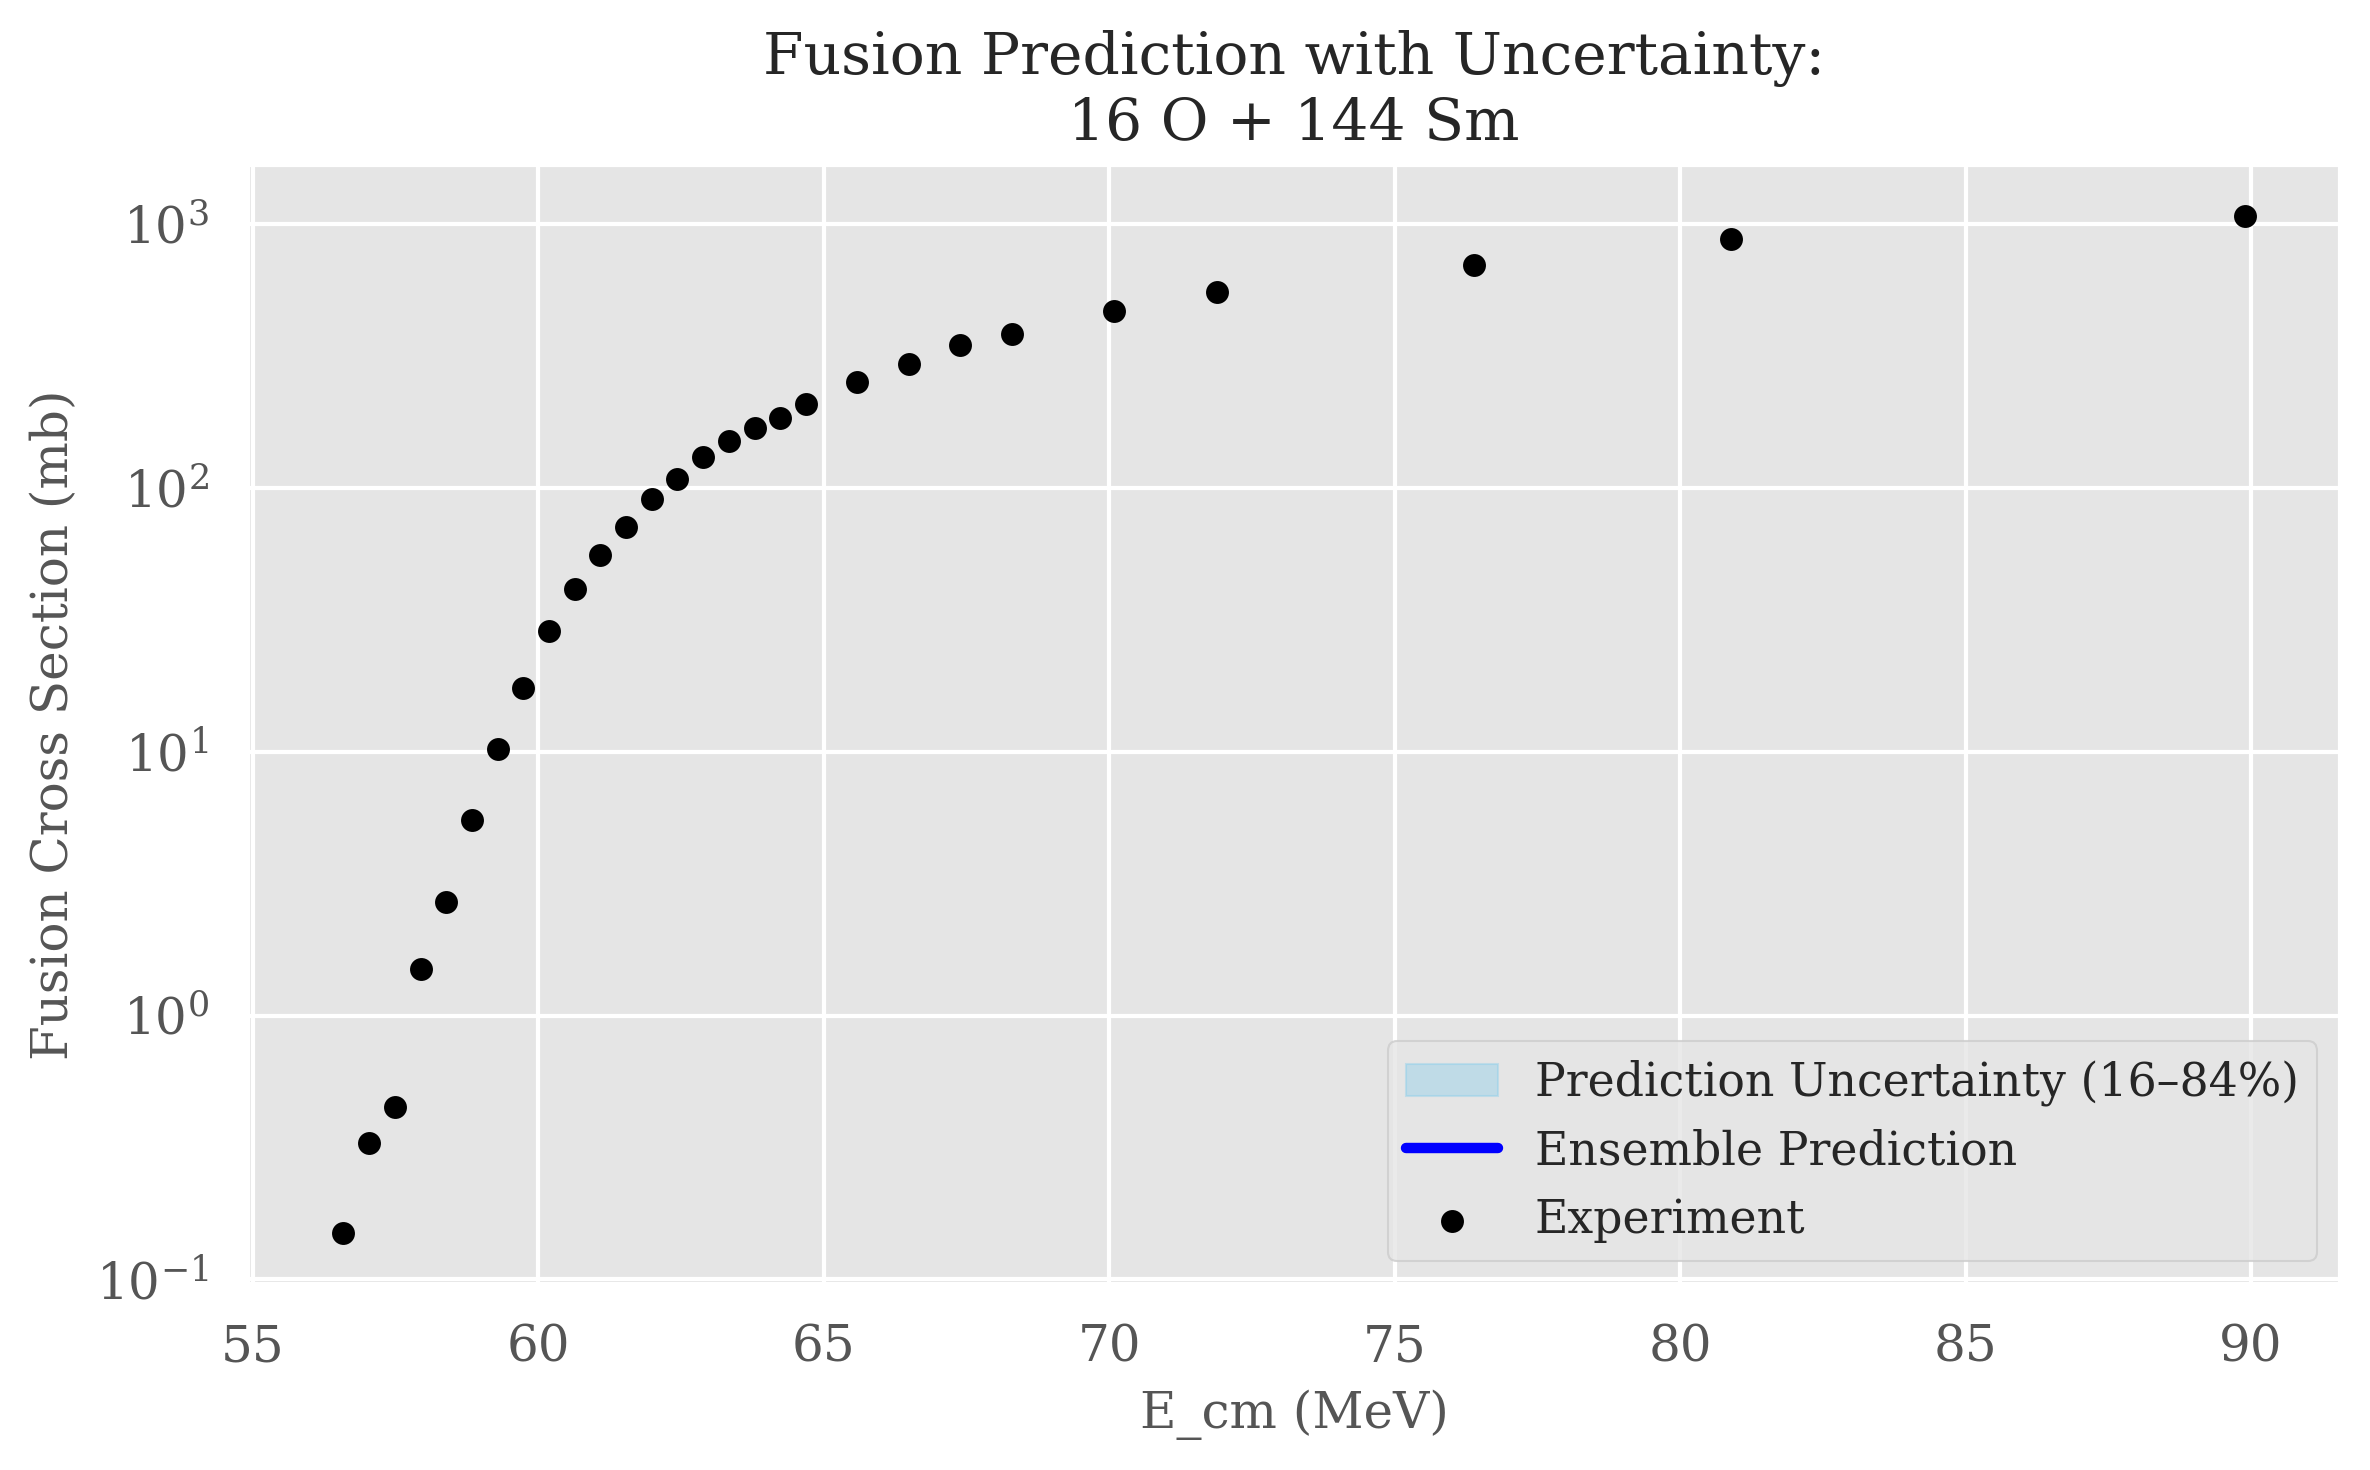

Saved: prediction_band_16O_144Sm.png


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------- LOAD DATA -------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Compute log10_S_cal for reconstruction
epsilon = 1e-30
ln10 = np.log(10.0)

M_p = 938.272088
M_n = 939.565420

def mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = mass(df["Z1"], df["A1"])
mass2 = mass(df["Z2"], df["A2"])
mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

E = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * E / (mu + 1e-12), 0, np.inf))
eta = (df["Z1"] * df["Z2"]) / (1/137.035999 * (v_over_c + 1e-16))

log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_S_cal = log10_sigma_cal + np.log10(np.clip(E, 1e-30, np.inf)) + (2*np.pi*eta)/ln10
df["log10_S_cal"] = log10_S_cal

# ------------------- PLOT FUNCTION -------------------
def plot_prediction_band(reaction_name, save_path):

    print("\n=== Making prediction band for:", reaction_name, "===")

    df_r = df[df["Reaction"] == reaction_name].copy()
    if len(df_r) == 0:
        print("Reaction not found.")
        return

    df_r = df_r.sort_values("E c.m.")
    idx = df_r.index.values
    energies = df_r["E c.m."].values
    log10_S_cal = df_r["log10_S_cal"].values

    # Load MDN components
    BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
    seeds = range(42, 42+10)
    
    all_sigma_pred = []
    all_pi_list = []
    all_mu_list = []
    all_sigma_list = []

    for seed in seeds:
        fn = BASE / f"seed_{seed}" / "mdn_all_components.npz"
        if not fn.exists():
            print("Missing seed:", seed)
            continue

        data = np.load(fn)
        pi = data["pi"][idx]
        mu = data["mu"][idx]
        sigma = data["sigma"][idx]

        delta_logS_mean = np.sum(pi * mu, axis=1)
        sigma_pred = 10 ** (log10_S_cal + delta_logS_mean)

        all_sigma_pred.append(sigma_pred)
        all_pi_list.append(pi)
        all_mu_list.append(mu)
        all_sigma_list.append(sigma)

    all_sigma_pred = np.vstack(all_sigma_pred)
    ensemble_mean = all_sigma_pred.mean(axis=0)
    lower = np.percentile(all_sigma_pred, 16, axis=0)
    upper = np.percentile(all_sigma_pred, 84, axis=0)

    # —————— Plot ——————
    plt.style.use('ggplot')  # safe style
    fig, ax = plt.subplots(figsize=(8,5))

    # Uncertainty band
    ax.fill_between(energies, lower, upper, color='skyblue', alpha=0.4,
                    label="Prediction Uncertainty (16–84%)")

    # Mean prediction
    ax.plot(energies, ensemble_mean, color='blue', lw=2.5, label="Ensemble Prediction")

    # Experimental data
    ax.scatter(energies, df_r["σ"].values, color='black', s=25, label="Experiment")

    ax.set_yscale("log")
    ax.set_xlabel("E_cm (MeV)")
    ax.set_ylabel("Fusion Cross Section (mb)")
    ax.set_title(f"Fusion Prediction with Uncertainty:\n{reaction_name}", fontsize=14)
    ax.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=400)
    plt.show()

    print("Saved:", save_path)


# ------------------- RUN -------------------
plot_prediction_band(
    "16 O + 144 Sm",
    "prediction_band_16O_144Sm.png"
)
